<a href="https://colab.research.google.com/github/Existanze54/sirius-machine-learning-2025/blob/main/Lections/L08_Gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основные алгоритмы машинного обучения

### Лекция 8. Бустинг.

#### Градиентный бустинг. AdaBoost, XGBoost, LightGBM, CatBoost. Оценка важности признаков в дереве решений. Explainability

# Идея

Идея градиентного бустинига, как и некоторых других методов, заключается в том, что мы обучаем не одну сильную модель, а много слабых. При этом каждая из из них, во время обучения, приближает нас к способности производить верное предсказание. Особенность же его в том, что после этапа и подсчета функции ошибки, градиентным спуском получает новое приближение, на котором обучается следующая модель. Таким образом, с каждой последующей моделью бустинг приближается к глобальному минимуму функции ошибки.


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/Grad_Golf.png" alt="Drawing" width= "550px;"/>


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/id_l/L7_00.jpg" alt="alttext" width=600/>

#Adaboost

Рассмотрим один первых вариант градиентного бустинга.

Допустим у нас есть набор плюсов и минусов, которые нужно классифицировать. Присвоим им одинаковый вес, потому что для этой модели вес элементов нужен.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/Ada_boost_1.png" alt="Drawing" width= "550px;"/>


Первая модель отлично отделила все минусы и верно определила некоторые плюсы. Неверно определенным элементам прибавляем веса.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/Ada_boost_2.png" alt="Drawing" width= "450px;"/>


Следующая модель обратила внимание на все плюсы, но неверно классифицировала несколько минусов. Теперь их очередь набирать вес.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/Ada_boost_3.png" alt="Drawing" width= "450px;"/>


Новая модель отделила увесиситые минусы.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/Ada_boost_4.png" alt="Drawing" width= "450px;"/>


Теперь объединяем прдесказанные модели. В этой лекции мы не будем вдаваться в подробности того, как это делает Adaboost.


Суммарно мы удачно классифицируем все представленные элементы.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/Ada_boost_5.png" alt="Drawing" width= "650px;"/>


#Градиентный бустинг

Давайте немного поговорим про градиентный спуск. Грубо говоря, это способ пошагового поиска минимума функции. Для градиентного бустинга, нас интересует непосредственно функция ошибок.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/grad.jpeg" alt="Drawing" width= "650px;"/>

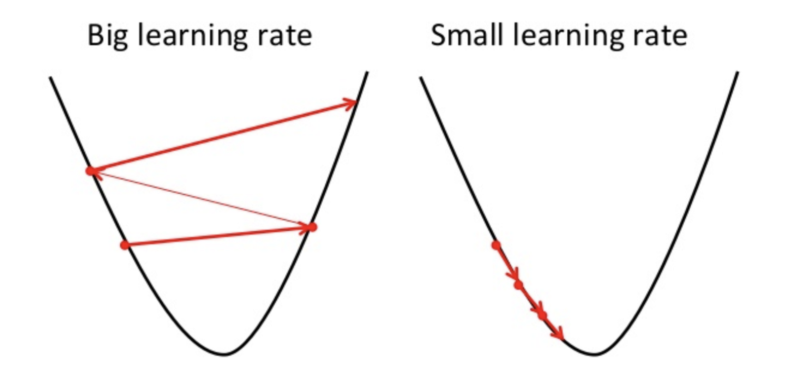

## Схема обучения

### 1. Нулевой прогноз
Обычно берут простейший прогноз — среднее значение целевой пременной:

$F_0(x) = \text{mean}(y)$

### 2. Вычисление ошибок (остатков)
Остатки показывают, насколько прогноз отличается от истинного значения:

$r_i = y_i - F_0(x_i)$

### 3. Обучение первой модели
Первая модель в последовательности старается приблизить эти остатки:

$\text{model}_1(x) \approx r$

Добавляем вклад первой модели с коэффициентом обучения $\eta$:

$F_1(x) = F_0(x) + \eta \cdot \text{model}_1(x)$

### 4. Итеративное обучение (t = 1 ... T)
На каждом шаге:

* Считаем новые остатки
$r_i = y_i - F_t(x_i)$

* Обучаем новую модель в последовательности
$\text{model}_{t+1}(x)$

* Обновляем прогноз
$F_{t+1}(x) = F_t(x) + \eta \cdot \text{tree}_{t+1}(x)$

Итог — сумма предсказаний всех моделей с весами.

В общем случае вместо остатков берется градиент функции потерь по предсказаниям.

<img src="https://www.dropbox.com/scl/fi/sp6td90gsyblfrfln5ktm/1_OZPOQUKiaVmZOEMm_-8iYA.png?rlkey=poizq3axuxcr368b57itdmu3c&st=3o66buma&dl=1" alt="Drawing" width= "650px;"/>

## Результаты обучения

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

In [ ]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}

In [ ]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3430.7807


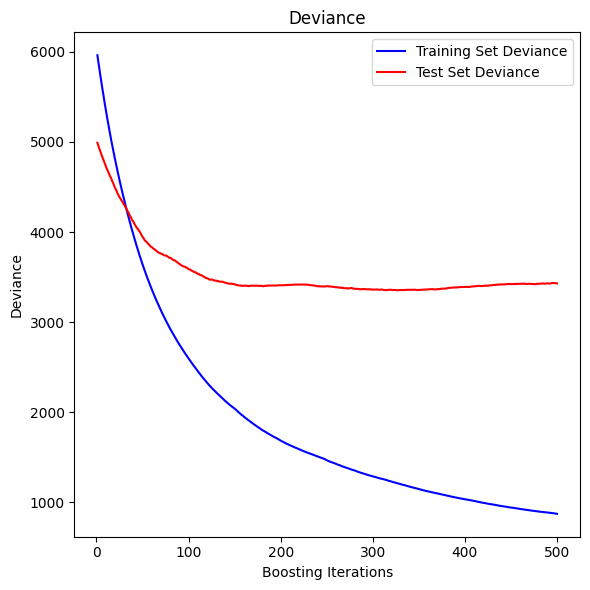

In [ ]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

На стадии оптимизации парметров имеет смысл оставить learning rate на последок. Остальными параметрами помимо шага, являются колличество деревьев и их глубину - это параметры напрямую характеризующие сложность деревьев. Мы хотим максимально простые, но еще способные на предсказания. Для этого подходят ограничение глубины дерева и минимальное число объектов в листе.

Важно помнить, что бустинги могут повышать качество предсказаний на тесте, даже если уже заучили весь трейн.

Посмотрим на Bias-Variance tradeoff на дереве, в случайном лесе и градиентом бустинге

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    from matplotlib.colors import ListedColormap
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#f7e2eb','#6ab5a6','#e0eaf4'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#f7e2eb','#4c4c7f','#e0eaf4'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "r*", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "^", c="#0795ff", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

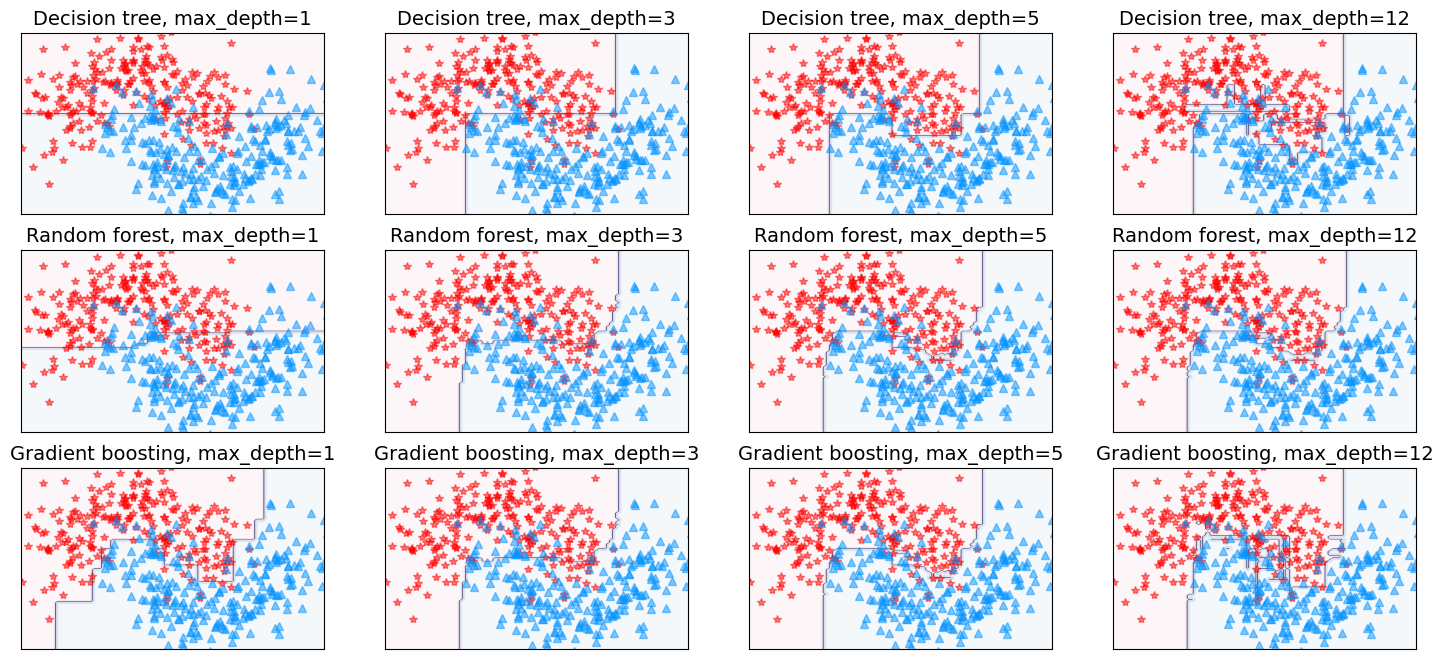

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

X, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


plt.figure(figsize=(18,8))
plt.subplot(341)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(X_train, y_train)
plot_decision_boundary(dt1, X, y)
plt.xticks([], [])
plt.yticks([], [])

plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(342)
dt3 = DecisionTreeClassifier(max_depth=3)
dt3.fit(X_train, y_train)
plot_decision_boundary(dt3, X, y)
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(343)
dt5 = DecisionTreeClassifier(max_depth=5)
dt5.fit(X_train, y_train)
plot_decision_boundary(dt5, X, y)
plt.title("Decision tree, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(344)
dt12 = DecisionTreeClassifier(max_depth=12)
dt12.fit(X_train, y_train)
plot_decision_boundary(dt12, X, y)
plt.title("Decision tree, max_depth=12", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])


plt.subplot(345)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1)
rf1.fit(X_train, y_train)
plot_decision_boundary(rf1, X, y)
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(346)
rf3 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1)
rf3.fit(X_train, y_train)
plot_decision_boundary(rf3, X, y)
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(347)
rf5 = RandomForestClassifier(max_depth=5, n_estimators=500, n_jobs=-1)
rf5.fit(X_train, y_train)
plot_decision_boundary(rf5, X, y)
plt.title("Random forest, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(348)
rf12 = RandomForestClassifier(max_depth=5, n_estimators=500, n_jobs=-1)
rf12.fit(X_train, y_train)
plot_decision_boundary(rf12, X, y)
plt.title("Random forest, max_depth=12", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])


plt.subplot(349)
boost1 = GradientBoostingClassifier(max_depth=1, n_estimators=250)
boost1.fit(X_train, y_train)
plot_decision_boundary(boost1, X, y)
plt.title("Gradient boosting, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(3, 4, 10)
boost3 =  GradientBoostingClassifier(max_depth=3, n_estimators=250)
boost3.fit(X_train, y_train)
plot_decision_boundary(rf3, X, y)
plt.title("Gradient boosting, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(3, 4, 11)
boost5 =  GradientBoostingClassifier(max_depth=5, n_estimators=250)
boost5.fit(X_train, y_train)
plot_decision_boundary(rf5, X, y)
plt.title("Gradient boosting, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(3, 4, 12)
boost12 =  GradientBoostingClassifier(max_depth=5, n_estimators=250)
boost12.fit(X_train, y_train)
plot_decision_boundary(boost12, X, y)
plt.title("Gradient boosting, max_depth=12", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

У градиентного бустинга имеется много примечательных модификаций срдеи которых - xgboost, lightgbm, catboost.

# Модификации градиентного бустинга

## Xgboost

**Xgboost** является модификацией градинтного бустинга. Работает быстрее, дополнительно штрафует деревья за большую глубину.

Чтобы градиентный спуск происходил медленно, мы используем деревья глубины 2-3

In [ ]:
import xgboost

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
xg_reg = xgboost.XGBRegressor(learning_rate = 0.1, max_depth = 5, alpha = 10, min_child_weight=9, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.393182


## Lightgbm

**Lightgbm** - оптимизированная и более быстрая модификация градиентного бустинга. В отличие от xgboost не штрафует за глубину дерева, но ограничивает число листей в каждом дереве.

Так же, отличие Lightgbm что он бьет деревья по узлам, а не по уровням. Каждое разбиение должно понижать функцию ошибки.

In [ ]:
import lightgbm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
lgg_reg = lightgbm.LGBMRegressor(n_estimators=2000, learning_rate=0.1, max_depth=-1, num_leaves=100,
                     random_state=0, min_child_weight=7, n_jobs=-1)

In [ ]:
lgg_reg.fit(X_train,y_train)

preds = lgg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 375, number of used features: 2
[LightGBM] [Info] Start training from score 0.509333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

## Catboost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


**Catboost** -  разрабатывался для улучшения точности в предсказании категориальных признаков.

Имеет большое колличество эвристик для категориальных признаков разного вида и тд. Если у вас много категориальных признаков - catboost может очеень неплохо обогнать другие методы.

****

In [ ]:
import catboost

cat_reg = catboost.CatBoostRegressor(iterations=2000,
                     learning_rate=0.1,
                     depth=6,
                     random_state=777,
                     min_data_in_leaf=7,
                     verbose=0)

In [ ]:
cat_reg.fit(X_train,y_train)

preds = cat_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.327159


# Примеры использования

## Предсказание свойств лекарств при помощи градиентного бустинга

Задача предсказания свойств вещества и его потенциальной возможности иметь лекарственные свойства является важной задачей для современной области вычислительной химии и биологии. Нахождение дешевых и быстрых способов находить и проверять теоритически записи о конкртеных веществах - путь к серьзному ускорению и удешевлению процесса разработки лекарственных препаратов. Неудивительно, что работы в этом напрвалении идет сразу во многих подобластех, от квантовой химии до машинного обучения.


Один из подходов к таким предсказаниям - это оценивать аффинность конкретного соединения к возможной мишени. С помощью модификаций градиентного бустинга это тоже можно проворачивать.

Simboost и SimboostQuant, которые работают в паре. Simboost  предсказывает аффинность между предполагаемой мешению и соединением, а SimboostQuant пытается предсказать точность полученной оценки.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/id_l/L7_01.png" alt="alttext" width=600/>

doi.org/10.1186/s13321-017-0209-z


Кроме этого, xgboost часто используется в качестве "надстройки", над признаками, полученными от нейросети. Так делают, в частности, в статье [DeepSEA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768299/).



<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/paper0.png" alt="Drawing" width= "800px;"/>

Еще пара примеров.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/paper1.png" alt="Drawing" width= "800px;"/>

https://pubmed.ncbi.nlm.nih.gov/30873528/

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/paper2.png" alt="Drawing" width= "800px;"/>

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2527-1


# Оценка важности признаков в дереве решений

В биологии как правило нам важно не только качество предсказания, но и то, какие именно признаки использует модель. Это позволяет находить новые биологические закономерности и оценивать биологическую релевантность модели

Существует множество методов, позволяющих оценить важность признаков для модели. У каждого из этих методов есть свои минусы и плюсы, часть применимы только к деревьям, часть подходят для разных моделей


## Gini impurity


Эта мера считает, что важность признака для дерева определяется тем, насколько часто данный признак участвует в разбиениях и насколько хорошие разбиения позволяет производить.

Также этот критерий учитывает то, что разбиения в начале дерева более важны, чем последующие.

Критерий может быть немного по-разному реализован, из-за этого разные библиотеки выдают разные значения Gini impurity важности для признаков. Обычно эти отличия не влияют на ранжирование признаков по важности.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost

diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

cat_reg = catboost.CatBoostRegressor(iterations=2000,
                     learning_rate=0.1,
                     depth=6,
                     random_state=777,
                     min_data_in_leaf=7,
                     verbose=0)
cat_reg.fit(X_train,y_train)

print(cat_reg.feature_importances_)

columns_dia = ["age", "sex", "bmi", "bp", "s1 tc", "s2 ldl", "s3 hdl", "s4 tch", "s5 ltg", "s6 glu"]

[ 9.91202263  4.18228747 19.54798952 12.50446699  6.86386547  7.89228715
  7.25489613  5.11804151 17.91383391  8.81030923]


In [ ]:
X

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990749, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06833155, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286131, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04688253,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452873, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00422151,  0.00306441]])

<Axes: xlabel='amount', ylabel='Compound'>

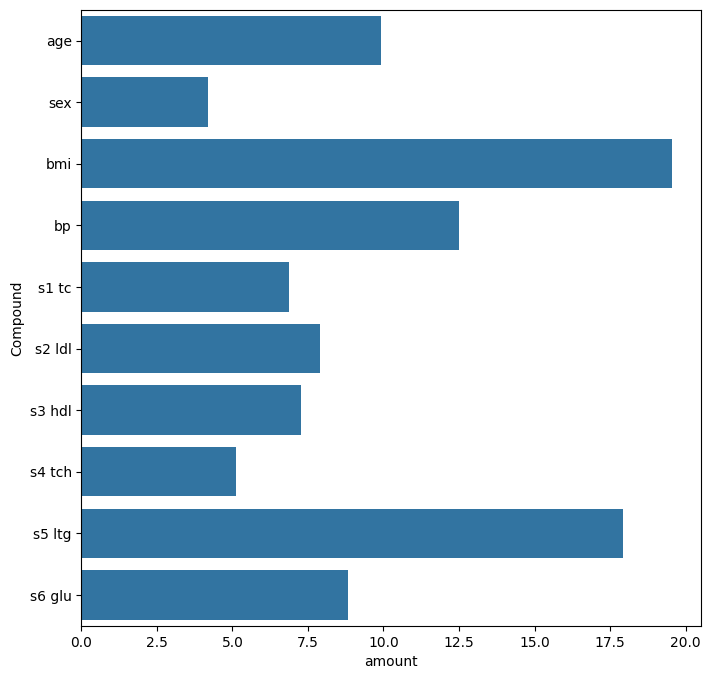

In [ ]:
df = pd.DataFrame({"Compound": columns_dia, "amount": cat_reg.feature_importances_})

plt.figure(figsize=(8,8))
sns.barplot(data=df, y="Compound", x="amount", orient = 'h')

## Перестановочный метод.

Можно оценить знначимость признака перемешав его значения. Если признак важный, то точность предсказания при таком перемешивании начинает падать. В зависимости от того на сколько точность падает в сравнении с исходным качеством, становится ясна важность признака.


Минусом такого подхода является ошибка при работе с кореллированными признаками - их значимость будет завышена.

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
r = permutation_importance(cat_reg, X_test, y_test,
                            n_repeats=100,
                            random_state=0)

<Axes: xlabel='amount', ylabel='Compound'>

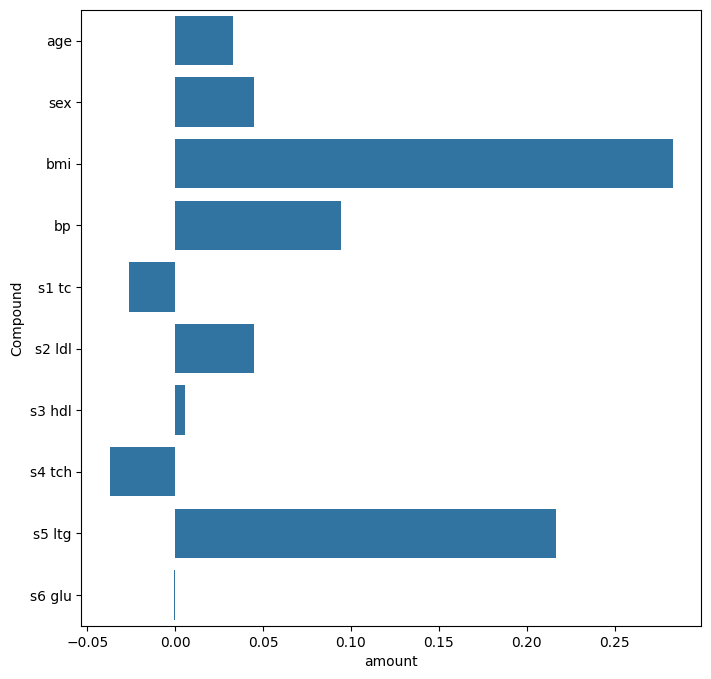

In [ ]:
df = pd.DataFrame({"Compound": columns_dia, "amount": r.importances_mean})

plt.figure(figsize=(8,8))
sns.barplot(data=df, y="Compound", x="amount",orient = 'h')

#Boruta

Boruta - метод, который позволяет выбрать признаки, которые модель **значимо** считает важными. Они не возвращает важностей признаков напрямую (только нестрого ранжирует отобранные), но зато избавляет нас от необходимости выбирать порог, на котором мы считаем признаки значимыми.


Создадим на основе нашего датасета датасет с теневыми признаками.
Теневой признак - это исходный признак, который перемешан вдоль строк.  За счет этого его распределение сохраняется, а вот связь с предсказываемой переменной теряется.


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/boruta1.png" alt="alttext" width=600/>

Далее добавим колонки из теневого датасета в датасет с исходными признакми.



После этого обучимся на таком датасете предсказывать целевую переменную и возьмем полученные каким-то способом важности признаков.

Считаем хорошими только те признаки, которые по важности лучше теневых.

Однако на этом нельзя остановиться: перемешивание - случайный процесс, и потому некоторые признаки могут проиграть теневым по случайным причинам.

Потому повторяем процедуру много раз. Для каждого признака мы будем знать сколько раз мы посчитали его хорошим.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/boruta_bell.png" alt="alttext" width=600/>

Те признаки, которые считались хорошими очень часто - можно взять. Те признаки, которые проигрывали теневым очень часто - можно выкинуть.
Останутся пограничные признаки, которые незначимо отличаются от теневых, и непонятно, в какую сторону. Обычно их тоже выкидывают

In [ ]:
!pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
from sklearn import preprocessing
from boruta import BorutaPy

In [ ]:
fetch = BorutaPy(reg,
                 two_step=False,
                 n_estimators=100,
                 perc = 90,
                 verbose=2,
                 random_state=42)
fetch.fit(X_train, y_train)
fetch.support_
fetch.ranking_
X_filtered = fetch.transform(X_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration:

In [ ]:
ranks = list(zip(diabetes.feature_names, fetch.ranking_, fetch.support_))
#X_check, y_check = diabetes.data, diabetes.target

X_check = []
8_05
for n, feat in enumerate(ranks):
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: age                       Rank: 4,  Keep: False
Feature: sex                       Rank: 8,  Keep: False
Feature: bmi                       Rank: 1,  Keep: True
Feature: bp                        Rank: 1,  Keep: True
Feature: s1                        Rank: 6,  Keep: False
Feature: s2                        Rank: 2,  Keep: False
Feature: s3                        Rank: 3,  Keep: False
Feature: s4                        Rank: 7,  Keep: False
Feature: s5                        Rank: 1,  Keep: True
Feature: s6                        Rank: 4,  Keep: False


# Explainability

Часто нам нужно не просто отобрать значимые признаки, но мы еще хотим понять, почему модель приняла то или иное решение по поводу данного объекта.



## Детекция неправильного построения датасета



### Хаски
Один из известных примеров - нейросеть, обученная отличать волков от собак породы хаски, научилась отличать их на основе снега на заднем фоне.

Просто волки встречаются на снегу очень часто, а хаски - редко.





<img src="https://kodomo.fbb.msu.ru/FBB/year_20/husky_wolf.png" alt="alttext" width=600/>



### Лошади

Другим известным [примером](https://www.nature.com/articles/s41467-019-08987-4) является история про то, как модели определяли фотографии лошадей на основании подписей на картинках.

Фотографии в датасете были собраны из интернета и с них не были удалены подписи заводчиков.



В результе если подпись на картинке с лошадью есть, то модель распознает лошадь. Иначе - нет.
<img src="https://kodomo.fbb.msu.ru/FBB/year_20/cleverhans_horse.png" alt="alttext" width=600/>



Более того, если перенести подпись заводчика на картинку с машиной, то она будет классифицирована как картинка с лошадью

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/cleverhans_car.png" alt="alttext" width=600/>

## Медицинские изображения




На медицинских изображениях [тоже](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002683) могут быть специфические метки, например, от врачей или прибора.

И нейросеть может научиться детектировать именно это.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/chest_radiograph_explain.png" alt="alttext" width='300px'/>


## SHAP

Одним из методов, позволяющих объяснять предсказания модели является SHAP.

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAsQAAAG5CAYAAACJASIBAAAACXBIWXMAAAsTAAALEwEAmpwYAAAgAElEQVR4nOzdX3LaWP738a+n5t7IXbkHTxYQD2QDsXBf/6rAzgLGorOAbuPu62eMuxeQRvQCOhFVcx1EewMxDQvIIN+nEikr0HOROWoBAiQMSKD3q4qKY2M4tnWOPjo6fw583/cFAACkyrZtubu7k/v7exERcV1XNE2TSqUi5XJZarVayiUE9tcBgRgAgHR4nie3t7fSbrfFdd2lz6/VatLpdKRQKGyhdEB+EIgBAEhBp9ORq6urWEF4WrPZlJubmw2UCsgnAjEAAFvWaDTENM2JzxWLRXn58qW8ePFCRESePHkiHz9+lLu7O7FtWwaDwcTza7WaWJa1tTID+4xADADAFl1fX0ur1Qr+r2ma3N7eyuXl5cLvs21brq+vJ4Kxruti2/bGygrkBYEYAIAt6XQ6YhhG8P9VAu1077JhGNJut9dWRiCP/pZ2AQAAyAPP85aGYTXJ7uDgQK6vryNfp91uS7PZDP5vmqaMRqPNFBrICQIxAABbcHV1FXysadpEGHYcRw4ODkTXdRmPxyIiC1eSuLm5EV3Xg///3//93wZKDOQHgRgAgC0ID3O4vb2d+FqpVBLf9+X+/l6azaZomiae58V+vYeHB8YSA49AIAYAYMO63W7wcbFYXDqBLo5SqTQxBOPPP/989GsCeUUgBgBgw8K9t999993C52qaJq7rxtp8o1qtBh//+uuvqxcQyDkCMQAAGxZeKu2f//znwucm2agjPI74y5cvyQsGQERE/p52AQBgWw4ODtIuAiBPnz5d+HVN02KNIRaZnHjnuq54nse2zsAK6CEGACBDXNeNPWRC5GuABvA4BGIAALYoztCGuD3EIpNDLOgdBlbDkAkAucQmndimer0erDTx/v17efbs2cLnx+0hDk/WKxaLjyojkGf0EAMAsGFnZ2fBx8u2WU4yhvju7i7yPQAkQyAGAGDDwqtBDAaDhVstJxlD3Gq1go/DS7ABSIZADADAhpVKJanVasH/v//++5nnXF9fS6lUkuPjYxERaTabUqlUpF6vR75meLc7TdMmXh9AMgc+A+kA5ER42TWaPmzbaDSSk5OT4P+tVkuurq5Wei3btieGSJimuZbd74C8IhADyA0CMdIWnlwnsloong7D5XJZ7u/v11ZGII8YMgEAwJZYliXlcjn4f7PZlEajEXuJtdvb24kwXCwWpd/vr72cQN7QQwwgN+ghRhZ4nie6rk9s5ywiYhiG1Gq1mclxo9FI3r17J7e3txNrDheLRbm7u5NSqbSVcgP7jEAMIDcIxMiS6eETYZqmyeHhoTw8PER+nWESwHoxZAIAgBRYliWWZUVuqOG6bmQY1jRNWq0WYRhYM3qIAeQGPcTIqm63K7ZtS6/XmwnCmqbJ6empXFxciK7rbM8MbACBGEBuEIixCzhOge1jyAQAAAByjUAMAACAXCMQAwAAINcIxAAAAMg1AjEAAAByjUAMAACAXJsbiOPuqw4AyAfbtqXRaKRdDABYu5lAPBqNpFQqiaZpcnBwIKPRKI1yAQAyplqtytHR0dzthgFgV00EYsdx5MWLFzIcDsV1XdF1PXJLyU26vr6Wg4MDOTg4kFKpRMMLABliGIa0Wi2xbVsqlUrQXh8cHEilUqHNBrCTJgKxaZpSLpelUChIoVAQ27a3ukVktVqV33//XXzfF9/35T//+Y/U63XpdDpbKwMAYD5N0+TTp09iGIZYlhW0177vi2VZMhgMpFQqcXcRwE6ZCMTtdlt0XU+lILZtS7/fl//85z/B5549eyaGYcjV1RVjmgEgZY7jiK7r8uOPP8rTp09F07SJr5dKJbm5uZG7uzv5/vvvabcB7IyZMcRpNWCmaUqxWJRnz55NfP7Vq1fiuq5YlpVKuQAAXxmGIc1mUy4vL+WXX36Ry8vLyOeVSiX55ZdfRNd1QjGAnfA3ka9X/aVSSVzXlVarJZVKRSqVylZvef3xxx9SqVRmPn94eCgiIr1eb2tlAQBMUkPoarWaiEjQeTHvPPHs2TOpVqvS7/e3VkYAWNXfRL5ezQ+HQ9E0TVqtltzf38v9/f1Mb21Yo9GYmEyx6HF9fb2wEI7jiEh073SpVJJisUgvAwCk6O7uTi4uLiY+9/PPPy8cGnFxcSHtdnsbxQOAR/m7+sB1XXFdN/Y3ttttaTabsZ5bKpViPW/e+OUvX74kKhsAYL3u7+9nAnGpVJJKpSL9fj/oOQ47PDyk7QawE/4e/o+maYl6YuMG3WU0TRPXdZe+t+d5W131AgDw1YcPHyKX4by5uZFqtSq6rs+0z6VSSUqlEm03gMz7+/Qn4jZajuPIYDCQw8ND+fLly8J/nzx5snD4hepB+PDhQ+T7iHxtWGlQASAdT58+lYeHh8i2/Pz8XG5vb+Xm5mbi847jiOM4tN0AMi8IxHF7aZV+vy/39/exnlutVhcG4lKpJLVaLfL11HCJp0+fxnovAMD6HR8fy4cPHyLb8svLS6lWqzIajSa+/uXLl5ml2QAgiybGEIvE7yG+vLycu+TOKs7OzqTb7c40qO/fvxcRkaurq7W9FwAgmVevXsn3338fOVZY5OvSmfV6faJj4/Xr19JoNLZVRABY2cQ6xEnHEK/T5eWlFItF+f7774PPOY4jV1dX0mw2ueUGAClSHRXztmYulUpSrVaDnUVHo5EMBoO5ARoAsuRvIl/Xlzw+Pg7WIa5Wq6kE47u7OxEROTg4kEqlIsfHx1Kv12fGpQEAts80TTEMY24ovrm5kbdv30q325V//etf8ttvv225hACwmgPf9/20CzHN8zxxXXdtq1gAgMjXi20lg03fTvA8T3Rdl1KpJD/99NPEEDfHceSHH36Qbrcr4/GYNnxFHKfA9s2sMpEFhUKBIRIAkEGFQkHu7+/Ftm35/vvvJ3aiK5fL0mw2xfM8JtMB2CmZ7CEGgE2g5207RqOR/L//9//Esqy0i7KTOE6B7fvb8qcAABCfGkYxGo1SLgkAxEMPMYDcoOcNu4DjFNg+eogBAACQawRiAAAA5BqBGAAAALlGIAYAAECuEYgBAACQawRiAAAA5BqBGAAAALlGIAYAAECuEYgBAACQawRiAAAA5BqBGAAAALlGIAYAAECuEYgBAACQawRiAAAA5BqBGAAAALn297QLAABpODg4SLsIAICMoIcYAAAAuUYgBgAAQK4xZAJAbvi+n3YRdoLneWJZlvR6Pel2u3Ofp2mauK4rIiLFYlFERB4eHuY+v1arycXFhei6LoVCYZ1FBoBHOfA5QwBA7qkQ/PbtW+n3+3OfVywW5eXLl3JxcSEiIicnJyIiouu62LYtjuOIaZpi27YMBoO5r1Or1eTs7Ezq9TrhGEDqCMQAkFOO48jbt2/l119/XdizWy6XpV6vy/n5uZRKpeDztm3L2dlZ8Jz7+/vI17csa2E41nVdzs/PCccAUkMgBoAcGY1G8ubNG/n9998XhuA4ITUciFUP8Tye50m73ZZ+v7+wB7pcLkuj0RBd1yfCNwBsEoEYAPacbdvS7XbFsqxgzG+UpGN8kwTiMDU8o91uL+w5LhaL8uOPPxKOAWwcgRgA9lC32xXbtsU0zYXPMwxDqtWq1Gq1ld6jXq+LyNcwbVlW4teIO4FPjV02DINwDGDtCMQAsAeSTIo7OzuTV69eybNnzx71np1ORwzDEJGvwbrdbj/q9QjHANJCIAaAHeU4jvT7/VhDD9TKEI8NwWHhQLxqD/Ei3W5X3rx5s3Tpt3q9vpaADyC/WIcYAHbIaDSSd+/exVoZYpuT046Ojtb+mrVaLRjKMW8IiOu6YpqmmKZJOAawMnqIASDjbNuWu7s7abfbCyfFbXv5snWMIV71fW3bXjhJUIXjWq0m1Wp1K+UCsLsIxACQQXFCn8hfK0OsMinusdY9hngVcVbQ0DRNTk9PU/s9Acg+AjEAZIDnedLv92ONmT09PQ1Wh0jTpscQJzUajeT169eZvogAkE0EYgBIiZoUF3e75BcvXqQegsOy0EM8j+M40mq1pNfrLRxrnXTtZQD7iUl1ALBFcbcz3tTKEOukaVrw8efPn1MsyaxSqRQEdMdxxDTNyN35ut1u0CNfq9Xk7OyMLaSBHKKHGAA2LO52ybu2bXGWe4jnWRSOw7Y9QRFAugjEALABcbdL3uXglbUxxEnF7a1Xf6NduVABkByBGADWRG0k8ccff+RiUtcu9hDPEzcc71ovPoB4CMQAsKJdXBlindJah3jTkmyD/d1338n5+TnhGNhxBGIASED1JPb7/VgrQ2R5UtxjXV9fS6vVEhGRZrMpNzc3KZdo/QjHQD4QiAFgiSS306vVqhiGkYtQlIdAPK3T6Uiv11t4RyAPF0PAviEQA0AEtcnDsnVsdV0XXdel0Wjs3KS4xwoH4larJVdXVymXaHtUz/GycKy2kH716hXhGMgw1iEGgP+JuzIE69V+Ff7ZPc9LsSTbVygU5PLyUi4vL0XkrwmV0+HYdV0xTVNM0wzCca1W26ux5MA+IBADyK2kk+L2YWWIdcpbCF6kVqsFx4Zt22Ka5sxqI4RjILsIxAByJemt7mq1SghGItVqNQi58+46TIdjLriAdBGIAew9x3Gk3+9Lu93e+e2SsyrPQ0cWUeG43W4H49KjwvH0FtKEY2C7CMQA9pJaGeLXX39dul1ynlaGWKc8jyFexbNnz6Tdbku73RbbtuXu7i5yC+lwOFYTNnVd56ID2CACMYC9wcoQ20UIXp3qOb65uZHRaCRv3ryRdrs9M5kzvN41kzmBzWHZNQA7rdvtim3brAyRgjyuQ7xpce9s6Lou5+fnHM/AmhCIAeyU8KS46Vn8YUxU2rw8r0O8DY7jiGmaYtv2wrHvKhzrus6wH2BFDJkAkHlxt89lKavtYgzxZpVKJbm5uZGbmxvxPE/a7XbkbonhYRXlclnq9TpbSAMJ0UMMIJPibpfMyhDpYchEOlTdCAfhKMViUb777jvCMRADgRhAZoxGI3n37l2slSHoBUtfo9EQ0zRFRMQ0zWDXNmxP3LsnKhx/++23XDgCEQjEAFIVd7tkxklmT71eD5YHsyyLsdopi7vpjLqrwlKDwF8IxAC2jpUh9gM9xNnW6XRi78j46tUreo6RawRiABvHdsn7KdxDTCDOtm63K2/evCEcA3OwygSAjWBliP13dHSUdhEQU61WCy4yVTieXrbQdV0xTVNM0wyWLTQMg3qJXKCHGMDasDJEvjCGePep4Utq6EsU1vRGHhCIATyK2nb2999/X7gyBEtA7R/GEO+XuBNca7Ua4Rh7h0AMILGkK0MwKW4/MYZ4f41GI3n9+nXsia/87bHrCMQAYpk37nAaK0PkBz3E+RD3LhAXwNhlBGIAkVgZAsvQQ5w/hGPsKwIxgIDjONLv92PtenV2dsbKEDlHD3G+qUm0y3aW1HU9CMjMH0BWEYiBnEu6MgS7W0FhlQkoccNxuVyWRqPBjpPIHAIxkENxb3uWy2Wp1+v07CASPcSI4nmetNvtWBfZrDyDrCAQAzmh1hpdNimOsX+Iq1KpBIGn1+sxfAYz1DCsdrsdKxx/++23rE2OVBCIgT0WZ7tWEVaGwGqq1Wow1pxAjGXi7l7Jxj1IA4EY2CNJt0tmZQg8RriHeDgcEl4QW9xVbNQE3levXnF8YaMIxMCOU+P1+v0+K0Ngq+ghxjp4nif9fn/p3Sx1IU8bhk0gEAM7aDQaybt375bO6GZlCGwSY4ixCXGGehGOsW4EYmBHqK1Ue71erJUhGo0G44GxUfQQY9O63a7Ytr1wC2lN0+T09FQuLi4YAoaVEYiBDGO7ZGQZY4ixTSocq6X+5qnVaoRjJEYgBjIk7lg6kb8afV3XCcFIBT3ESIu6Y7ao51iEzgLERyAGUrYPK0OEZ4w7jiOaponrulIqlaRSqbDw/p5iDPHjeZ4n79+/l7u7O7FtO/i8pmlSqVTk+PiYMLdE3OFkhOP9NX0OUhKdg3wAWzcej33TNP1yueyLyNxHsVj0DcPwh8Nh2kWO5LquX6vVFv4M4Z8lqz8HVqPrevD37fV6aRdn5zSbzVh1R0R8Xdf98XicdpEzbzgc+s1m0y8Wi0t/n6Zp+q7rpl1kPILruhPt0LJz0KJ2ikAMbEnchrpYLPqtVivz4bHVasU+mYcftVot7aJjTcIXdFk/XrPEsqyl7cC8h2VZaRd/ZyQJx61Wi3C8Y0zTXKkONZvNyL81QyaADYo7zm3XVoao1+szY5zL5bI0Gg15/vy5fPz4UZ48eSLv37+PXHi/WCzK3d0dwyh2ULfblcFgIIVCYWLZv1qtJk+fPhURkaurq504jtMQVXfCO7OpuvPx48dgGMX0lsflcln6/T6/4wQcx5G3b98uXapStcUM88ouz/OkXq/PDDHUdV3Oz88nzkEfPnyInJheLBblP//5z+RE4K1HemDPWZbl12o1X9O0pT2lu3jLbnqIRLlcXnor13Vd3zCMme/D7rEsizsAK5q+tatpmt9qtZZ+X6/Xm2lPisXizrUdWeG6rt9qtWINWWu1WgxVyZjpv1uc4XhRQys0TZuoQwRiYIG4DaFpmrHG0tZqNd+yrJ09kfV6vYmfxzCMRN8/fYur2WxuqKTYpEW3oBk6EW16iJGu64nagaiLSl3XN1jifEgyn6PZbHJ8p+yx5xDTNCcuLsMX8ARiYI7hcOiLSGQoVo3ossH8mqb5hmHsxYQj13XnNiS+//V3Ev59FIvFyPGO0w0avS+7Z/rCiIC22Hg8Xnoh2ev1ZupPVLsxXX9M09zGj5ALrusSjjNsuh4tC8O9Xs8vl8szf6fpOqTqGYEYiBA+4atbmuPxOPZttiyvDLGq6d6pcO+W+n2FA7CaQR91Cz38OyRE7aaoIUFc3EQLB92ooULqBB1uM1T9iTrph3ubp2/7Yj1UOF525y9Oe++6LnfD1iD8tygWiwufOx6PgzYq6m8TrpOqDhGIgSnTYySLxeLSWcrlctlvNpt7Gwhc113YK6Ual+mGR31+mup9n75Cx+6IGgKAWdN1J6qN0HU9MihrmjZ3rH34goT6s1lxw7G6IzjdDqpzCqF4ddO9w8s6nNTfYt5zp+949no9AjEQNu9W8Lzbw3mZcBG+SIg6QVuW5eu6PtPwqF6uqAYpfHLhRLGbwieUPNSDVYRvz867aOj1epGT61RQjuoBDq9hzETG7VITp5edI9RwOdq6xwvXo2XHu67rwfloUXgO1yHDMAjEgLJs9ryqiLu4MsRjhYdLxJkVP/19UQ3SspCN7FO9xASy+cK3ZpOO9120CkX44n3Z7WNsTtxVhcIPQnFy4Xq0aC1uNQbc9/+qI/MC8XQdIhDvkLiVjQePTT6S3J4tFotze8WmbyVvWtq/Nx484swrGI/HwQTVZRca4ddG+izL8g3DiBWOuYhMJjzvZN45SPUIqw6rZT3Evj9Zh/4mAJCA2nxhmU6nIw8PD/LLL79Efp1NBZA3h4eHC7/uOI4cHx/L8fGxFAoFMQxj4fM1TQs+9jxvLWXE6mq1mrTbbfn8+bNYliWGYUz8jcK63a7U6/Utl3B3jcfj4OPnz5/PfN1xHDk5OZHhcBicWz5+/Lj0dcN/n7+voZwAMGE0GolhGDIcDid3ApqiaVqwe5DjOOwMhVwrlUri/2/z2NFoJCcnJ6Lruti2Hfn8RbtfbsLBwcFW32/fdbtdfqcreHh4mDmvlMtlsSxr4vNPnjxZ+lrhOkQg3lE+O25jiyqVSrB97JcvXxY+V/V8LAvDIpON0TbDMPUH21KtVoMtZj98+BD7OH/27JmYpimGYchoNJqpS47jBB9rmsYdF+TGdM9vp9MR13Xn9rifnJyIiMyck6brEEMmACwVPom/e/du7vM6nU5kGI66nRvu9SoWi+spKJAxlUol+Ljb7Sb6XnVr+MOHDzNfe/v2bfBxuVxesXTA7pmuR7quS6/Xm3mYpikiIq1WS3q93sx5ZroOEYgBLHV2dhZ8rHq7pl1fX8u///1v8X1/Igzbti2Xl5czz7+7u4t8fWCfXFxcBB9bljXzdc/zpFqtyvX19czXXr9+LSLR4/bDr3V+fr6Ooibif93YiwePrTyGw+HEsR/uZCmVSlKtVmceKgB/++23Uq1WZ+6i/Prrr8HH5+fncuD7PvcOd0R4rBF/NmyTmuyjTPcAq9vCtVpNjo6OJr5XTYYI9wh7nifHx8fBkAnLsqRWq23yR6D+IDWlUkkeHh5ERMQwDGm328HXHMeRcrksh4eHE7dwbduWs7MzqdVqM0FafU0Zj8dbGXJEHUKajo6OgnNGVL2YpsbhRw3fu729lWazGfzfdV3WatklwhI7SFF4t77wuqfTOwhFPaaXGAqva6xp2lbKT/1BWqbXOJ9eNkotsybydU3ucrnsF4vFyPVWp+vbNte0pQ4hTdMbZy1bAnTeOsTTdUit9c1RvUNojJCmdZ2Ipxu1RYusrxP1B2kKbyyw6LhftOPfcDicuDDVNG2rmwRRh5C2cGfKslA8Ho9nttIej8dzO3cYMrFDuF2FtF1fX0ur1Qr+3+v1pFqtxv5+dXs4yW2vdaH+IG3hW74iXycDmaa5dLiD53lydXUVTBJStjVUQqEOIW3Tw+1Evp5HOp3O0pVWps9fIpN1iEl1AGK7ubmZmNF+dnYmt7e3sb7Xtu2JMCzydVUKIC8Gg8HERgD9fl+Oj4+l0WhErjU8Go3k9vZWjo+PJ8KwpmnS6/VYtxu5UygU5O7ubqIedbtdOT4+ltvbWxmNRhPP9zxPOp2OVCqVmTDcarUm6hA9xDuEq3NkwXQvr8jXZdN+/PFH0XV9ooHxPE8sy5K3b9/OrE4RZ53idaL+ICuieqoUdaKft+mGrutiWVYq6w5Th5AVnudJvV6fu+pRsVgMJrJGfe0///nPzPmHQLxDaIyQFZ7nia7rwWYd0xY1Rpqmyd3d3VbDsAj1B9kyGo3kX//619w6NE3TNLm9vY1cwnBbqEPImm63K4ZhxN61sdlsys3NTeTXCMQ7hMYIWTO9dM0y00tObRP1B1nU7XbFtm3p9XqRF5G1Wk0uLi5E1/XUd6OjDiGL1J3IXq8XufmNruui67o0Go2FdYhAvENojJBFyxqjcrks9Xpdzs/PUx3zSP3BLvA8b2J8ZJaOVeoQdsGqxymBeIfQGGEXZPU4zWq5gGlZPVazWi4gbNXjlFUmAAAAkGsEYgAAAOQagRgAAAC5RiAGAABArhGIAQAAkGsEYgAAAOTa3EDsOM42ywEAAACkYiYQ27YtpVJJjo+P5eDgQEajURrlAgDsidvbWymVSlKpVMTzvLSLAwAzJgKx4zhycXEhw+FQXNcVXdelWCxutUCO48jt7a0cHBzI9fX1Vt8b+6VarUqpVOIEjFyybVuq1aocHBwEj1KpJPV6fesdHY1GQ16+fCmfPn1KffthIOvCdde27bSLkxsTgbjVasnp6akUCgUpFApi2/bWGi/HceTg4EDq9bqMx+OtvCf2l+M4MhgM5OHhQR4eHtIuDrA1nudJpVKRs7MzaTQa4vt+8Pjxxx+l2+3Khw8ftlqmQqEgnz9/lm+++War7wukpdPpSKVSmXhEbW0f5fnz5/LDDz+IiMiTJ082WUyETARiy7Lk6dOnqRSkVCqJ7/tyf38vzWZzYi93IKl+vy+np6eiaZq8efMm7eIAW3NyciKDwUCGw6HUarWJr11eXoqmaeK67tbLdXR0JJ8+feKODXLh8vJS7u/vRdM0+fTpk/T7/Zn6OA93UdIRBGLP8+Tw8JA/BPbC27dv5aeffpJyuSztdnvhSdhxHLFtO9Zt5NFoxC0sZFan05GHhwdpNpvy7NmzyOfc3t7K8+fPI7+27PgO1yPbtpdOvlZ1y3GcoId43jkm7ns7jsPcFuyURcf9PPQMb9/fRL42MLquBw2p6t7nxI9dNBqN5MOHD/Ls2TP55ZdfxHVdsSwr8rmNRkNevHghX758kdevX8vBwUFw/Nfr9eB5nU5Hjo6O5PXr12KaphwcHEin09nWjwTEcnV1NfFvlMvLy5mwvOj4tm07GIN8eXkZjG08OzuT4+PjyLke6nvq9br8+eefYppmUAenL07jvvft7a3Yti3Hx8dycnJCKMZOKBQKc++MqIvAqK99/Phx4t/RaMTqX5vm/894PPZFxG+1Wn4chmH4IhLr0Ww2Y71muCyapsUuS16Ef6eYzzCM4NhxXdfXNM2v1WozzzNNc+Z32Ww2/WKxuPR56nPD4XDNpd99WT1Os1qudVHtZrlcTvR96lh2XXfmc+HjW9Wj8XgcfE7X9Znv7fV6voj4lmVNvM+iurXovdXPVSwW/Waz6Y/HY980zb2ue1k9VrNarizTdX2mTqpjvFarBVlq+hw1HA59EfHL5XLwUL/7fT7212HV43QiEGualii8jsfjWI9wYxeH67orBel9R2MUT7FYnGgwms1mZCOiGqplQUCdiMNU0OYYnZXV4zSr5VqXcHCManPntctRnQ9Rx3dUPbAsa6a+1Go1X9f1mfdvNpsz9S3Oe6vzQZ46SLJ6rGa1XFk2fZ6Zd8FYLBYn6o16XrhuqbohIhMXppi06nH69+ke4yTjXEqlUuznJqEmfDCeGUnZti0PDw/y+vXr4HNq1ZI3b95EjqtcdJw5jiMPDw/SarUmhhB9+vQplYlJwDLzxisahiH9fj/4f7PZFMMwgo/Dw4qiju8vX77MvO70cxzHkW63K61Wa+b9P3/+LCJ/1TfHccR13Zn3nn5d13VF0zQm42GnqeP+4uJCyuXyzAS7H3/8UQzDkNFoJM+ePYscQ1woFOTu7i6YOLupDJZXQSBWM4/jNjpqWavDw0P58uXLwn+fPHkyd4LHPDSAWMXd3Z20Wi05Pz+f+Hy9XhfbtuXq6ipomH755Rc5OTmRTqcjl5eX4nmeXF1diWEYwfH65csXEfm6AkvcGcJAGkqlkhweHspgMBDP82bCq5o4enJyEoVVgOcAACAASURBVBzPo9EoGGMf5/ie1yarcY6qvvzjH/+YeU54lYlCoRC7bqlzEx0k2GWe5wUXetVqdebraqKr6rhRdWqa2htiMBhwTlqzIBAn7ZXt9/tyf38f67nVajVxIAaSchxH2u22jMfjmeO40WiIYRjy8PAQHIvPnj2T8Xgs9Xpd/v3vf8s333wjb968mWisDg8PRUTkv//97/Z+EGBFqpdp3hJP0yfZpMf3vPOD6s1a9nrh3uu4782dGOyDQqEg79+/n3s8q7qp6se8VSa4g745E0MmkvTKXl5eyuXl5UYKBayi3+9LuVyObCjq9bpcXV3J999/PzH0oVQqyadPn2Q4HEZ+X6lUkmKxKL/++uvCmftAFlxeXsrV1ZXU6/XIXlV1klUn1STH9+Hh4cz5YXq9+GWvF+4hjvvemqZxxxA7wbZtefr06cRQhvAmOE+fPp27x4Kqm0dHRxOfj+op1jQt8i4MHudv05/IylUHt8iQ1Nu3b6XRaER+rVAoSLlcln6/P7OW6sPDg5ycnEi9XpdOpzOztM2PP/4oDw8PM6/d6XTk9vZ2/T8I8AiDwUA0TZOTk5OZY1mdXMMn5fDxHa4b08d3nDHE4dcLL1to27bYtj0zvjnOe7uuy/kAO+Hnn38W0zSD/6s5KJVKRUS+XjCWy+XIJW3VvBc1dELV1eme4n6/L67riq7rG/kZcs33/5rNqB7TM4G3RS3LM12WqCWz8kiY4RtJLRmoHlGz0dXyUOphWZY/Ho/9ZrPp12o13zTNiedMH3NqNn34UavVUqknWZfV4zSr5doE13UnlsYsl8tB2zq9Covvzz++fX/2/KA+32q1Jj5vmmbwempll3CdVOWZfv9FdavX6wWz6tXPkYclp7J6rGa1XFkxvcJK1Cosajm18CoTUat8qeeFv3feChWYtOpxylG9Q2iM1mvesmlRjZhCAF4uq8dpVsu1aa7rxl7+ct3Hd5Kloahbf8nqsZrVcmWF6lQJrxscFV5VsC2Xy8GF4nRHjnpOsVgMXkvXdZZbi2HV4/Tgf9+MHXBwcBB8zJ/tcaZn20d9jdu0q8nqcZrVcgHTsnqsZrVcWeM4Tuwl0ZI8F/GsepwSiHcIjdH6eJ4nx8fHcnx8PLFaiuM4YhiGNBoNlrRZUVaP06yWC5iW1WM1q+UCwgjEOUBjtF6j0UhevHghrutKuVwOPv/bb7+xTOAjZPU4zWq5gGlZPVazWi4gjECcAzRG2AVZPU6zWi5gWlaP1ayWCwhb9TidWXYNAAAAyBMCMQAAAHKNQAwAAIBcIxADAAAg1wjEAAAAyDUCMQAAAHKNQAwAAIBcIxADAAAg1wjEAAAAyDUCMQAAAHKNQAwAAIBcIxADAAAg1wjEAAAAyDUCMQAAAHKNQAwAAIBc+3vaBcBqDg4O0i4CsLOoPwCAMHqIAQAAkGv0EAMAgES4y4J9QyDeIb7vp12EvVOtVqXf74uIiKZp4rru3OfWajU5OzuTer0uhUJhW0XEmlB/4nMcR96+fSuWZclgMJj7PF3XpVKpiIjI77//Lg8PD3OfS/0BkGUHPmcJ5FilUglO+MPhUA4PD2MFgXK5LI1Gg5M79sZoNJI3b97EDraXl5czX4sbpFX90XVdSqXSOoqPLaBXGLsmScQlECPXwj3EvV5PqtVq8DXP86Tdbku/3w+eE6VYLMp3330n5+fnnNyxU1QIbrfbS++OXFxcSK1Wi/3acetPuVyWer1O/cHecBxHTNNcenGp6/pE3SCOpYtAjFwL9xBPB+Iwz/PEsix5+/Yt4Rg7zbZt6Xa7YlnW3BCsaZrU63WpVquJQvA81B/suzj1SmT2Dku41504li4CMXJtUQ/xPJ7nSb/flzdv3ki32537vGKxKGdnZ/Lq1St59uzZ2soMJNXtdsW2bTFNc+5zVAiu1Wqx6sGq4tYfVR7qD7Iqbr06PT2de4eFQJwdBGLkWjgQD4fDlU683W431sm90WjIixcvNho2AKXT6Uiv11t60fby5Uu5uLhILXSq+vPHH38s7bHedFgHFklypyNuZwiBODsIxMi1uEMm4lI9Btu8HQ2IJDtZpx2C54lbfxb1uAHr5DiO9Pt9abfbCyeKquE+3377baJ6RSDODgIxcm2VIRNxxR1TZhgG4Rgr2eeJa9QfpCXuiivrWC2FQJwdBGLk2rp7iOexbVvu7u5izTpWDSzLuSFKHpc2S7okHMshIqmkk+LWdYwRiLODQIxc22QP8Tyj0Uhev34tvV5vaTg+Pz/n5I5Eyzjt+zHD7wLrEnf8+iaH6BCIs4NAjFxLIxCHqZO7bdu56e1DPPSKLpekt3zXhoxg/eKOs9/mJE4CcXYQiJFr0zvVpTnJSE3e+Pe//7103Bon9/2U5LYtk8omxQ3HrHWcL0mOizQmmxKIs4NAjFxLu4d4nqQbGSSd2YzsSLKygppAhsX2YcUNrC7usJosdC4QiLODQIxc29akusdQJ/ddWFMWyyXdmIK1dx8vzprMbASy2+LeXcna2HICcXYQiJFrWe0hnocwtZvY3TA74m6kQ/3JvjiT4kSyPcSIQJwdBGLkWpbGEK+CXb6yK+lte8MwGNO6ZWrb3TRXGUB8WZwU91gE4uwgECPXdq2HeJE4Y1FFst1bsuvi7mqVhbGLmJTWOrRYTE2KW7b5zK7eXSEQZweBGLm2C2OIV6HWOo57cr+8vNxi6faLOmH/+uuvG9/VCtsRd61wwvFmjEYjeffuXaw6tesXlgTi7CAQI9f2qYd4nrjr2WZtskmWsTlEfiT9W3PBs5q4F/H7dmFJIM4OAjFybdfHECeVNBzvy0lnHZL2GtLrvn+4G7BeSSfF7eOW9gTi7CAQI9fy0EM8D7t8LcdGGZjH8zxpt9tsBJJA3CUkRSRYc3vf6xSBODsIxMi1fR1DnBS7fP0lycodeThhYzkV9JZNpszjiiJqoimbpEQjEGcHgRi5luce4nnytssXaztj3fK+EUjcoSX70oY8BoE4OwjEyLW8jSFOKu4tzl07ubP7H7YhTxdbccfY67ouuq5Lo9HYu/HAqyAQZweBGLlGD3EycXf5Oj09DcYAZkXeer6RPXHWCt+ljUCSrH3O8nTRCMTZQSBGrjGGeHXqZGia5tznpH1yZ+IgsirpRjpZWGEhyR2jXQn1aSMQZweBGLlGD/F6ZGmXryRLYxGCkQVZ3ggkyaS4s7OznR72kQYCcXYQiJFrjCFev6S75K3j5K7WV2632wvfk40ykHVZ2EgnyaozeVs1Y90IxNlBIEauEYg3a5O7fKURvIFt2ubdjrhBnDsr60Ugzg4CMXLt6OgoCFPj8ZgGfoPWscuXGrMcd2crxi9iX2xiIxAmxaWPQJwdBGLkWqlUCsIZgXh7kpzcK5WKeJ4ng8Fg4Uk7LztbAatudpFkGTg1KS4Lk/n2GYE4OwjEyDUCcfrUyX3ZLl/T9mHtVuCxkmyHvAj1KR0E4uwgECPXCMTZoHqu2u32wh4vRc1obzab/M2A/1m1Hu3Khjr7iECcHQRi5BpjiNMTd6MMTdMWDpXQNE0ajYa8ePGCni3kVtxJcdNUzzDDjdJBIM4OAjFyjR7i7UqyUUa1Wp1YzkntkrdoQh0nd+SJbdtyd3cXa7nB4+Nj+fz589L6c3p6KmdnZ3J5ebmpYiOEQJwdBGLkGoF480ajkbx79+5Rq0tMi7NLnggT7bBfwpPi4q60EjUpjiULs4NAnB0EYuQagXgzkqxp2mg0HnXCjXty13U9CNyc3LErkm6XrC4C40q6EUiStcKxHIE4OwjEyDXGEK9Pku2bN7WcU9wtcNmxDlmWdKe4dY2fj7uRTpK7OViMQJwdBGLkGj3Ej5M0BG9z6AInd+ySJMfr9Pj6TZUnbiiPuxEIZhGIs4NAjFwjECenJrctu32bpTVNVdiwbXvpZD62pcW2xL2g1HU9GPKTxh0NFY77/X6sjUA2Hdb3CYE4OwjEyDUC8XJJdrfKUgieJ+5GIKrn69tvv2WNVqxNnNVSRLI7oS3JmOZ6vc4ax0sQiLODQIxcYwxxtLhrBK97DOO2qZ8zTjgOb4ELxJU0QO7SqihJf7asXyyngUCcHQRi5Bo9xH9RPadxQvC+7hLX6XQ4uePRktalfTmW4q4Vfnp6uvU5BVlFIM4OAjFyLe+B+DEbZeyzfRsmgs2Lu952XsbZxl0rfJOrzuwCAnF2EIiRa3kMxCoEx9kogwlmX6mTexZX00B64i7zp+pSWpPi0sZGIPMRiLODQIxcy8sYYtbnXZ8k4ZgtcPfPrk+KSxtt0SQCcXYQiJFr+9xDnGSNYE7cq+Hkvv/iThwT4Q5BUkm2dd/Xu1UE4uwgECPX9i0QJ721n9dxe5ugtsBtt9uZXlMWy8Vdd5cx5OsTdyjXvm0EQiDODgIxcm0fAnGSjTJ2aUmnXcY47d2TJJDt6yorWZFkrfBdXw6RQJwdBGLk2i6OIWbtz93CFrjZFXeyFxcu6Ym7JvqubgRCIM4OAjFybVd6iJNslHF2drZzJ4W88DxP2u12rFvxjUZjp3u+sirusCLGfWdTnLXCi8WiVCoVMQwj850BBOLsIBAj17IciJPeNtz3dU33zb73fGUFk+L2V9zhYlneCIRAnB0EYuRa1gJxknGMWQrBtm3L3d2d2LYtmqYFPW/ValXK5TKT95ZIshHI6enpTvR8pSnuTnFZ+X2q+nN/fz/Ra039iW9XV9UhEK9H+MLXcZzg85qmBXd7lp4rfSDHNE3zRcQXEX88HqdShuFw6DebTb9YLAZliXqUy2W/1Wr5ruumUs5pruv6zWZzYZnDj1qtltrveNdYluXXarWFv09N0/xareZblpV2cTNhPB77rVbLL5fLC39vxWLRbzab/nA4TLW81J/N6fV6vmEYE+37vN+paZqptqnh8iC58Xjs67oeqw6Vy2W/1+vNfS3+Asi1cAjd5slmOBz6hmHECsFpN9hRLMuKfSKffjSbzbSLv1Msy9qZk/u2JbmYbDabmQmUpmlSf7ak1+vFOkZ0XfdN09z6MUIgXl2r1VqpDtVqtch2kiETyLVtDpmwbVtM05T7+/uFwyGyvkZwo9EQ0zQnPqeGcLx48UKePHkiHz9+FBGRP//8M3L4h67rYtv2toq8N3b1tvA6JZ0Up+t6JoYVKXHrz5MnT+TNmzdi2/bMHALqz2ocxxHTNOX3339fuhxio9HYyrHDkInkPM+Ty8vLmeFlqs4/f/48qEPv37+PnD9QLBZlOBxOto/bTvRA2obDod/r9fzhcDjR62ZZlt/r9RbeUkkqSe+eZVmZ790zDGPmtr1pmku/r9frzdzK1nV9CyXeX1nv+VoX13VjDSFR9SjLveTrrD/lcnkLJd5f4/HYbzabsYbYtFqtjdWf8Hshnum2oFwuLx0C5bruTP0rFosTbQV/AeTOstssjwlqruv6pmnGGv9pGMZOjf+cvs27yu9pukEyDGMDJc2fJEMHdiEcj8dj3zTNpWMD1TjqdV7EbkrS+jMej33LsibaiOn6w/CJ9Ug6/vyx9WfZcV0sFtf0k+2fXq/3qHPIdD1stVrB1wjEyKVFPbbhxi5Owxe3B2sXQ7Diuu7Ck7mu6365XJ55RDVW0xOJ0p7ctG820fO1jQCdJJQYhrETIVhZVn/Cer2er2la8HNOtxfUn81SnRpxLsYMw4j1+3ddd6IncjweL3ztXTq2ty187q7VasHnVZu36KH+VtOhWLVvBGLk0rxe4vCJajgc+iISefs1bg+WOqnt+kkr3DOladrE11zX9TVNCxqdcDied/Ue/r3RG7I561p5QU1KS8owjIXDF1TP9rIhRSq872o9WlR/wlTYXXYBQv3ZjqR3/OYF2WazGdmJQO9wMuG/g6ZpE22LukNmGMbMQ52PwsJ309TfhkCM3Io6CasTUXh8sbqlokJw3B6srN+WTiL880WNeSwWi4nCynQPCT0imxe35yvqIk59LUkoViev6b9t3CWxdF3P1DKDj7Gs/vj+X71WceoR9Wf7ktwJnF4OUZ0zdF0PjmfV4ULvcDzTd1mm61Gz2Zx791XTtJmvRdUhAjFya/rWo7pKnG6oisVi6hMv0hReYm1e74WmaYl778K9ZuFxXNi8JLeFp4/9ZaHYdd2J71G3/fdhUtwq4tQfdXJOUg/C9YexxNunJkzHOaajzjO+P9tLTO/wfOF6FDWhdDweR55/VSdWlPDfptlsEoiRX9NXnOPxeGbliUWPrG2UsSlxTrxJe4h9P15QwOYlWcUhTgCLu0j+vN60fRPnwm+6d1iteLPoApv6kx1x73pMBzp6+uNbtQMlqndYma5DBGLkmqpkaqb6soZMLWG17yE4LNzbFxV61RjiWq0WjB+OM2QkfEGyaFwltkuF42Un9+lQ7LpurDC8bLzlvgnXn3k/s67rwZ0oVX/CPexRqD/ZFHfTJdVTrOoMFzWLxalH0xb1Dvv+bB0iEO+QuL0uPHhs6jGvF1it36zWxlXPX9bzF37tTV9kpP2748Fj3kWiCsPTX1c9x/N65MOvvY2L9LR/fzx4iMTbVXY8Hsda5zv8uuxUt0PCO9oAaYi7m5/jOFIul8V1XXFdd+5uaUdHR8FuY4uetw7UH6Qtqv54nifHx8dyenoqlmXNfM/R0ZEcHx/L/f195Ne2VX9EqEPIhjjnoUajIYPBILLehIXr0N/WVkIAe+/Lly+xnlcqlYLtafv9/tznhbfe3bcthoFpUfWnUCjI4eGheJ4X+T2np6cyGAwiv079QR4tOw85jiOWZclvv/229LXCdejvjy4ZUkHH/vZ5npfLk069Xg/2gX///r08e/Ys1vephubp06eRX7dtO/i4WCw+rpAJUX+WW8fxbtu2fPnyRQaDgbx48UKq1eqaSrc74tSfp0+fTpyYwzzPk3K5PPO3SLP+iFCH4sjrOWMTwvXo3bt3C89DrVZLTk9Pl56rpusQPcRATHlt2M7OzoKP2+32zNc7nY50Op2Zz4/HYxGZf7K+u7sLPq5UKo8sJdZtHcd7tVqVWq0mNzc3uQzDIsvrj4jI+fm5DAYDGY1GM1/78OGDaJo283nqT/bl9ZyxCeF6tOiuo+od/umnn5a+5nQdYgzxDgmP3+LPhm1xHEeOj4+D/w+Hw4krbzUGKzyG0bZtOTs7E8uypFarRb5ueOxWr9fbeGCi/iANy+qPcnR0JKenp9LpdIJ61Gg0xDTNmfHBatzxNuuPCHUI6YlbjxqNhnz+/DlyPH5YVB2ihxjAQqVSaSLUfv/99xNfv7u7E03TRNO0r1fZBwdiGIYMh8O5Yfj29jZoiDRNy23vIfbfsvqjjMdj8TwvqA9HR0fy+fNnGY/HMz2N7Xab+oNcKZVKE3cb/+///m9mXH2S3uGrq6vZOvS4RViwTRJaHgTYpund++YtjB5n6afwYuiLXmvdqD9IS9z6oyxaVmp6vfRt7vJIHUKapjcymT72TdOMVR+m65BaHpSjeofQGCFN0zuZrXIi7vV6Exs+LFo0fd2oP0jTdP1Ztj5qlOlgvc364/vUIaSv1WpFhtm41EZS6vvDW2kzhniHMH4LaatUKjIYDIL/G4Yht7e3SyePeJ4n7XZbms1m8LlisSiO42ysrNOoP0jbqvVHROT6+lparVbw/23XHxHqELKhVCrJw8ND8P9WqyVXV1dLv0/NbVE0TZsYkkQg3iE0Rkib53mi6/rESV3k64ldrSgQNhqN5N27dxNjhkW+NkSDwSDWJh/rQv1B2na5/ohQh5ANnufJycnJRCguFovy3Xffyfn5+US9cBxH+v2+vH37dmZ1iunJqATiHUJjhKwIrwk5TS0RNW9d1XK5vHT3oE2g/iArdrH+iFCHkB2O48iLFy8mQnFYsVic+7V5F5SsMgEgMcuyxLKsyDWG1RJs0zRNk1arldrJHMgK6g/wOKVSSRzHkVarFblO97wwbBjG3K2f6SHeIVydI4ts25Zutyu9Xm+mEdI0TU5PT+Xi4kJ0XU91oXrqD7JoV+qPCHUI2eR5nliWFTksQuTrXZV6vT4znGIagXiH0BhhF2T1OM1quYCwLB+nWS4boKx6nDJkAgAAALlGIAYAAECuEYgBAACQawRiAAAA5BqBGAAAALlGIAYAAECuzQ3E294jHQAAAEjDTCAejUZSKpXk+PhYDg4OZDQapVEuYO91Oh2pVCoLFwoH8HXzimq1yjkJOyXcxnuel3ZxVhKue7Ztp12cjZoIxKPRSF68eCHD4VDG47Houh65teSmOI4jlUpFDg4O5ODgQEqlknQ6na29Px6vWq1mOuCFK3f4OKvX61u/K6LrupTLZfnmm2+2+r7YX9VqVSqVStrFiKTCQfjR7XZjfe/z58/lhx9+2HAJsQ9s257IEWm28c+fP5dqtSrffPNNqrsMPqbuPX36NKh7T5482WQxUzcRiN+8eSOnp6dSKBSkVCqJbdtb+yPati3Hx8fSbDbF933xfV9evnwphmFIvV7fShnwOI7jyGAwkIeHh0z24lQqFTk7O5Pz8/PgGPN9X3788UfpdruRWz5uUqlUkqOjI/n06dPO9h4gO1T9GwwGmezJuby8lPv7e9E0TT59+iT9fl9qtVqs7017y2LsBtXGh3NEmm38s2fPRERSb+MfU/dKpdLeB2ElCMSe50m73ZanT5+mUpCff/5ZRGTi/W9ubkTXdel2uwSGHdDv9+X09FQ0TZM3b96kXZyA53lydHQkg8FAxuOxXF5eTnz98vJSNE0TTdNSKV/avQfYD+H69+eff6ZdnIVWOebzclJGcuE2fjgczoS9NNv4z58/Z6qNX6UsHz9+3FBpsiUIxOoXlNYfrdFoSLlcnvm8uv338PCw5RIhqbdv38pPP/0kp6en0mq1Fl7EeJ4n3W43Vk/yaDR6VI9Xv98X13Wl2WzOHc5xe3s792Jw2fuHf07btpfelnMcZ+J5i3oP4r634ziZ7JXH9vR6Pfnpp5+kXC5Ls9lcW/1Tx+u6RZVPvdeisquT82g0YvI3RETEsqygjVe9stMWtfGO4ywcQvCYNv7o6GjmNVZ573W08YVCYe75Rp1ror6mLkb3vu75vu+Px2O/WCz6IuKLiF8ul31d1/3hcOinzTAMX0QyUZa0qb/P//5smdLr9fxyuRx8LCK+ZVmRzzUMwy8Wi75lWcHft1wu++Vy2a/VasHzTNP0NU3zDcPwa7WaLyK+aZqJyuW6rq9p2kq/s0Xvr35GEfFrtZqv6/rE36fZbM68nmVZvoj4uq77rVbLbzabwc++6ns3m82J/2ehnmT1OM1qudah1+v5xWLR933fHw6Ha61/tVoteF7S+hdF1/WZY940zaAuqfcKl0X9jOGylsvlTB3365Ll4zSrZdM0zdc0zXddN9H3qeMuqp1V7fUqbXy5XPZN0/QNw/A1TQvq5vR7z2vjw++9zjY+L3Vv1eM0eLYKDq1WK9Y3ql9cnEfUgRNXsVj0dV1f+fv3SVYbI9/3/WazOfF31jQt8u+mKl+44Wo2mzMNRtTzVCORpAKq47pcLidqLOO+vzo+x+Nx8DnVcIa/d15IaTabM2WL897q5yoWi36z2fTH47FvmmYmGqesHqdZLdc6bKP+qc899hhTJ2X12vMuoKfbflWHwu8fvuBNGoayKsvHaRbLNh6P54bORdbdxs87jrPUxsete9Ptx7K6F/7dZMGjA/F4PPZFJHYgVt8T57FqQ7WuBnhfZLExUjRNm/g7qd7P6b/doivU8HOjLs5WPUbn9cKqr0cdq3HfP+p5UY3qdO+bYhjGTNnivPcqv4ttyepxmtVyrYOmaRMnpU3VP03THtXBEVUGdcE6bbpc6uQ9/TMt6xHfNVk+TrNYNnVcxmnjh8Phxtp4Xdcj2/ioC8602vhw3Qt3Fk2b/vl2re6tepz+XUI0TUs0eW2Ty2uNRiMxDEOGw+HcMUHIhtFoJK7ryuvXr4PPjcdjEfm6cknU38/zvGC8+vREB3UMNptNsSwr8nuTUK8ffk/lhx9+mBi/1Ww2xTCM2O9/eHg4Ux7XdSf+7ziOjMdjqVarM68VHl9WKBSCcVlx3jtpfcV+UvWv1WrJ58+f5ejoaGP1b/rYfgzP84LXi6obz58/F5G/foZ5k+oODw9FRGQwGMSeOY/9o8bGptXGDwYDaTQaS8sZt41XkwDX2cYXCgX58OHDxGtG1T011npZ3VPL8u5L3ZsIxK7rxp5UNxqN5OPHj/Llyxc5PDxc+G+5XE4UnrvdrtTrdcLwjnj9+rW0Wi05Pz+f+Hy9XhfbtuXm5ib43C+//CInJyfBsi+O44hhGGIYRvC3fv/+vbiuK5ZlPbqSqeNuMBhEft2yLBmNRnJychK8nwoYy97f8zz58uXL0jrz4cMHcV03ctLo58+fReSvyazquXF/9qzMXEZ6ktS/H374Qc7OzrZW/xYpFArBe0WZntm+aKa7pmnUhZxSbfyXL18iv/6YNl697mPaeBGZWGs+bhvvum6iTBaH53nBKhO2bc99/bh1T9Xdfal7E+sQJ7kaef/+vXS7XbFte+m/88JIlE6nExmG6QnLJs/zxLIsaTQaUiqVJh7NZnNmTdRnz57JeDyWVqsVLJZumqa02+3gOU+fPhVN0xIdN4uYpikiMncNyunKfnh4GOv9C4VCZO/BtEU/z/Q6xM+fP0/0s1Mv8s1xnET1r1qtTtQ/wzA2Wv+iZuSr1/U8Lzjeo6heKRUyli27pu62IH9ub2/Fdd21t/HKY9p4kcmVhJLUr8f0EMepe+rjaUnqnqZp8o9//GOlMmbNRCBOcjVyeXkp7XY71iNuL0Oj0ZB2uy2+70+EYdu22ZwjoyzLknK5HHncqMqkAqlSKpXk06dP4jiO3N/fzxwf6op/XUs96boumqZJvV5fWPlXef84vQfLXi9qXcg4773u3gPsHrX28Cr1bzgcim3bG61/P//888T7qxN0qVSSQqEghUJByuVybYl9qgAAGUxJREFU5HupIVjq9u28Xiq1rCLniPxS6wxvoo0XWd4Duuj1ptchXvd7zxNV91zXnah7uq6vpe7pur5SGbNm5R7idatWq2KappRKJWk0GlKv16XRaEij0Qg27UD2vH37du64qVKpJLVabWZjFdu25eHhIegh7nQ6M1eypmnKYDCYaeA6nY7c3t4GHx8cHMj19fXCMhYKBRmPx6JpmpycnMys5agqe/jWbZz3F4keXxbl9vY2eL3w7+H+/n6i96BQKEy8d1j4vTcxvgy75+3bt3JxcRH5tXn1bzQaycPDg5ycnGyl/n348CH4WJ1Af/rpp+Bzv/zyiwwGA+l0OsHnVM93eF3ZqF4q27bl6upKLMvi4jDn0m7jo17Ptu1gPH/4NeK08UrUe8epe4VCQe7v74P/q97hddY9wzD2q+75/tcZhWr5DJGv66RucwkbNZty0SNq9mbeSIZm+E7/zaZnwrquO7Nuo2VZ/ng89g3D8A3D8Fut1sRzDMOYeA21TuO846DVagXrIcY5XsfjcTD7XkJrKoqIXywWZ2bQLnr/8DqR4bKrmfHqEV63Nfze6ncWXgc2/P6L3ju8JqX63iwte5Ol4zQsq+VaxbL65/v+xFqh0/WvVqv5pmlO1L/pNnYd9U+9friuRc1IV8e0mqkf9TOp5xSLxeC1snbsr0OWj9Msl833/eD4zmIbXywWJ47VqPdW77GsjU9a99Q+E+use9NL0WXJqsdpNo9qRMp6YxSHWlNx2qIl9haFXRW8k17Aua4bLMUT57nrlKQR2cW1VbN6nGa1XNs0b9m0RWt8LzoGx+NxrHXi9/2YX6csH6dZLtu0NNv4JK+36nvHPfflse6tepxOrDIBbJIaKhE1E1cN8FfLuIQtuh1jWZZUKpXEt2zUGKq4z12nJCuu7M2tKKROzSqPqn9qrGDS+tfv96VSqSx9b455bFuabXyS11v1veOe+6h78R38L01jBxwcHAQf7+qfTVXO8JhFtfRTo9GIPQFTfU+lUplYVgrpy+pxmtVybVNU/fM8T3Rdl2azGbv+eZ4n9Xqd+rcBWT5Os1y2vODct9yqxymBeIfsQ2Ok1oMU+WsWvKZpwYRK7L6sHqdZLdc2RdU/ka+9TdS/bMjycZrlsgEKgTgHaIywC7J6nGa1XEBYlo/TLJcNUFY9Tv+2/CkAAADA/iIQAwAAINcIxAAAAMg1AjEAAAByjUAMAACAXCMQAwAAINcIxAAAAMg1AjEAAAByjUAMAACAXCMQAwAAINcIxAAAAMg1AjEAAAByjUAMAACAXCMQAwAAINcIxAAAAMg1AjEAAABy7e9pFwCrOTg4SLsIwM6i/gCPQx3CvqGHGAAAALlGIAYAAECuHfi+76ddCCBNjuPI27dv5ddff5WHh4e5z6vVanJ2dib1el0KhcL2CghkVPi2OacS4CvP86Tdbku/35d+vz/3eeVyWer1upyfn0upVNpiCRGFQAyEqHBsWZYMBoO5zyuXy9JoNETXdRoy5BaBGPgqbseKrutyfn7OuSODCMTAHFzlA4sRiJFno9FI3r17x93FPUEgBmLwPE8sy5K3b98uDMfFYlG+++47wjFygUCMvBmNRvL69WuxLEtc1537vFqtJhcXF6LrOiF4RxCIgYQ8z5N+vy9v3ryRbrc793mapkm9XpdXr17Js2fPtlhCYDsIxMgD27al2+0uDMGapsnp6alcXFxIrVbbcgmxDgRi4JG63W7scFyr1aRarW6xdMDmEIixr1S7/scffywMwbTr+4NADKxRt9sV27aX9iTU63WpVqv0JGCnEYixT5J0bnDnb/8QiIENiXObTUTEMAzCMXYSgRi7LMnckJcvX4phGMwN2WMEYmALRqORvHnzRn7//XdmI2NvEIixa1QIbrfbC5fWJATnD4EY2LK44VitV0k4RlYRiLEL4q4RrJbQbDQatLk5RCAGUuQ4jpimKbZtsxEIdg6BGFml2tZlHQ+qbaXjAQRiICPi7pLHWsfICgIxskStEdzr9RiahsQIxEAGJZ3scXFxwYxnbB2BGGmLO3mZjTKwDIEYyDgVjnu93sLlgIrFopydnbEcELaGQIw0JFkjmBV8EBeBGNgxbASCrCAQYxuS7g5KCMYqCMTADrNtW0zTpKcEqSAQY1OS3Bl7+fKlvHjxgot/PAqBGNgTjKXDthGIsU7MnUCaCMTAHlKzrQnH2CQCMR4r7uo6ao1gVtfBphCIgT3HRiDYFAIxVpF0owxCMLaBQAzkSNLF6tkIBIsQiBEXF+bIOgIxkFOe50m73eZWJVZGIMYiSYZusVEG0kYgBiCO40i/35d2u710l7yXL1+KYRiEYxCIMSPOyjcif81fYOUbZAWBGMAENgJBXARiiMRbG11ExDAMln9EZhGIAcwVNxyzEUg+EYjziXYB+4hADCA2tkxFGIE4P5KsEcydI+wiAjGAlXS7XbFtO/Zax4Tj/UMg3m9qebR+vx9rowzmFmCXEYgBPBqzyfOJQLx/kmyUUa1WCcHYGwRiAGulwnGv12O90T1HIN4PcdcIZn1y7DMCMYCNGY1G8u7du1g7UnGi3T0E4t3FRhnAJAIxgK1gu9b9QyDeLbZtS7fbjT206fLycoulA9JFIAawdUk3Arm4uGDGegYRiLOPya9APARiAKlKspwT4ThbCMTZ43me9Pv9pRtlsDwiMIlADCBTOp0OC/7vCAJxNiQNwdQbYBaBGEBmxdkSlpN8egjE6eHOCrBeBGIAO4GxkNlDIN6uJGPvv/vuO/n2228JwUBMBGIAOydJOGa2/OYQiDeP1VmA7SAQA9hptm3L3d0d66mmgEC8GY7jiGmasY5pdVwTgoHHIRAD2BtJNhvQdV0ajQbh+BEIxOsTd/tzLuyAzSAQA9hL3GrePALx4yTdKIMQDGwOgRjA3lPh2LIsJiOtEYE4ObVyyh9//MHkUCBDCMQAcoXlqtaHQBxP3LW1T09PxTAMlg8EUkAgBpBbccOxWuv41atXhOMQAnE0jitg9xCIAUCS7fZFT95XBOK/qDWC49x5ODs7k2azyZh1IEMIxAAQgbGey+U9EDM2HdgfBGIAWCLpRiB5WQ0gj4GY1UuA/UQgBoAEWC/2L3kJxGp963a7vfRvzvrWwG4iEAPAipJuBLJvvYX7HIi58AHyhUAMAGswGo3k3bt3sW6lNxoN0XV958PxvgVi27bFNM3Y48Z1XScEA3uCQAwAa5aXyVb7EIjV5Mk4K4vkdfIkkAcEYgDYIBWO+/3+3m0EsouBWK0RHGejjHq9LtVqlRAM5ACBGAC2ZN82bNiVQLxvv3cA60cgBoAUJO2prNVqmdsIJMuBeJ975gGsH4EYADJgF8eyZi0QJxm7/fLlSzEMIxMTG23blru7O7Fte+Lz5XJZqtUqk/eALSAQA0DGJFnt4OzsTC4vL7dYur9kIRDHXfouaxtleJ4nt7e30mq1Yj2/VqvJzz//nImyA/uIQAwAGWbbtnS73Uyuh5tWIE4SgrO4xF2n0xHDMFb63mazKTc3N2suEQACMQDsCLVZRK/XW7oRyPn5+caD4DYDcdwLg6xvn91oNMQ0zYnPhccxf/z4UZ48eSIfP36UP//8M3Jda13XZ4ZXAHgcAjEA7CDHccQ0za0PFRiNRvLx40cRETk7Ows+PxwOg8+va/Jft9sV27Z3PgQr02FY0zS5vb1dOuTFtm25vr6eGBddLpfl/v5+Y2UF8oZADAA7ToVj27ZjbQTymHAc1cMZVqvVxLKslV57n9cInh4msUov7/Tv3jAMabfbaysjkGcEYgDYI57nSbvdjr3SQpzlxhzHCQK053miadrc5w6Hw+D1PM9b2mO7zyFYmf6dPWbIw/X19cREvPDvG8Aj+ACAveS6rm+apl8ul30RmfvQNM03DMMfDoeRr2MYhl+r1YL/N5vNyNfRdT14znA49EXEd1135vXG47Fvmqav6/rCchWLxYXl2hWGYUz8rqOMx+OJ54mI32q1Ip8b/r0Vi8VNFh3IDQIxAOSEaZp+rVaLFY57vV7wfZqm+SIShGLXdSO/VwXX8Xg8E+pUCI4TzpvN5s6H4LDwz2eaZuRzisXixAWF67q+pmkTn1PCv18RmfhbAVgNgRgAcsZ1Xd+yrFjheLoX1zAM3/f9md5MFZZVz3C4B3NZCC4Wi36r1fLH43Gav5aNsCxraW+uaZoTFxTTn4/qZQ///pvN5kbKDuTJ35INsAAA7LpCoRBMfvN9XyzLEsMwZsYGu647s+2xaZpSr9fl9vZ24vM//fSTjEYjefHixcTnHx4eIscyl8tlabVa4rquOI4jV1dXmVoreF3CY4W/++67hc8tFosT/3/+/Pnc54ZX8vj9999XKxyAAIEYAHKuVqtJu92Wz58/zw3HYd1uV66urqTZbIrI10liHz9+lJOTk6Wbh5imKePxWO7v7+Xq6irTy6StQ/hi4J///Gfkc1Twnb7IeP36tdRqtcjfka7rwcdfvnxZR1GBXGOVCQC5EN5EAkjDeDye2wterVal3+9LuVwWy7Lkw4cPcn19Lf1+f+5FQ/iYdl137y8ugE36e9oFAAAg7yzLEl3XZTAYyPHxcfC5RSFX07SFPfIA4mPIBAAAWzBvaINt23J8fCy//fab+L4vruuKrutSr9cXjqsOh2F6h4HHIRADyB3/6wo7PJY8XNfN5Gvt0iO8icj79+8jj8eLiwu5uroKNtgoFApi27aYpikPDw9yfX098z3hyXrTk/EAJEcgBgBEWmevY157MM/OzoKPo7ZZ9jxPXNeVf/zjHzNfu7y8lGKxKPf39zNfu7u7Cz6uVCprKi2QXwRiAAA2JLwaxGAwkNFoNPF1Nezhv//978z3Oo4jDw8PE6+hhMO1YRjrKi6QWwRiAAA2pFQqTQyb+P7772e+3mw2pdlszoRl0zRFRKTRaEx8/vb2NgjSmqZNrEkMYDUEYgAANuinn34KPu73+zPrDd/c3Eiz2ZSTkxMplUpSqVTk4OBAbNuW8Xg8MdzEtu1g/WcRkaurq83/AEAOsA4xgFwIr9lKs4dtq9fr0u12g/+3Wq3IMOs4johI5OoSo9FITk5Ogv+Xy+XI8cUAkiMQA8gFAjHSVqlUJnauMwxDbm9vl0449DxP2u32RM9wsVgMwjOAxyMQA8gFAjHS5nlesPlGmGEYUqvVZsYCj0Yjeffu3cSYYZGv44YHg8HCNYoBJEMgBpALBGJkxfTwiTBN00RE5u5AxzAJYDOYVAcAwBZZliWWZUVuqOG6bmQY1jRNWq0WYRjYEHqIAeQCPcTIom63K7ZtS6/Xk4eHh4mvaZomp6encnFxIbqu53ZzE2AbCMQAcoFAjF3AcQqkgyETAAAAyDUCMQAAAHKNQAwAAIBcIxADAAAg1wjEAAAAyDUCMQAAAHJtbiBmj3QAAADkwUwgtm1bSqWSHB8fy8HBgYxGozTKBQDYM51ORyqVipRKpbSLsjLbtqVarXJ+BPbMRCB2HEcuLi7EcRwZj8ei63rk1pKb0u12pVKpyMHBgRwcHEipVJq73zsAZEG1Ws10wAsHuP/f3h0ltcm1cQD/+03vk6PjPWRcgA66AklXELQLaLAbUKkuwFgX4Ei6gCpuoCXzbkAzZgHOwfuOBVdwvov3PRQCKolpos3/N5OpIuE5hPTw5HB4ku1bHceZ+pVA27ZhWRaWlpamGneYTsyzj6rnmo2NDezt7f3hFhLRtOUSYt/3YVkWAMA0TYRhOLWviux2u3AcB1+/foVSCkopfPjwAY7j4PPnz1NpAxHRKKIoQr/fx93d3ascLVxfX8f79++xtbWV9qtKKRwcHODy8hK9Xm+q7TFNE4uLi7i/v0eSJFONndVut3F9fQ0hBO7v79Hr9dBqtSo9l1+fTPR3ShPiJElwdnYG27Zn0pCLiwtYloXV1dV02dHREYQQCMNwpp0nEVGZXq+Hzc1NCCFwfn4+6+akkiTB4uIi+v0+pJRot9u5v7fbbQghIISYSfuWlpZeTWI5TluWl5f/UGuIaFbShFh3CLNKPPf29uA4TmG5HrEmInptLi4ucHh4iM3NTXQ6nSf7zyRJcHl5WWkkeTAYIAzDsdvV6/UQxzE8z3t0Osfx8TFWVlbGip/dzzAMn516EUVRbr2nRoirxo6iaGKj8mVt0W1+6pj+/PkTwL9t5o3oRG+cUkpJKZVhGAqAAqAsy1KWZambmxs1a0II1el0Zt0MInrjdP/2X7f3Yj9+/FCWZaU/A1BBEJSu67quMgxDBUGgXNfN9bOtVitdz/d9JYRQruuqVqulACjf90dqVxzHSggx1n4+FV/vIwDVarWUbdu519TzvML2giBQAJRt26rT6SjP89J9Hze253m5319ynrJtu9AW3/fTfdTHKnuMsu3Rx9CyrIm0R6nJv0+JqJr0f5zuRKsmn7qjqPIo6yifIqVUUkplWZZyXVfFcTzaXhERDZl0ouF5Xq5vE0Io27YL6+kEK9uPeZ6nDMN4dj2dUI6SZOm+3LKskfrOqvENw1C2bSspZbpMJ8fZ597c3JR+SPA8r9C2KrH1fhmGoTzPU1JK5fv+RBJiHfexDzZ6n4f3LRs7+0HkJecsJsREs5FOmYjjGHEcVx5ZPjs7g5Sy0mN/f7/ydqMoQqPRQKPRgGmaaLVar2auGRGRdnZ2hu3t7fT3nZ0d9Hq9wmV8fX9Eth9rNBqFG/H29/fR6XRy6+kpY9+/f6/crmxfXtZ3RlGUe+gpAVXjPzw8wLbt3FSMnZ0dAMDd3V267OPHj2i1WoWb1X79+lVoW5XYer8+ffqEo6MjmKaJdrudu+9kXDru9vY2LMsqtPng4CB3bPVUieFt/PPPPwAw9ZsViejl3mV/EUKMNIf4T5QaMk0TSikA/87LWltbg23bL5pPR0Q0SYPBAHEc4/T0NF0mpQQAnJ+flyZpSZKkidfwzWy63/U8D0EQlD53FHr72Zja3t5ersSY53lwXbdy/FqtVmjP8GCKLt3ZbDYL21pcXMy1Tc+9rRJ71HNUVUmSpPtQ1uaNjQ0Av4/tYzfV1Wo1AEC/369ctYKIXodcQhzHceXR2MFggNvbW9RqNTw8PDz57/Ly8lif4ldXV+H7PlzXxWAwmMhIABHRS52enqLT6WBrayu33HEchGGIo6OjdNnJyQnW1tbS0l5RFMF1Xbium/ZpV1dXiOMYQRC8OJHSAxX9fr/070EQpIMNOp5O8J+LnyQJHh4enj1P3N7eIo7j0puih0eI9bpV9/1PXDGs1+vpMSgzPCJcNkKsCSF4VZPoDRp7hPjq6grX19eV1m02m2Mns/qT+dXVFRNiIpq5JEkQBAGklIXEx/O8NCnWI42rq6uQUsJxHOzu7mJpaQm+7+eSv5WVFQghJjay6Ps+HMd5tL7ucEJXq9Uqxa/X66UjxMOe2p9sHeJ6vY6NjY2R9n3cEeIwDLGyspK7stnv99FoNJAkSdqOMnpEWCf4z5Vd06PgRPR2vBteUPWTbbvdLtS2HFeSJLBtG81mMzeyAiC9JKkTYyKiWQqCoDAnWNMJk+/7uUvvpmni/v7+0dJcOkkbHl0el23bEELAcZzSK3/DCd0o8auMED+3vbLav1Vij3IVc9iXL1+wvr6extDHwjTNdJuWZZW2Q5+HdJm6x0aIdbm7shKiRPS6pTfVCSEQx/HM6hBLKfHt27fcsjAM0ykTHB0motfg4uIivYlsmL4R+PLyslCr9+7uLv3K5G63W0iOfd9Hv9+H4zi553a7XRwfH6c/LywsPPvtnfV6HVJKCCGwtrZWuNFPJ3TZKQJV4gPlc4jLHB8fp9vLvg7X19e5OsT1ej0XOysbW3+RSFnsqq/L7e1t+rNOXg8PD9NlJycn6Pf76Ha76bIoihAEATzPS89DZSPEYRhif38fQRBwygTRW6TU7/I2+mHb9tRLnUkp09I9uq6jrttJRPRSeGE5KyllbhvDJSrjOC7U5g2CQEkpleu6ynVd1el0cuu4rpvbhq7Fm91GtgZup9NJa95W6aOllGnt32zfCkAZhlEoWfZU/OHzhG67LpmmH9m6ydnY+jXL1mHOxn8qdrbusH5utuxblddl+Pyij88wHcu27bQe8vCx1usYhpFua7hN43rp+5SIxrOg1H8lHV6RKIr+SAULIppfCwsL6c/T7PZM08SHDx8Kl+G73S5c18XNzU3hClhZdYjs3xzHGXkkMltJ4bn+9an44xilTx83dtXXZRpteYlZvU+J5l1hDvFrwGSYiP4GeqpEWbUFfV+EYRiFvz2VhAVBgPX19ZETtXq9Xvk5k04CR+nTx41d9XWZRluI6O353/OrEBHROJrNJgzDwO7ubm55FEXY3d0daZQ3iiI0m01IKSdy493fgq8LEU3Cq5wyQUQ0abO6FK1r/gK/q1AIIeD7Pq+GUQGnTBDNBhNiIpoLTDToLeD7lGg2OGWCiIiIiOYaE2IiIiIimmtMiImIiIhorjEhJiIiIqK5xoSYiIiIiOYaE2IiIiIimmtMiImIiIhorjEhJiIiIqK5xoSYiIiIiOYaE2IiIiIimmtMiImIiIhorjEhJiIiIqK5xoSYiIiIiOYaE2IiIiIimmtMiImIiIhorr2bdQOIiKZtYWFh1k0gIqJXhCPERERERDTXmBATERER0Vz7P1vojqZaZIjcAAAAAElFTkSuQmCC" alt="Коэффициент детерминации" width='600px'/>

Пусть у нас есть некая модель, которая предсказывает з/п на основании пола, возраста и работы.

Самое простое "предсказание", не учитывающее никакие другие признаки -  это средняя зарплата

Далее мы можем сделать предсказание при помощи моделей, берущих в рассмотрение ровно один признак.
Затем - два.
И, наконец, модель, использующую все признаки.



Как оценить вклад признака Age?

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAsQAAAG5CAYAAACJASIBAAAACXBIWXMAAAsTAAALEwEAmpwYAAAgAElEQVR4nOzdfXRTVb438G9Kmpw2FFLeLDjttC5G6wXHSn2wAnMpvkzDrBFa7ygFBVvEkV6vAg53oDAjcN8KDE4RhykzYynoaOnSZ1p0LZqOg1Spl+o4Uq4oVXlIbxlsBKWhkOa0DT3PH4eEpHlp0ua1+X7WyqI9OdnZ1bOzf9ln799WSJIkgYiIiMJGr9ejubkZ7777rtPxnJwc3HXXXdDpdBAEIUy1Ixr5FAyIiYiIQs9kMmHnzp144YUXYDKZBj2/qKgImzZtQnp6evArRxRjGBATERGF2L59+7BmzRqfAmFHgiBg3bp12Lx5c3AqRhSjGBATERGF0Jo1a7Bz506nY+np6cjPz8fChQudjjc2NuLgwYNoaWlxOp6fn4/q6mpOoyAKEAbEREREITIwGE5JScGmTZuwcuVKr6/T6/UoLS11Cox1Oh3q6+uDVleiWMKAmIiIKAT27NmDkpIS++86nQ7V1dXQarU+l1FSUoI9e/bYf1+9ejXKy8sDWk+iWBQX7goQERGNdEajEWvWrLH/bhvddQyGz549ix07dmDcuHEe5whXVFRg/fr19t937tzpMp2CiPzHgJiIiCjItm3bBlEUAcjTJKqrq+3PGQwGjBs3DoWFhfjss8/Q2dnptayysjLodDr778XFxcGpNFEMYUBMREQURKIoOk1zKCsrcxoZzsjIwMWLF/H+++/jl7/8JZKTkwcts7y83L6grqWlBY2NjQGvN1EsYUBMREQURHq93j46nJmZiaKiomGXmZmZicLCQvvvDIiJhocBMRERURA1NDTYf160aFHAys3Ly7P/fPDgwYCVSxSLGBATEREFUWtrq/3n3NzcgJXrOI+4ra0tYOUSxSJluCtARBQKCoUi3FUgQkpKSsDK0mq1EAQBoijCZDLBZDL5lcKNiK7jCDEREVGIBHpnOcfybPOUich/DIiJiIhCxGg0Bqws28gwIAfGgRx9Joo1nDJBRDGHG3RSKC1evBgHDhwAIKdIy8nJCUi5zc3N9p/T09MDUiZRrOIIMRERURDNnTvX/nMgs0E4Zq8IVJBNFKsYEBMREQWRYzYIvV4fkK2WRVHEvn377L8vXLhw2GUSxTIGxEREREGUnp6O/Px8+++lpaUu52zYsAF33nknbrrpJnR2dmLLli2YPXs2Hn/8cbdl7ty50z4fOSUlxSnoJiL/KSROpiOiGOCYdo0fexRqLS0tuOOOO+y/l5WVYf369UMqS6/Xo6CgwJ5Vory8HKtXrw5IPYliFQNiIooJDIgp3IqLi52mOVRUVGDlypV+ldHY2IiCggJ7domcnBwcO3YskNUkikmcMkFERBQCFRUVTovfSkpKUFJS4lMqNlEUsXXrVsyfP98eDKenp6O+vj5o9SWKJRwhJqKYwBHi4WlqakJVVRUqKyvDXZWoZjKZMG/ePKeFdVqtFkVFRcjLy3OZC9zS0gK9Xo/f/e53Ttszp6en48iRI0y3RhQgDIiJKCYwIB6+DRs24Pvf/z4KCwvDXZWoJooiiouL7bmJB0pJSYEgCE4BsKOsrCwcOXKE2zQTBRCnTBARkU+eeOIJVFZW4q233oJOp4NCobA/cnNzUVdXF+4qRgVBEFBdXY3a2lq3I7xGo9FtMKzValFeXo7jx48zGCYKMI4QE1FM4Ajx8J09exZz5szBhAkTsHfvXtx+++3251pbW/Hb3/4WjY2NqK6uxrRp08JY0+hSV1eHhoYG6PV6l0A4JSUFubm5yMvLQ35+PgNhoiBhQExEMYEB8fAYDAY8+uijKCoqwptvvom9e/di4sSJbs8rLi7G66+/7vZ58o7XKVF4MCAmopjAQGPorFYrFi9ejH/6p39CYWHhoAvsmpqasGXLFhw8eBCJiYkhrm1043VKFB6cQ0xERF41NzfDarXaF9Pl5OSgq6sLH374odvz58yZg+9///t48803Q1lNIqIhY0BMRERe1dbWYtGiRfbflUoltm/fjo0bN6K7u9vtawoKClBTUxOqKhIRDQsDYiIi8shqtaK9vR033XST0/GMjAz8n//zfzyOAt944424cuWKx4CZiCiSMCAmIiKPrFYrPvvsM2RkZLg899xzz+HVV1/FhQsXXJ6bPHkykpKSQlFFIqJhY0BMREQeKZVK/MM//AMMBoPLc4IgoKCgALt373Z5rqOjA5cvXw5FFYmIhs1tQNzR0RHqehARUQRSKpVIS0vDmTNn3D6/bNkyfPrppy4L7M6dO4fRo0czywQRRQWngLipqQl33nknpkyZgtGjR+PTTz8NV72IiChCeFsg52mB3cCFeEREkcweEBsMBixZsgT19fU4c+YM5s2bh0mTJoWsIlarFRs2bLBvA3rrrbfilVdeCdn7ExGRezk5Obh69SoOHDjg9vmBC+yamprwP//zP1iwYEEoq0lENGRK2w+/+c1vkJ2djYkTJ2LixIl46623QlYJq9WKBx98EOfOnYPZbEZiYiLeeecd/OQnP0F8fLw99yUREYWeUqnECy+8gFmzZkEQBOTn57uc89xzz+Ghhx6CRqPB1q1bUV5ezukSRBQ14gBAFEW88cYbTvvSh1JzczMaGhpQUVFh/wC95557UFxcjBUrVrhdwUxERKGTkZGBDz/8EC+88AKWLVuGEydOOD3f1tYGhUKBxYsX4/e//z1mzpwZppoSEfkv7FkmrFYrtm/fjunTp2P69OlOzxUUFMBsNuPw4cNhqh0REdmkpqbiyJEjKCoqwrp16+xT3BQKBVauXIlly5aFfLodEVEgKM6cOSM99NBD+Nvf/gaVSoU777wT8fHx2L59e0i+4YuiiFtuuQUzZsxAbW2t03MGgwHZ2dmYO3euy3NERP5QKBT2nyVJCmNNRrampiZUVVWhsrIy3FWJSrxOicIjLiMjA6+//jqSk5NRWlqK999/H42NjV6D4Z/97GdOIwPeHps3b/ZaAW+5KpnYnYgouuTk5KCrq8slDRsRUSRTDn6Kq23btqGkpMSnc6dMmeLTed7mL7e3t6O7u5sLNIiIIpxSqcTrr78e7moQEfllSAGxUqnE1KlTA10XIiIiIqKQG1JA3Nra6nYbT3fS0tIwbdq0Qc8buGIZuD6dYsaMGRwdJiIiIqKgGFJA/Ne//hVNTU0+nTt//nyvAXFqairmzJnjdlrEuXPn0NnZGbZ0cEREREQ08g0pIF66dCmWLl0amAoolcjPz0dJSQlOnjzptJjviy++gEajwVNPPRWQ9yIiosA5efIkfv/73+PFF19EdXX1kDZREkUR69evx86dO4NQQyIi34Q9DzEALFmyBCkpKSgrK7MfMxgMWLt2LdauXYuJEyeGsXZERNFPFEXodDrMnj3b5fH444+7nG+1WrFhwwZ7xqBbb70Vr7zyitM5mZmZyM/PR3Jy8pDqdPbsWfz85z/HCy+8gNmzZ+PJJ59EXV0duru7h1QeEdFQxTU0NCA7OxudnZ3YsmUL7r///pDvDCcIApqammAymaBWqzF79mzcdNNNKCgoGDRtGxER+ebUqVO4ePHioOdZrVY8+OCDaGhogNlshiRJ2L17N1atWoUDBw7Yz1MqlcjIyBhSXTZs2ICpU6fi7rvvxqpVq7B//36MHz8ejz76KMxm85DKJCIaKmVeXp5PH5DBZtsBqaOjA2azmVksiIgCTK1WY//+/YNuutTc3IyGhgYcPXrUvq7jnnvuQXFxMVasWIF77713WHfumpqa8Pzzz+Po0aP4/ve/jw8++ABTp07FE088gT/+8Y9DLpeIaKgiYsqEo8mTJzMYJiIKE6vViu3bt2P69OmYPn2603MFBQUwm804fPiw1zJOnz5tf7jzxRdfID4+3mV0OTU1FUuWLIFGoxneH0FE5KeIC4iJiCh8rFYrTpw4gbS0NJd0lzfeeCOSk5NRU1Pj8fUGgwFPPPEEpk2bhueee87jjnVmsxl6vd7pmFKpxNatW5lmk4hCbkhZJoiIKPr09PRg586duHjxIi5fvow77rgDJSUlTqkxbfnf3Zk8eTKSkpK8vkdqaiomTJiA/fv3e8w6sWTJEmzZsgXLli1DfX09EhIShv5HEREFAEeIiYhigFKpxJ49e7B06VI89dRTyM7Oxu7duzF9+nSnhXI23vK/2/LGD2S1WrF48WIsWLDAawo220Lqp59+GtXV1di7dy/UajW2bdvGDBNEFBYMiImIYoBSqcT8+fMxf/58PPDAA9i1axfa29uRlpaGFStWBCS70Lp162C1Wn3KU5+amopdu3bBYrEgLy8P8+bNw/r165GTkxPyTEdERAyIiYhiVGpqKjZt2uR2odyJEydczrdNp3A3v/jNN9/Exx9/jEOHDnmcN+xJYmIi/vSnP6GyshKffPLJoIv2iIgCjQExEVGMU6lUuOmmmwDIQfKcOXPcTos4d+4cOjs73U6nWLBgAerr65GSkoKSkhKPUx+sViteeuklt8/PmzcPycnJaG1tDcBfRUTkOwbEREQx4JVXXnHZaQ4APv30U6cUaEqlEvn5+Th58iROnjzpdO4XX3wBjUaDp556yu17CIKAxsZGGAwGPPLIIx7r0tDQ4FK2o8zMTF/+JCKigGFATEQ0womiiF/84hcoKSlxmp/b0NCAX//613jppZecNtpYsmQJUlJSUFZWZj9mMBiwdu1arF271uumHBkZGdixYwfq6urcLtYD5GwXhw4dcjrW3t6O5cuXo6CgwOuCPCKiYGBATEQ0wgmCgN///vdQqVT4zne+g9mzZ2PcuHH413/9V3zwwQcuAagtC4TJZIJarcbs2bNx0003oaCgAJs3b7af19DQgOzsbHR2dmLx4sX4xS9+AUAOqNPS0rB48WLk5ua6LJL70Y9+hLfffhsKhQIJCQmora3Fww8/jFWrVqGysjLo/z2IiAZSSJIkhbsSRETBplAo7D/H+sfe6dOnfd4RtKOjA2azOWg7iIqiiPXr12Pnzp1BKT/a8DolCg9uzEFEFGP8CW4nT54cxJoQEUUGjhATUUzgyBtFA16nROHBOcREREREFNMYEBMRERFRTGNATEREREQxjQExEREREcU0BsREREREFNMYEBMRERFRTGMeYiKKOY6prWhosgAsAvAuAH2Y60JENFwMiImIyCe5kINgHYD0a8dSwICYiKIfN+YgopjAUWH/CZCD34UA8gFo3ZxjAjAZgBjCesUKds9EocOAmIiIrjOZgLo6oKFB/ld0H+pK3/0uLHPnQlywAFd/8AMoFApYrVaPxarUaghqNdSCgFGjRgWr9kREQ8KAmIgo1hmNcvB78CCg9zIBIjMTyM8HFi1C7z/8Ay5++y0AOdgdN24crl69ClEUIYoi+np7PRYTHx8PtSBAEAQolZy5R0Thx4CYiCgWtbbKwe/+/UBLi+fzsrKAxx4DdDo5IL6mt7fXJSB21N/fD9FiQU9PD3p6ejwWr1QqIQgC1IKA+Pj44f1NRERDxICYiChWtLTIAbBeLwfEnuh0wMKF8mhwSorbUwYLiB319/ejRxTR29sLURQ9zo0dNWqUfeRYpVL5/ncREQ0T71UREfnJaDSitbUVjY2NAIAT770HU2enx/MFQcBdeXkAgJycHGRmZiI9PT0ENYUc/B48KE+JMBo9VVAOfvPy5H+17pbPDV1cXBwSEhORkJiIMZIE8Vpw3COK6O/vt5939epVdJvN6DabERcXB7UgQK1WQxCEgNaHiGggjhATEQ2ipaUFNa++iua//AXNJ09Cq1IhU6XCXJMJgJyT11sIKQJovvbzB1otWq1WtF25gtysLGTdfTfyFiyATqcLTGVF0XlR3LU6utBq5eB34UJ5RNjPoNPS3Y1Lly4BABISEjB2iEG0bUqFaLE4BceOFAqFPGqsVkOtViMujntKEVFgMSAmInJDr9ejprIS+j//GSkKBRZduoQcADmQ05EFQiOAFgANWi2ae3qgmzcPeQ89hMLCQv9GRW2ZIWyL4jxkhkB6uhz8LloE5OYOq+5OAXFiIsaOHTus8gCg79qUClEUcfXqVY/nCddGjtWCwOCYiAKCATERkYN9+/Zh28aNSO/uxiKTCTrIm08EmwnyBhcNo0ejUaXCqtJSFK1YAa2nkde2Njn4rakBrk3dcMshMwSysgJW32AExI6sVitEiwWiKA6azs02rYLp3IhoqBgQExEB2LljB7b9+79D19+PdVeuIHPwlwSNEcA2jQZ18fF47MknsX7zZnnEuLVVHgmuqfGeGSInRw6A8/PlUeEgCHZA7Ijp3Igo2BgQE1FMa21tRXFBAXLOnsU6szkko8G+MgHYqVLhoFqNitGjkdPR4flkx0VxHjJDBFIoA2JH/qRzU6vVEBISmM6NiAbFgJiIYtbWzZtR8+KLqLh4ETnhrowXrQCKAeQCKLMdtGWGsC2KC3BmiMGEKyB2xHRuRBQoDIiJKCaV/vM/Q3z1VZR1dQVskVywbVUo8Pl3voOqXbvkYDiMIiEgdiR5SefmyDGdm1qthkKhCHFNiSgSMSAmopizefVqYP9+bPaUkiyC7UtMxLv33YeqgwfDWo9IC4gHYjo3IvIHA2IiiinRHAzbREJQHOkBsSN/0rmpVCoICQkMjoliDANiIooZLS0tKM7NxfFrgVw0Kxg7Fo/t24f8ME2diKaA2BHTuRGROwyIiShmzLvjDmxqaUFuuCsSAK0AFqel4djnn4dla+NoDYgd+ZXO7VrGCqZzIxqZeE+IiGKCXq+H0NY2vGBYo5Hz/375pfzYtev68Y8+AtLS5N83brx+zrPPDrPm7mUCyPnmG+zbty8o5ceCUaNGQaPRYPz48Zh0ww0YM2YM1Gq1y3l9fX24cuUKvrlwAd9cuIDLXV3o6+sLQ42JKFgYEBNRTGh4803kDXfesNkMzJwJXLwIvPce8Mwz8vG1a4HsbOAnP5F//8//BI4dAyoqgF//enjv6cXc7m68+9ZbQSs/lsTFxSFRo0HyuHGYdMMNGDt2LBISElyyUFitVpjNZnz7zTc4//XX6OrqQq+X0WUiig4MiIkoJrQePx6Y3ed6e4EzZ4B584DkZEClAu65R94+uaBAPkelAr77XeCNNwLxjh5lQZ4XHQ6Oi9NGjbAFaHFxcfI0EK1WDo61WiQkJrostOvv70e32YyL336L819/jUuXLnnNh0xEkWtkfYoREXnQ8tlnyApUYTU1wOTJQFISMH06YLEAL7wA3HmnPG3Cdqy9/fprbrsNePrpQNUAgDxtovWrrwJaJjlTKBRISEjA2LFjMemGG5A8bhwSNRq3wbGluxumzk45ODaZYOnu9pjyjYgiC1cHEFFMSJ8yBW1dXYHZmvntt4HLl+UpEgkJwJ//7HwsKUk+Bsijxb/5jTyyPHUq8OKLgagBAMAIIGXMmICVR4OzbegxZswYj+ncJEmCxWKBxWIBLl1iOjeiKMCWSUQxIWvmTARscoHZDBw+LE+RyMqSp0bYjmVlyVMobNMlenuBn/4U2Ls3UO9u1wwgJzs74OWSb+JVKiSNGYOJkyZhwsSJGD16NOLj413OE0URXV1dOP/11/j2229hNpu95kMmotBjQExEMeGuefPwwejRgSuwpgaYMwdISbk+NaKmBli6FIiLc54uESQtSiVunzUr6O9Dg1MqlRidlITxEyZg4qRJSBozBvEqlct5fb29uNzVhQvnz+Pbb77BlcuXveZDJqLQYEBMRDGhsLAQjfHxMAaqwLffBr76Cti+3fnYhQtAbW2g3sUjEcD+xESs/Jd/Cfp7kX/cpXNzlyvaMZ3bhfPnmc6NKIw4h5iIRjajEairg3DwIMo7O1ECICDhqtkM3Hij67FJkwJR+qBKNRqs+uUvkZISkFnRFCS2dG6JGg36+/vRI4rovTb32DEbxdWrV2E2m2E2mxEXFwchIcE+X5mIgo8BMRGNPK2tgF4P7N8vb6RxTT6Abbg29zZcdQuAFgDNU6agjKPDUcWWzi0hMRFjJAk9PT3yQxSdslHY0rl1XwuO1bZFeYLgkheZiAKDWzcT0cjQ0iIHwHq9HBB7YJozBwVffIHy8+cDl4ZtMPfdBzz1FHDXXcC+fcCvfgV0dg6pqBYAazIzUXvsGLRabUCr6Y8rly/jypUrAIDRo0djdFJS2OoyEtiCY9Fi8ZiqTaFQ2DNWqAWBGSuIAogBMRFFL70eOHgQqKuTp0Z4kp8PLFwI6HRASgpMJhMK7r4b61pboQtdbYetGUBpBATDAAPiYOrr64NosbikcxvINqWC6dyIho8BMRFFD1GUg9+GBvlfT1sxa7VyEJyXJ//rZkGTyWTC4vnzkXLqFMovXUJ4w8vBlWo0aExNRX0EBMMAA+JQsVqtEC0W9PT0eF1wF39tSoUgCBg1alQIa0g0MjAgJqLIZjLJwe/Bg/KIsCi6Py8lxXkk2Ef7/vAHbCstRfm330bkaHELgBKtFgtXrcL6zZvDXR07BsShd/XqVftGIH29vR7PUyqVcnCckAClkkuFiHzBgJiIIk9bmxz81tQAjY2ez8vMlIPfxx6TN8QYIqPRiOKCAhhPncK6S5dQOOSSAqcRwDatFsbkZFS89hpyciJrGSAD4vDq7++HaLHYM1Z4MmrUKPvIsbu8yEQkY0BMRJGhtVUeCa6pccoM4SIrC1i0SB4NzswMaBVaWlqwbeNGNL/3Hp4URRRarUgP6Dt4ZwSgB/DC2LHQZmRgXVkZdH6MdofSpUuXYOnuBgCMHTsWCYmJYa5R7PKWzs0R07kRecaAmIjCp7lZDoDr6uRRYU9yc+UgWKcD0tODXq22tjb87oUXcOCPf4TQ2wtdTw8W9fQEJVVbC+QguGbsWBglCbof/hCrNm5E1jBGvEOBAXFkkrykc3PEdG5EzhgQE1FoOS6K85QZQhDk4HfhQnkkOIyLyFpbW6HX61Hzu9+hubUVOVot0vv7cUtXF3KvnZMFeF2UJ0LOEIFr/34+ejTalEo0mkzIysiA7p/+CYseeSTig2BHDIijg6/p3GyjxkznRrGKATERBZctM4RtUdwwMkNEgubmZrS1taG1tRXvHjwIAGj5/HOYLBaPrxGUSuRMnw4AyLnvPtwybRrS09ORm5sbiioHBQPi6MN0bkSeMSAmosAzGp1zBHsyxMwQFH4MiKObz+nc4uMhJCQwnRuNeAyIiSgw2tqujwSHIDMEhRcD4pHD33RuakFAfHx8CGtIFHwMiIlo6FpargfBYcoMQeHBgHhkYjo3ilXM2E1E/mlsvD4VwltmCNuiuBBlhiCi4YuLi0OiRoNEjcZrOrerV6/CbDbDbDbb07nZMlYQRSMGxEQ0OMdFcd4yQzguiouA7YWJaOji4uKQkJiIhMREjPGSzq2/vx/dZjO6rwXHTOdG0YhTJojIlcnkvCjO061TW2YI20gwR4diBqdMxDamc6ORhgExEcmMRuccwZ6kp8vB76JF8oYZFJMYEJONr+ncVGo1BKZzowjFgJgoltkyQ9TUyLvGeZKZKY8EL1rEzBAEgAExuedvOje1Wg2lkrM3Kfx4FRLFmpaW69slt7Z6Pi8rS06NptMxMwQR+USpVGJ0UhJGJyV5TefW19eHvr4+XAbTuVFk4AgxUSxobJSDYL3et8wQ+fnyphlEHly8eBG9PT0AgHHjx0PF1Fvkhb/p3GwL84hChSPERCORKDovivO0XTIzQxBRCDCdG0U6BsREI4XJ5LwojpkhiCgCDTmdm1otL8xjOjcKAk6ZIIpmtswQthzBnjAzBAUYp0xQMPiSzg2APK2C6dwogBgQE0Wb1lY5+N2/3/t2ycwMQUHEgJiCzd90bmpBwKhRo0JYQxpJOGWCKBq0tMgBsF7vPTNETo4cAOfnc7tkIopq8fHxiI+PR9KYMV7TufX29Mhfzrq6mM6NhoxXC1GkclwU52m7ZMB5URwzQxDRCMR0bhRsnDJBFClE0XlR3GCZIWyL4pgZgsKAUyYoEjCdGwUKR4iJwsmWGcK2KM7TB3pKinOO4AhiMplQV1eHd999F20OOY5TUlJw1113IT8/H+mcvkHkQhRFNDY2orm5Ge+++67Tczk5Obj99tuRm5uLFN758Wio6dzU1xblMZ1b9LP1QR988AFaHaYU+tsHcYSYKNTa2uTgt6ZG3jDDk/T06yPBEZgZwmg0Ys2aNThw4MCg5+bk5KC8vBw5OTkhqBmFAkeIh04URWzZsgVbt2716XydToeqqioGxn6QvKRzc8R0btHLaDSipKQEdXV1g56blZWFiooKr30QA2KiUGhtlUeCa2oGzwxhWxQXwZkhdu7cidLSUq+3KN0pKipCRUUFR2VGAAbEQ6PX67FmzRqnkSxfaLValJeXo6ioKDgVG+GYzm1k2bdvH9asWQOTp6mFHqxfvx6bNm1y2wcxICYKluZmOQCuq/O+XXIUZYYQRRHFxcUuo8K5ublYtGgRMjMz7cfa2tpw8OBBl2/vWVlZqK+v52hXFLJYLLhqtV7/+VoqrITERIy6FjxoRo/mKJsboiiipKQE+/btczqemZmJ/Px85OXlOR1vaGiAXq9Hy4Av0DqdDtXV1dBy7cCQMZ1b9DKZTFi8eDH0A/Lu29qQYx9kNBrR0NCAuro6p8A5MzMT1dXVyBow6MSAmCiQHBfFjcDMEMXFxU4dek5ODioqKlw+WBwZjUZs2bIFe/bssR/LysrCsWPHOFIcZURRhKmz0+PzgiBAm5wcwhpFj4KCAqcvh1qtFps2bcLq1au9vk6v16O4uBhGh8+TrKwsHDlyhEFxAHhL5+YoPj4eakGAIAhM5xZG8+fPdwqGMzMzUVVV5XUqhNFoRHFxsdPrUlJScOrUKec2JBGRewbD4OdYLJJUXS1JhYWSpNVKEuD+IQjyOdXVktTZGfSqB0N9fb0EwP5YuXKlZLFYfH59RUWFJAiC/fVlZWVBrC0FyzcXLkgdX33l9tHb2xvu6kWksrIyp7aj0+mkjo4On1/f2dkpFRUVuXMVDU4AACAASURBVJRBgWW1WqUrV65I33zzjcdrvOOrr6QL589Ll7u6fLrerVZrCGoeG6qqqpzawPr16/3qg6qqqiStVuvUhzliQEzkzvHjcoDrLiju6JCkqipJys/3HAADkpSSIklFRZJUWxvq2gecxWKR0tPT7R8k+fn5Ts+3t7dLeXl59uczMzOll19+2aWc8vJy+zmCIEgGX750UESxWCxug4TOixfDXbWIZDAYnL4IDuyEJUmSDh8+7NR+brvtNqnWzefGwICgqqoqBH9BbLp69apkvnJF6rx40WtwfP7rr6VLly5JPT09bssxmUySyWQKce1Hno6ODqdgdv369V7PP3r0qDR37lzpgw8+cDo+sA0dOXLE/hwDYqKB6uuvj/ZWVMjHDAZJKi+XpNxc70FwerokrV4tSceOhfVPCLSVK1faP0C0Wq3T6NbRo0cllUplD4D7+vqk0tJSCYC0fPlyl7KysrI4yhXF+vv7pa+NRo4O+yg/P99+vefm5rqMaFVWVkoajcbecff19UnPPvusBEDatGmTS3mbNm2yl5eSkuLXCBkNzdWrV6Vus1kydXZKxo4Oj8Hx10ajZDKZnP6f2NpK58WLUn9/fxj/iujm2I4yMzO9XvdnzpyRkpOTJZVK5RIQS5Ik6XQ6e1np6en2sjiHmMiRXg8UFFzPB5yeLm984S0zRFaWnBqtsFDOEjHCmEwmJDvMC62oqMDKlSsByPPvHnzwQTQ0NODo0aOYOXOm0/F33nkHBoMBEydOtL++paUFd9xxh/33I0eOIDcC08qRZ2azGZe7uuy/c+6we0ajEZMnT7b/fvz4caf59rZ2cu7cORw9ehSJiYkA5Lnat9xyCyZMmOB03PZcRkaGfU5xbW0t8iMsN/lIJvmYzk2hUCBepbJnYgEAtVoNbXIyF536qa2tDRkZGfbfjx075nHOsK3t6HQ67Nu3z6lfsjEajbj11lvtC+3q6+uh0+nAnCJENgODYUDODuEuGM7NBcrLAYMBOH4c2Lx5RAbDANDokCs5KyvLHgwD8taoDz30EO6++25oNBqn49/73vfQ19cHg8HgVF5WVpZT6qhGb7mYKSIlJiY6paTSjB4dxtpELsdFdDqdzmXxqVKpxOrVq/Hwww87Bb1KpRK333672zIFQXBqPwcPHgxspckrhUIBQRAwduxYTLrhBiSPG4dEjcYlRZskSU7BMCCnfjN1doLjkP5xXAxXWFjoMRi2Wq14+OGHMWPGDCxdutRjeSkpKU79mK0NMSAmAuSsEAOD4YHy84GqKqCjAzhyBFi9OuLTpAVCQ0OD/edFixa5PL906VI0NjZi2rRpPpfpmGKKHXr0USgU9iA4ISEB8fHxYa5RZBqs7QDAPffcg3Xr1jkds1qtOHHiBB544AGnQNnGsf00NzcHqLY0FGq1GmPGjMGkG27A+AkToNFovKZoswXF3nIhkzPHXRwHpid09PLLL+PcuXN49dVXBy3TsRz7oEww5npQ4MFhEjgfgX0UeZsTDEjHAEmIgHpGwsNxAYI3FotFSktLc1l8Z9PZ2WkvU6vVBrCluBfu/2588HHMh3UFX375pXTq1CkpNzdXWr58uWQ2m92eZ7FY7OUKghDo5uIi3P/t+ODD9vDUjo4ePSppNBrp/Pnz9t89zSGWJPdtiCPEFNO0AB4D0OblnMjdLy70fN1M47XXXoPRaERpaanb57VarT0Hsclk8nu3IaJoM1jbMRgMmDlzJm699VZMnjzZ4+gwIE+bsJUniqJTjmKikcxdOzIYDHjooYfwzjvvOK1X8cZdG2JATDHNBGAegAwACgB3AygAsAXAAQDNAAQAuWGqX6TxZSONpqYmlJSUuF3M4Kksf7eAJoo2g13jGRkZuHjxIiRJwooVK7B8+XIUFBR4PN8xCOYGHRQrBrYjURSRm5uL8vJyr/2NOy5tKCj3Vyjg4HDLgCiUcnJyBr1dZaPX673eprIJ5y1folBxTO9UX1/v12srKys9tiWDwWAvNyUlJVDV9Yjth8LJWzuqrKwcdJqFu3bkrg1xhJiIvEp3WDjobQHP3r17sWDBApeR4e7ubpdzHctJj4GFiRSbHLNK+Lt49Oabb0Zvby/OnDnj8pxj9gpv26YTjQSO17jjQlUAuP/++3Ho0CGXx65du6BSqbB161bU1dVh+vTpTq9z14YYEBORV3fddZf954EfRoC8In7Dhg3YvXs3Ojs7nYLhpqYmPPLIIy6vcSzH2x70RNFs4cKF9p/r6urc3u7V6XTYvHmzy2tra2uhUqlw0003uTznGFx7W3VPNBI4tqMDBw44rTlJTU3F/PnzXR62XPfz5s3D/PnzXebj79+/36V8BsRE5JVOp7P/rNfrnUZ3bRsLPP/887jllluwZs0aPPnkk/bHL3/5S5fyTCYT9u3bZ//d8cOOaCTJycmx3wExGo3YsmWL0/MdHR348MMP8dZbbzndSWloaMCvf/1rPProoy7zIvV6vVPubm7KQSNdTk6OfQGc0WjEmjVrhlXe1q1b0XJtfwFBEK63oZBNAqFhAedwURg5breclZVl3+rStkUmvMzfGph6zXEb6FBtPcv2Q+FSW1vrdP0NnAN55swZKTc3V1KpVNKsWbOk7OxsKTMz074VuiODwSBptVp7WatXrw7J38D2Q+FWX1/vtR0N5Cnt2qlTpyRBEOzlOG6Pzqs7SvADicLp+PHjHj9E/HHkyBGna7m6ujqwFfWA7YfCyXFRkFardXvd9/X1SV9++aXH3MPHjh2T0tPTnb5MdnZ2BrvqkiSx/VBkKCoqcmpH3oLiM2fOSE899ZR08uRJ+7FTp055HNyRJAbEUYMfSBRumzZtcsoM4e+qeYPB4NShe9q0IxjYfiicOjs7na59AJJOp5MMBoNPr129erXTawVBkI4fPx78il/D9kORoLOzU0pJSXG6HouKinz6YlhWVuY0qAPApQ3x6o4S/ECicLNYLE7frgFI5eXlPr32yJEjTrd6tVqt1NHREeQaX8f2Q+F26tQpl85cEARp9erVbr9cHj9+XCorK3N5zWAjY8HA9kORYmBfYrtbUl5eLp06dcrp3I6ODqmqqsopdai3votXd5TgBxJFgoGjvACkzMxMrx9GjreLhzq6PFxsP+HR19cnVVRUSNnZ2dKMGTM8TgeIFZ2dndL69es9zrdPSUlxaV8DR5VD+UXShu0nNA4fPizl5eX5lMs9lnV0dLj0K46PgQM3A/srT/n0eXVHCX4g+aGvT5IeeECSZsyQpBjvgIPBYDB4/cDx9pxWqw3prV6bWGs/to51YEewdOlSpzl1ofDll19Kzz77LANiB8eOHfPaTtwFylVVVWGrb6y1n+F4+eWXpVmzZjk9fF0r8dVXX/m8uRFJUlVVlctosbfH+vXrvS7iZto1GnnOngWamoCTJ+UHBVR6ejqOHTuGsrIyt1vG2tLZDLRy5UoYDAZuJBBEoija824+8sgjMJvNkCQJfX19WLVqFV555RV88sknIa3T1KlTQ/p+0SAnJwfHjx9HbW0tVq5c6XFzmsLCQlRVVeHUqVMoKioKaR1paJYuXYrDhw9DpVLh8uXLqKurQ2FhoU+vnTx5MjQaTZBrOHIUFRXh1KlTqKqqQn5+PgRBcDnHtq2zwWBAWVmZ23NslMGsLFFYHDkC6HSAXg8cOgT4ub85DU4QBKxfvx5FRUWoq6tDQ0MD9Hq9y8YDOTk5WLhwIfLz85GZmRmm2sYGURRxyy23wGg0uuwWqFQqUVRUhLKysjDWkAbKz893yiPc1taGjIwM++/V1dXhqBYNk1KpRFJSErq6uhjgBllKSgqKiorsXxgVCoX9OUmS/CqLATGNLFYrUF8PrFkDXLkC7NgBPPUUMHGi+/M7OoCWFmDKFOD2272X3doqjz7ff3/g6x2lUlJSsHLlSqxcuRLA8D6MaHhee+01tLe3Y9OmTS6bOQByJ11aWup25zMAaG1txdmzZ3G/m+vbarWit7cXiYmJsFqt+O///m+kpaV53Xb79OnT+OqrrzBlypRB6+7re589exZdXV2YNm3aoGVGI25jPvJZrVacPn0aZ8+exezZs112UHN3rlKp5J2WEOCUCRpZmpuBM2eArCzg5z8HzGbg8GHX86xW4JlngLw8+ZzKSkChAGbPlh+PP3793FdeASZPBsrLgepqQK2WjxFFCFEUsWXLFmg0Gjz11FNuz1EqlVi5cqVLsPzKK69g8uTJKC8vR3V1NdRqNV65dn03NDRg3LhxiI+Px8qVK6HT6RAfH4+5c+ciIyPD7ZbDttesWLECx48fx549e1BVVeW2Tr6+9/bt29HQ0IC0tDTMmDEDH3744TD+axGFx969e6HRaPBv//ZveOONN/Cd73wHy5Ytc9qlEAB6e3uxZs0azJ07F48++ii+973vQa1W87oPtlBNfqbhARc1+ObZZyXJtmmExSJJaWmS5C7fbWWlJGk0knT+vPNrBy7Ec3deZaUkqVSSxEUPLiL1Oo3UegWKbcdAfxeuVVZWShqNRjrvcH1XVlY6LeqxWCxSWlqa9OMf/9ieN7evr0964IEHXF579OhRCXDdcMXdojpf3tv2d2VmZkobN26UvvzyS+kPf/hDyBcGhlIkXquRWKdIZmsfjte8u7Zha1uOOdnd7bDW3t4upaWlubQXcjWca5UjxDRyiCLw1lvAj34k/y4IwE9+Is8jdvxmbbUCdXXALbcAjvO7pk1zXognisCWLcDatc5TLubNk1936FDw/yaiAOjo6MDp06ftj+7ubvuo8tq1azHR4fqeN28eNBoNDg24vrOzs+239JVKJfLz89HX1weDwQBAvr27fft25OfnD7qIyN/3XrRoEf7jP/4DU6dOxYoVK0bslAkamURRxCOPPIIZM2ZgwYIF9uOCIGDTpk04dOiQ19Hf1NRUvPrqqzCbzTjs7o4nBQTnENPI8dFHwP/+rzz9obJSPva//wv09g5tcV1HB3D5MlBWBrz99vXjPT1AZ2fg6k0URFarFc888wwOHz6Mzs5OqFQqlJaW4rHHHsPly5dRVlaGtx2u756eHnQO4fo+e/Ysmpqa8Mwzzwx6bkdHR0DfmyiS2a734uJilznDN998M3p7e3Ho0CG3c/9tbrzxRiQnJ6O1tTXY1Y1ZDIhp5KitBf7rv4CFC68fs1qBkhJ55PjnPwcSEwGlUv75Bz8A/u//BZYulRfLbdkCPPro9cD53Dk58K2uBnxMm0MUDpMnT0ZSUhI+//xzmM1mp05XqVTi9ddfR1NTE37wgx9g//79KCwsRFNTEzo7O1FdXe1zWihvzp07h87OTp+yidjODdR7E0Uy2/VOkY1TJmhkMBiA118Hli0Dpk69/sjMlAPegTmJ58wBTp0C9u4Fbr1VPueFF66PLAPAjTcCyclydgmiCGa79erPLdVAjzj5Ux5Hu2gkee+999DW1mb/3Wq14sSJE/bfbde7N76mpWT6yuBxGxB3dHSEuh5Ew3PkCJCd7T69mm3O78AcrOnpwPnzwHvvAY2NgEM+UAByZomkJHl0ecAqYKJIs2TJEqSlpWHFihW4cOHCoOfbRpXfeustl1XuQ+FPeYF+b6JwsVqt2LFjB/bt22c/ZpsikZaWhsTERKSmpmLOnDlur/fa2lqoVCqP6RBtjhw5gt7eXtx7773B+DMIAwLipqYm3HnnnZgyZQpGjx6NTz/9NFz1IvKdbZHcokXun09NlUeE334bcAwUPvoI+Owz4B//EViyBNi9G3D4lg9BADZtAj7+GHj66etBsdUK7NkDPP980P4kIn8JgoDGxkaoVCrce++9g35+20aVP/74Yzz99NP2jtpqtWLPnj143s/r21N577zzDj7++OOgvjdRuDmOCB85cgRmsxmlpaUA5GlLP//5z/Hxxx/jzTfftJ9nMBhQVVWF0tJSr/OHGxoasHbtWrz00ktOi1ApwGzpJs6cOSOlpqZK58+fl86cOSP9+Mc/Dnl6j/b2dulXv/qVlJycLG2ypc4iSZKY9sajM2ckKTlZkgA5FdqOHc7PWyySlJcnP297VFdLUnu7JD39tCQtXSpJv/qVfI6tnOXLnct4+eXrz9neZ/ly5/RsJElS5F6nkVqvYGhvb5eefvppCYCkUqmkWbNmSdnZ2RIAKTMz0ymdkyRJ0ssvvywlJyfb//uoVCpp+fLlktlslvR6vdNzy6+1jV27djmd//LLL0uSJKebKi0tdXpu69at0pNPPikBkG677TanlGn+vPfcuXNHdLo1m0i8ViOxTpHClmINgL2tObYJR7Zreu7cuVJxcbGkUqmkHQP6LFt6tszMTGnWrFmSSqWKmWs/EIZzrSquFYCf/exnOHPmDGpra4MagLtjMBiQnZ2NW2+9FbfccguqqqqwadMmt0nfYxV3AAsgUZRTrhUXAwOvsb175UV4R4+6ZqXo6ADGjpUX5pFbkXqdRmq9gq2jowNmsxlKpXLQXdA6OjowduxYrztn+cpqteLvf/+7zzuvBfK9o10kXquRWKdIdPr0aUyZMmXQ69jf9kG+G/bWzaIo4o033kBxcXFga+ajjIwMXLx4EYAcHNfV1YWlHhQjPvoIaG+XF9wNdPPNQHw8kJHh+tzkycGvG1EATfbjmvXn3MH4EoAH672JwsXX7ZX9bR8UGswyQbHnzjuBtDTgV79yXix39izwH/8BvPSS+8V5RERENCIpDQYDHnroIbS3t9uTpNv2jvc2yZsoagkC8OqrwIIFcvaJWbPk4/Hx8sI67oJFREQUU+IyMjLw+uuvIzk5GaWlpXj//ffR2NjoNRj+2c9+BoVC4dOD84ApIs2ZA1y8CPT1ydkn3n9fTr3GYJiIiCjmDGmnum3btqGkpMSnc6dMmTKUtyAKDaVSfhAREVHMGlIkoFQqfZ48TkREREQUyYYUELe2tsJgMPh0blpaGqbxNjQRERERRaghZZn461//irq6Op8eX375ZaDrTBQQJ0+exDPPPAOFQoEDBw4MqQxRFLF69eoA14wo8rH9EAUe21UYSZK8S12k7A4XSXWJJOBOQS6OHj0qzZ0712XnLUly3TErMzPTZeegvr4+6fDhw1JycrJUXV3t9/s77gg2a9Ys6ac//alUW1srmWN4B7tIvU4jtV7h5K39OF7bcNhxzvHaZvsJjki8ViOxTsHm6865vvQ1/pzLdjU8w7lWmYeYopLBYMCCBQtw7Ngxl+esVisefPBBNDQ0wGw2Q5Ik7N69G6tWrXL6xq1UKpHhbgMOH2zYsAFTp07F3XffjVWrVmH//v0YP348Hn30UZjN5iH/XUSh4K39iKKIOXPm4OzZs/b2c/r0afz2t7/FI488Yj+P7YdGIoPBgHHjxqGwsBCfffYZOjs7PZ7ra1/jz7lsV2E0cL/4++67Tzp//nyAY/bBlZaWStnZ2U7R/axZs6Tly5eHvC6RCDH4Dd0Ti8UipaWlST/96U8llUrlMsJ19OhRt8efffZZSaPROF3ftjsS/nwTdyzfYrFIq1atspeVmpoalvYTKSL1Oo3UeoXDYO2nsrLS43G2n+CLxGs1EusUCoPdsfanr2G/FBrDuVbj8vLycPHiRUiSBEmS8Pbbb2NiGHbp+q//+i989NFH9npIkoT3338flZWVIa8LRS6r1YqHH34YM2bMwNKlS90+v337dkyfPh3Tp093eq6goABmsxmHDx/2+h6nT5+2P9z54osvEB8f7/ItPjU1FUuWLIFGo/HzryIKjcHaj4276/vmm2/26T3YfigW+NPXsF+KDpwyQVHl5Zdfxrlz5/Dqq6+6fd5qteLEiRNIS0tDYmKi03M33ngjkpOTUVNT47F8g8GAJ554AtOmTcNzzz2HDz/80O15ZrMZer3e6ZhSqcTWrVtd3pcoUgzWfgA58DWbzdi9e7fT8draWtx///1eB0zYfihW+NPXsF+KDtyRgKJGU1MTnnnmGRgMBo+Nu6OjA5cvX3b73OTJk5GUlOT1PVJTUzFhwgTs378fhYWFbs9ZsmQJtmzZgmXLlqG+vh4JCQn+/SFEYeBL+wGAnJwcPPDAA9iyZQsaGxuxe/du/P3vf8ff/vY3vP76617fg+2HYoU/fQ37pejAEWKKCgaDAQ899BDeeecdn6b03H777R6fa29vR3d3t8txq9WKxYsXY8GCBR4/dABAEAQ0NTXh6aefRnV1Nfbu3Qu1Wo1t27a5LZco3PxpP0qlErt370Zubi7effddTJ8+HTqdDo8//rjX17L9UCzyp69hvxTZGBBTxBNFEbm5uSgvL8fMmTOD9j7r1q2D1Wr1OrfSJjU1Fbt27YLFYkFeXh7mzZuH9evXIycnBxcuXAhaHYn85W/7aWpqwsyZM7Ft2zZIkoT29nbk5eVh2bJlyM7O9ti5sv0QBR7bVegwIKaI99prr6G9vR2LFy+GQqGwP37wgx+gt7cXd911F9RqtdO8qhMnTriUY7tt5W4e15tvvomPP/4Yhw4d8jg/y5PExET86U9/QmVlJT755JNBF0cQhZI/7UcURTzyyCN48skn7cFzamoq9Ho9Kisr8fHHH2P79u0u78H2Q7HKn76G/VJkY0BMEe/+++/HoUOHXB67du2CSqXC1q1bUVdXh+nTpyM1NRVz5sxxe/vp3Llz6OzsdHvbasGCBaivr0dKSgpKSko8joJZrVa89NJLbp+fN28ekpOT0draGpg/nCgA/Gk/ts45MzPTpZwlS5YgLS3NbafO9kOxxp++hv1SdGBATBEvNTUV8+fPd3nccccdAOQGP3/+fCQmJkKpVCI/Px8nT57EyZMnncr54osvoNFo8NRTT7l9H0EQ0NjYCIPB4LQBwUANDQ0uZTtyF0wQhYs/7cfGXedpC5Y9zYNk+6FY4k9fw34pOjAgphFnyZIlSElJQVlZmf2YwWDA2rVrsXbtWq8LgzIyMrBjxw7U1dV53Ee+p6cHhw4dcjrW3t6O5cuXo6CgwOvCB6JIlpGRgeLiYuzYsQOffvqp/bjVasVvfvMb9Pb2euy4ba9n+6FY4U9fw34pCgR0ixAKGsToTkHeeNr5R5Lk/dxzc3MllUolzZo1SwLgsuvhwF0aN27cKEnS9Z28AEhz58512uGnr69PqqiosJdpe9x2221SbW1tcP/gKBCp12mk1iucPLWfvr4+qbS0VAIgZWZmSrNmzZKSk5Ol2267TTp58qT9PLaf4IjEazUS6xRM/uyc60tf48+5bFfDM5xrVXGtAIpwCoXC/jP/l8kMBgOef/55lJSUYNq0aW7P6ejogNlsxtSpU4NSB1EUsX79euzcuTMo5UebSL1OI7Ve4eRL+7HtijVlypSgJPZn+3EViddqJNYp0vjT17BfCp7hXKvcmIOiVkZGBn7zm994PWfy5Mkhqg1RdPGl/QSrwyYaafzpa9gvRSaOEEcJfkOnaBCp12mk1otooEi8ViOxTkTuDOda5aI6IiIiIoppDIiJiIiIKKYxICYiIiKimMaAmIiIiIhiGgNiIiIiIoppDIiJiIiIKKYxICYiIiKimMaNOaKQY549IvIP28/waQHkA7gFQGmY60KhxfYzfJkAdABMAPaFtyrkgBtzRAl+CFG0iaSPFraf4UuBHAQvhNyZ20wGYAxLjUa+SGlDbD/DlwmgEMCiaz8DQDOAu8NWo5HP3/bDgDhK8AOJok0kfbSw/QxNOq4HwbkezikGR7mCJVLaENvP0GQBeAxyG0r3cE4GgLYQ1SfWMCAm8tHFixfR29MDABg1ahSuXr3q8VxBEKBWq6EWBMTFceo9jWCtrUBdHVBTA7S0eD5Pp0P/Aw/A8sMfwjJ2LKxWq8dT2X4oZjQ2ym2nrg4werh3otWiJzcXlrw89Oh0mJCailGjRoW0muSKATHFLMeAeNz48YiLi0NPTw9EiwV9fX0eX6dSqyGo1RASEti508jQ0nI9CG5tdX+OIAA6HbBwIZCfD2i1Tk9brVa/2o9aEBgE0MhQVwccPAjo9Z6D4JQUp/Zz4fx5+yDMxEmT2BYiABfVEV2jVCqhVCqh0Whw9epViKKInp4ee9Bs03vtWFdXF+Lj4yEkJEBg507Rprn5+khWW5v7cwRBDn5tQbAgeCzO3/YDth+KVqIot5uGBvlfk8n9eSkpcrtZtAjIzQ1pFcl/DIiJ3Bg1ahQ0Gg00Gg36+/shWizo6elBz4DOva+vD319fbjc1QWlUglBECAkJECpZNOiCKTXyyNZg9zOdQqCh8Bd++nt7YUoik7nsf1Q1DCZnIPgAdeyXXq63G4eewzIygppFWl4OGWCYtbAKRMqlWrQ1/T396Pn2shXT0+Px0n7SqUS6mvTKuLj4wNabwo/o9GI1tZWNDY2AgBOvPceTJ2dHs8XBAF35eUBAHJycpCZmYn09PQQ1BTXb+dGwEiWr+1n1KhR9uCY7WfkiZr2YzQ6f4n0JDNTbjv5+T4HwZwyEXkYEFPMGkpA7EiSJIiiiN6eHoiiOGjnrhYEv9+DIkNLSwtqXn0VzX/5C5pPnoRWpUKmSoW51wLMLMi5eT0RIadYAoAPtFq0Wq1ou3IFuVlZyLr7buQtWACdTuelBD/YbufaOvHBRrIWLQJycgLz3n5wbD89PT3o7+93e96oUaOgFgQIbD9RK6raT1ubHATX1MgL5DzJypJHgXU6OSD2EwPiyMOAmGLWcAPigWxzJntE0WPnHhcXByEhASqVCoKX+ZgUfnq9HjWVldD/+c9IUSiw6NIl5ADIARCo/3ONAFoANGi1aO7pgW7ePOQ99BAKCwv9uz5st3ODMJIVKr62H/W1jBVsP5EtqtpPW5vcbvbv955ZJTf3+lSiYY5QMyCOPAyIKWYFOiB2ZLslLFosPnXuarWauT4jxL59+7Bt40akd3djkckEHeRNKYLNBEAPoGH0aDSqVFhVWoqiFSug1XoYOzMar2eGGGwkyxYED2EkKxxs8419aT+2L5dsP5EhqGzVeQAAIABJREFUatpPaytw4ID3zCqAc2aVlMD9JQyIIw8DYopZwQyIHfX29qJHFCGKosdcxwqFQr4lfG3ki5176O3csQPb/v3foevvx7orVxDO0NEIYJtGg7r4eDz25JNYv3mzPOJlG8mqqZGzRHgSwJGscOuzBce+tB+VirmOwyQq2k9LizwKrNd7D4IdF5V6CqiHiQFx5GFATDErVAGxo76+PnvGCm5kEBlaW1tRXFCAnLNnsc5sDslolq9MAHaqVDiYkICKSZOQ8+WXnk8O0khWJOnr67N/uWT7iQxR0X5UKlQkJSGno8P9iX6kFwwUBsSRhwExxaxwBMSOrFarPTjmRiDhsXXzZtS8+CIqLl5E6JeV+a4V8hbJuQDKbAcH2ShjpLNarfK8Y1HkRiBhEtXtJwDpBYeDAXHkYUBMMSvcAbEj20YGg+3yFX9tviQ3Mhi+0n/+Z4ivvoqyrq6ALfIJtq0KBT6fMgVVO3aEbCQrGtjbjyiir7fX43ncCCRworb9fPe7qKqokL9MhhED4sjDgJhiViQFxI5sGxmIbnb5chQfH29PR8WNDPyzefVqYP9+bPaUlzeC7UtMxLv33YeqgwfDXZWI5G0jHUfcCGTo2H6GjwFx5GFATDErUgNiR44bGQzc5cuRrXNXCwI3MhhENHfmNpHSqUc6X9sPNwLxHdtPYDAgjjwMiClmRUNA7MjWudtSUg26y5cgID7C/6ZQa2lpQXFuLo5fuhTuqgxbwdixeGzfPuSHYf5jNPJnIx1uBOIe20/gMCCOPAyIKWZFW0DsyNddvmwbgbBzl8274w5samlBbrgrEgCtABanpeHY559zk4oh4EYg/mP7CRwGxJGHS9aJopBCoUBCQgLGarWYdMMN0CYnIyEx0SULRX9/P7rNZlz89luc//prXLp0yeut45FMr9dDaGsbXmeu0ci5TL/8Un7s2nX9+EcfAWlp8u8bN14/59lnh1lz9zIB5HzzDfbt2xeU8kc6QRAwduxYTLrhBiSPG4dEjcZt+7F0d8PU2WlvPxaLxePo8kjG9kMjHQNiohHAsXMfN378oJ3710YjLplMMdW5N7z5JvKGO+/RbAZmzgQuXgTeew945hn5+Nq1QHY28JOfyL//538Cx44BFRXAr389vPf0Ym53N959662glR8r1Go1xowZY28/Go3GZcTO1n4umUxycGwywdLd7XF0eaRh+6GRjgEx0QijUqnsnfv4CRPcdu6SJMFisdg7d1Nn54jv3FuPHw/M7lm9vcCZM8C8eUByMqBSAffcI2+fXFAgn6NSAd/9LvDGG4F4R4+yIM/rpMBRqVRIGjMGEydNwvgJEzB69GiXLBT29nPpEtuPv9h+AMBpwGIkXzfRhLlmiEaw+Ph4xMfHI2nMGI+7fNnmI4uiCFy6ZJ9vPNI2Amn57DNkBaqwmho5D3BSEpCRAVgswJ49QHW1fNt3wgT5WHu7fH5mJnDvvfI2ygcOAH/7W0CqkQmg9auvAlIWubK1n9FJSV430nFsPyN1I5Cwtp/bbgMefhgwmYC9e4HOzoBUI5ztR+Hw2Rord+kiHQNiohjh0rl72OXL1rl3dXVBpVbbFxRFe+eePmUK2rq6ArO17NtvA5cvy7d4ExKAP//Z+VhSknwMAGbMAPbvB/7xH+XO/89/lo/ZOvthMAJIGTNm2OXQ4JRKJUYnJWF0UpLXjXR6bfnDu7pG1EYgYW0/v/qVfDwjQ55XzPZDQTByhn+IyGdKpRKjR4/G+AkTMHHSJCSNGeM2RVtvTw8ud3Xhwvnz+Pabb2A2m51Gl6NJ1syZCNjNUbMZOHxYvsWblSXf2rUdy8qSbwHbbvf29QF6vfzzyZPA//t/1+dKDlMzgJzs7ICURb4bNWoUNBoNxk+YgEk33IAxY8ZApVa7nNfX12dvP99cuIArly+z/QD+tZ/PPwfq6uRR4ZMn5d9vvz0g1WD7IUcMiIlinL1zHz/e3rmrvXTu31y4EJWd+13z5uGD0aMDV2BNDTBnDpCScn20qqYGWLoUiIu7fuyTT4B//dfrt3mtVnmUKwBalErcPmtWQMqioYmLi0OiRoNx48Zh0g03YOzYsW7TeFmtVly5cgXfXLiAC+fP43JXl9dt2iNN2NqP2Qy8+KI87ejRR+VR5AAthGP7IUfMQ0wxK5rzEIfCSNvlSxRF3HrjjTh28WJgbvtqNMAXXwArV17voDUawGAAtm51vzp+0yZ5juTjjw/77UUAt44Zg2Off46UlID8RRRA/f396Lk2fWIkbAQS1vajUgFPPAHcd588xWLx4mHPIw53+2H/E3kYEFPM4geS73zd5StiNwIxGgG9HnV79mD/Bx+gNhx1WL5cvh1sSzU1TGs0Gnx382asXrs2IOVR8EiSJG8CEq0bgbS1AXV1qKuowP4vvghP+7Gprgb++tdhp2MLd/th/xN5uKiOiAZl2wgkISEBY7x07raNQLrN5vB37m1t8tzdmho5pROAfADbcG3uYCjrsnEj0N8vB8Majfz7hg1DLq4FQPOUKSj7l38JXB0paBQKhX07dYwdK3+57O2FaLG4tB9Ldzcs3d329qNSqSAIAhQKRWgr3doqZ0Q5eFDeTANhaj8//rG8mO7FFwNWJNsPucOAmIj8EtGde2urHATv32/vxAeqB1CQkIByiyVwaaS82bQJ+MUv5AB9+XJAqQTeeWfIxbUAWJOZifpjxyJrFJF8Zms/Y8aMkdvOtYwvtq18Aef203WtzalUKqgFIXjpEFta5C+QdXVyW3KjHkBBUhLKL18OTfv56is5y4RKJc85Pnt2WKPDbD/kCadMUMziLavA89S5O1IEunO3jWTV1HjsxAEAubnAokVAfj5MgoCCu+/GutZW6Ib37iHVDKA0MxO1x45Bq9WGuzoUYH19ffZcx94WrArX7rwEpP00NsqjwHV18pc2928I6HTAwoVy+wHYfoaJ/U/kYUBMMevbb76xr/IeP2FCRC8Ii0ZB7dxbWuRRYG+dOCAn/7/WiWNAB2gymbB4/nyknDqF8kuXEOnhZalGg8bUVNRHQGdOwWfbCGTgRjoDDWkjEL3+ehBsNLo/RxCc28+A0VS2n+FhQBx5GBBTzLpw/rx9FHPipElRnzg/kvnbubvdJa+x8frt3CF24u7s+8MfsK20FOXffhuRo10tAEq0WixctQrrN28Od3UoDLxtBOLI60YgdXXXg2CTyX0BWq1z+/EB28/QMCCOPAyIKWYxIA4Pfzp3zV/+ArVeD0VDg+cg2LET1+l8CoIHMhqNKC4ogPHUKay7dAmFfpcQeI0Atmm1MCYno+K115CTE9JlgBShrl69Km/BbtsRz4P4q1ehefttqBsaoDh4EPCUOjElRW4/ixbJ04qGgO3HfwyIIw8DYopZDIjDb2DnrujpgVqvh6DXQ3XkCOK6uty/0NaJ24LgAGlpacG2jRvR/N57eFIUUWi1Ij1gpQ/OCEAP4IWxY6HNyMC6sjLoAvj30cgyMFd4XFcX1PX1UDc0QLDtjuhOevr1IDiAgSLbj+8YEEceBsQUsxgQRwiTCairg1RXJ48EexjJupqaClGng/VHP0LcPfcEdSOQtrY2/O6FF3Dgj3+E0NsLXU8PFvX0BCXVVAvkTrxm7FgYJQm6H/4QqzZuRFZWSNbwU7QzGp3bjwfWqVPRo9Oht6AAo+68M6i5wtl+BseAOPIwIKaYxYA4jK514mhokP/14Or3vgdRp4O4YAH6pk1zed62S546iJ17a2vr/2fv7qOaOvN9gX/REALxBVpr0Q5c7LIal7Wl4rJU7Qh9ueDcqWJP54harTqdKndGq7ajpV1n0J7eQR2namccbUd8vZW6OmfAdi0Np9dCC2tq35Se2pFOPcaBWhjtCIIhgUSe+8dmbxLyQoC87CTfz1pZws7O3k9wP3v/8uTZvx+MRiOOvf46TtfVITMxEWldXZjY2oqs7nXSAa83FVkh3eGO7n+/HjYMlzQaVLW0IH3cOOT+y79gweLFqr+Ik0p0F8rAsWPA6dMeV7s5ZQosc+fCmpMD+/jxLs8HI1c4+497DIjVhwExRS0GxEEmX8SPH1cKZbiVni5NhcjPBwwGpyp5HR0dXqt86eLjlVzHgXL69GlcunQJdXV1+OD4cQBA7ddfo8Vi8fganUaDzLvvBgBkPvIIJk6ejLS0NGQNcM4mRaG6up4g2EOObQDSFIju9IJISwMglV32tUpeoHOFs/9IGBCrDwNiiloMiINgEBdxT/pzcY+Li0NcXFzwq3wR+YMPhTIAOOXYRnKy103KucJ7F9Jx5Pdc4eSCAbH6MCCmqMWAOEBqa3uCYD9dxD3p18W9+2thBsekaqdP9wTBA8yx7Ss5V7jVSyEdwM+FQAgAA2I1YulmIhq8IF7EHWm1Wmi1WowYMQI2OTjudXEXQsBiscBiseA6eHEnFepvju3cXL/0n9jYWMTGxmL4iBFec4XL/QrXrw+sEAhRGOAIMUUtjhAPUoAKZfiDzWaT0rkNphAIUSD1t1DGAHNsD4TdbpdSuQ2mEAh5db2lBZbuedMjExMRHx8f4hYRR4iJyHcqvog7kke+hg0frox8dXR0uFzcO7vzH7e2tiK2+2YiXtwpIKxW5/7TV6GMnByfq8X5m0ajgUajgV6vVwrpdLgpBGKz2WCz2dDW2gqNRiP1n/h4aDQMLfrkOHWL45KqwBFiilocIfZBGF3EfaFUybNaYevs9LhebGws4rqDY17cacC6c2zj+HHAaPTcf9LSpA+Pg6gWFwxdXV2wWizK3H1P5HSIgcwVHu6uX78OS3s7AGDkyJGIT0gIcYuIZ3oicuZ4EfeSI1ipdjVvnqov4o6GDh0KvV4PvV6vXNzdlcCVR75utLUpI19xOh0v7tQ3Oce2HAR7YjBIQfBTT0mpBsPAkCFDkKDXI6G7/8hV8jo6OuA4tnbz5k2YzWaYzWYMHTpU+XDJG8dIzRgQE1FEX8Q98XRx7z3yZbfbcePGDdy4caNn5EunQywv7iTzNce2wSCNAnfn2A5nQ4YMQXxCAuITErzmCr958ybazWa0m81BKQRCNFAMiImilY/VrnoXyohEjhf3rq4uZb6k1Wr1OPIlFwKRcx1TlPE1x3Z6uvQB0occ2+EqJiYG8fHxyo1hnnKFd3V1wdLeDkt7e9AKgRD5igExUTThRbxPQ4YMUS7uI+SRr85Otxd3jnxFmf7m2M7Njbr+A0D5FgUjR3rMFe4YHLeyEAipAG+qo6gVNTfVBaDaVbTypUoeC4FEmNpa4NAh33JsyzeVsv+45SlXeG/RkCucN9WpDwNiiloRHRBXVfXcFBfEQhnRRB756vBycY+JiVGmVETyxT3i9CfHthwEs//0S39zhUdaIRAGxOrDKRNEkcJo7AmCg1jtKlrJVfIwYoTHErjyzUZylS85OGYhEBXyNcd2bm7QC81EIpdc4d0fLj3lCkdrKwuBUEBxhJiiVtiPEFutzkGwigtlRBNvJXAdaeXgmBf30HDMsW00+tZ/VJxjO1L4mis83AuBcIRYfRgQU9QKy4A4wgplRLr+lsCNi4sLy4t72PC1UIbcf1ReKCPSybnC5VzHnoRjIRAGxOrDMy+R2kVwoYxI1+8SuAALgfibnGO7osK3/hMBObYjha+5wlkIhPyBATGRGskX8WPH+k70HyGFMiKduyp57krgui0EEkYjX6pw6ZI0AuxL/5Ezq7D/qJqnQiDucoUzHSINBANiIrWQC2UcOuQ9R7DKql0ZjUacPn0aH3zwgdPyzMxM3H///cjNzeXFqJeBlMCVC4Fw5MuDujopCO6r/6Sn9wTB7D9hybEQyEiwEEi0a2lpQXl5OT744ANccsiqlJycjPvvvx95eXlI8yEfOOcQU9RSxRziujrgrbek6RBhVCijpaUFO3fuxK5du9Di6WYkB8uWLUNRUZFPJ6Vo5m3kyxFHvrrJ/aevQhmZmT1BsAqOQfafwJE/WPYuBOIoRgWFQDiHePCampqwbt06vPXWW32um5mZiR07diAzM9PjOgyIKWqFLCCWE/0bjWFZKOPgwYNYt26dTxdyRzqdDhs3bsSmTZsC07AI5EshkCFDhiAuLi56CoH4WijDMT0a+09UkitMqrEQCAPiwdm5cycKCwtdppz1ZdmyZdizZ4/bgQQGxBS1ghoQy4n+jUbfCmXk5qrqIi5bt24ddu7c6bQsLS0NeXl5mDdvntPyqqoqHD9+HLW9Rr7z8vJQWloa3SObAxAuI18B4UuhDED1hWbYf0JHbYVAGBAPjNVqxfLly11GhbOysrBgwQIYHKZBXbp0CcePH0d5r5tp09PTcfLkSST3usYyIKaoYrPZlK+hW5qblcBiZGKicvLz2/xMxzvbI6BQRu+LeXJyMoqKirBq1SqvrzMajSgsLHS6sOfm5uLkyZMBa2ukU/PIl984pkfzpf+ovFAG+496yLnCOzo6fEqH6K9c4Tdv3lT6q/nGDSWV3LBhw6CNiwMgZZkJu74aRMuXL8fBgweV3zMzM7Fnzx6ke7kptqmpCZs3b8bevXuVZenp6fjoo4+cPlgyIKaoYjab0dba6vF5nU6HxKSkgW1czhEsB8F9JfqXcwSr+CIu27t3LwoKCpTfc3NzUVpaisR+BPAFBQVOJ6S1a9dix44dfm1nNFLbyNeADaRQRpgUmulv/2loaEBtbS1u3ryJvO484uw/gaEUAukjV7g/CoHYbDb88/vvPT4fExOD20aPZkDsgdFoxJw5c5TfV61ahR07dvj8bcnevXuxbt06ZZpFcXExXnjhBeV5BsQUVYQQuHrlisevnG8dNaonvVVTU9/TFlpanKvFRWChjKamJowbN045iTiOTlmtVuTl5aGtrc3ldQaDASUlJU7LCgsLsWXLFuX3s2fPev1kT/0TiJGvrq6ugV2gfe0/jh8i++o/chAcRrz1n94qKiqwcOFC3H777fjhD3+IOXPmKAExwP4TaHI6RKubXOGO+pMOsaurCzExMcrc/pbmZo/zXvV6PYaPGDHwNxDBrFYrJk2apGSRyMvLQ1lZGQDgxRdfdMnS4ig2Nhbbtm3D9OnTsXPnTqxbtw6ANAB2/vx55WZVBsQUdTyNEjuNDtfWAtnZwPnzrhf1pibnINiTtDTp4h3m1a4cv+pNTk7G+fPnlZEtq9WKiRMnIiEhAbfccovT69wFxAAwZ84cGI1GANLXVmfPng3wO4hO/hr5ar52DbGxsRg2fLjvO6+tBebMkfpP71HQ/vSfCCg0463/OHrxxRfx2muv4eOPP8bkyZM9bo/9Jzi8FQJx1FchkBs3bsDW2YnEpCTExMR4HCXm6LB3jt+QJCYm4vz588oc4Oeeew7vvfceHnjgAZfXff755xBCoLq6Ggnd87Tvu+8+ZQqS0wdUQRRlurq6xD+amkTjd985PTo7O6UVzp4VIjFRCECIPXukZSaT9HNWlrTc08NgEGLtWmkbEcBisQidTicACADiwIEDLs/fdddd4uOPP/Z5m+fPn3faZmVlpX8bTS5u3rwpzDduiH/+858ux73j4+qVK6L1+nWlL9y8eVM0NTaKxu++E22trb7tzLH/yMcL+4/b/iMrKSkRWq3Wp37E/hN8N2/eFO3t7aKluVnpD+4e/2hqEi0tLcJisSiv/f7770Xjd9+Ja//8p+jq6hJCCNF87ZrLa1uvXw/V21O95uZm5XgHIPbI1+Vu69evF6WlpS6vs1gsIjU11eW5s2fPOm1P7kMszEFRJyYmBgkJCbhx44ayTCeXyZVHhuX5i7t2Aa+/HlaFMvzJaDQqoyMGgwHLli0b9DYNBgPy8/OVGyOqqqqQFcYjgOHA1xK4drsddrtdKYE7VKNRbkKV+4vXkWJ3/WfXrr5zbM+bF7X9x2Qy4fnnn0dhYSGmT5/e5zbZf4JvyJAhSiGQEUIoGV/6LAQSFwdbZycAKUtMS3MzEpOSMHzECKciPDExMdAPGxaS9xYOqhyqTaanp7vciPqzn/3M7Tzio0ePYtSoUZg7d67T8vT0dCxbtsylD3FsnqJSgl7vlK9VP2yY68UckPIEu7uYp6cDO3YAJpP0tfCmTRF3MQekOY2yBQsW+G27OTk5ys/Hjx/323apb3IJ3MSkJIy+/XYp5VN8vEv+4ps3b7rMo7xx4wZuuJkvDkCaBtG7/9TW9t1/zp6N6v5TWVkJs9mMH/3oR7Db7Th58iROnjzpVHGrN/af0JFTG44cORKjb78diUlJSNDrXaY6dHV1wWKxOC2Tg+IhQ4YoX98DQEJCAqdKeNFXPzIYDC5Fa6xWKzZv3oxf/vKXTn9rmbs+xBFiikryCclsNkujw6dOAQsXer6zHVBtoYxAqnMoHOJpFKqjowM7d+7EtWvX0NbWhvvuuw8FBQVe50HmOtwY5e3CT4ElB8fxCQkYIVfJ607p5unGU7cjxUYjMH++55viAPYfN/3HbrejvLwcd955p3Kjz8SJE1FeXo7m5masWLHC7Tx89h/10HXPHx4xYgQ6OzulYjpe0iHKQfGIkSPR3p2HmKPD3jn2I2+V5hx5Gh2Wue1DAZryQX4Gh/kufPj3kQsIi5d5jWcBkayCdob6cf78eZfj0maziRMnTogTJ06Id955R6xevVpZ392cLkeO8yCbm5sD1XWEEOw/gXz01X8+AvsP4L7/yHMcp06dKs6dO+f0XElJiQAgioqK3B7Twew/QrAP8aGOh7t+1NvFixdFUlJSv69BDIjDRKgPwkh9pEG6YAsvDwsgdCpoa6gfJpPJp2O1vr5epKamCr1eL65cueJxvcTERGXbjY2Nfuop7oX6bxepjzSw//j6cNd/5IA4Ly/P43NTp04VZrPZ5flg9h8h2If4UMfDl+vQ+vXrPfYbR737ECetUFS7BOABADEAxgHIBlAIYCeAqu7ndQDCK3NwYDR5K5nrICUlBUVFRTCbzTh16pTbdaxWK1q6p6fodDqXEpoUHi6B/cdXvvYfmUajwb333ouvv/4aZrPZ6Tn2H4pWffUjk8mEo0ePYs+ePW7nDsvc9SHOIQ5Dgqmjg660qQmlUXjRWbhwoVIzvra21uf5W4BUAvvOO+90+9zp06eVn3vfDBFo7D/Bx/7jvv/IQW99fT3a29vdXsAnTpwIvV7vtCyU/QdgH6LgcuxHp0+f9nod+v3vf4/MzMw+M7a460McISbyRRRezAFg9uzZys/u7mY/cuQIjhw54rL8q6++QmxsLMaNG+d2u453DfcnyKYwxf7jtv9oNBrk5eXh3LlzOHfunNNzdrsdX3zxBVJTU10CZfYfiib333+/8rPjsd+bPDpcWFjY5zbd9iF/zC2iwIPDHBqiYDGZTE7H3lmHggnyHMfec4WNRqMAPN9UZ7FYRHJysrLNsrKygL8P9h8KBW/9R+Y4j1ie82iz2cT69evdzsMPRf8Rgn2IQuf8+fNOx99HH33kdr3169e7nY/fW3Nzs9s+xBFiIvIoLS0NeXk9M0AdP3nrdDq88cYb0Gq1+MEPfoCZM2filltuwS9/+Ut8/PHHyM/Pd7vNnTt3KvPAkpOTndLfEEUSb/1HptPpUFNTg5aWFiQlJeEnP/kJRo8ejatXr+Ljjz/Gbbfd5rQ++w9FG4PBgPT0dOX3goICl6JC/RkdLiwsdN+H/BrGU8CAn84pRHqXuSwuLna73jfffNPntk6ePOmU6mbHjh3+bq5b7D8UKr72HyGkkWFv/ShU/UcI9iEKrbNnzzod+73TER4+fFhs2bKlz8wSlZWVTsey4zeZPLLDBE9GFErLli1zOgZ715L3RWVlpVOam8zMzAC01D32HwqlcO8/QrAPUegVFRUpx6BOpxMnT57s1+tNJpNIS0tTttF7egWP7DDBkxGFksViEZmZmU7H4apVq3zKf2qxWERxcbHTp/u0tLSgFBOQsf9QKIV7/xGCfYhCz2KxiPT0dKdj0ddvSXp/oExMTHTpfzFCMH9KOIiJiVF+5n8ZhUJLSwuys7NRW1urLEtMTMSyZcuQk5PjMpextrYWRqMRr7/+ulN52bS0NFRWVgY1XRT7D4VaOPcfgH2I1OHSpUvIzs526hMGgwErV65Ebm4uDAaDsrypqQlGoxHHjh2D0WhUlut0OpSVlbnOv/dzAE8BAn46jxg2m03s2bNHZGRk+FRNR00sFovIz8/3WEUoOTnZ6Sup3o/09PSgj2wJwf4Tzk6dOiVycnKEVqsVH3/8caibMyjh2n+EYB/qj3A+xztSa98zmUwuI8W9+4mn5xITE91mexGCWSbIX+x2YO5cICMDaG8PdWvcev/995Gbm4uYmBjlMWnSJCxduhRfffVV0Nqh0WjwyCOPOOUoDRc6nQ6lpaUoKytzO0LV1NTk9MldlpiYiB07duDs2bNITEwMfEOjjcr735EjRzBz5kynh5xovy+TJk3CunXrAtzC4GD/CSye411FYt9LS0vDRx99hOLiYrf9wfFbGEerVq2CyWRyyljhJMiBPQ0Q1P7p/OJFIZKShNBqhVDRJ0khpFGZrKwsodVqxeHDh51yfe7Zs8flTtNg8bXeupqVlZWJVatWuR3VSk5OFvn5+eLAgQMhG9WSqb7/DJaK+59M7odTpkxxya3bl+rqatWNUvlDuPQfIdTdh3iO9y6S+15jY6PYs2ePyMvLc5pnLz8yMzNFcXGxOH/+fJ/bYulm8o/KSiA3FzAagRMngD7KJgaL1WrFxIkT0dTUhOrqaqdyjhqNBsuWLUNxcXEIWxje8vLynPKsOs4zbGxsDEWTopNK+58jjUaD4cOHo7W11aUUcbRi/xk8nuP7Fsl9Lzk5GatWrcKqVasADG6uO6dM0ODZ7cDJk8AvfgHMmgVs3w5cvep5/cZGaf0vvuh723V1wHvvDbhpR48eRX19PQoLC93WNtdoNCgsLMSdd97pYfd1eM/D/u12O9q7v5622+348MMP3X7d6ejChQv48MMPceEzir6nAAAgAElEQVTChT7b7uu+Gxoagvp1IKmMivufr+x2u3K8t/cx5UNe15c+RJGP5/jBYd9zEPgBbfIHqPjrKlFdLcTUqUKYzdLPgBDuvp6y2YRYvVqIKVOEePtt6WdAiBkzpMeKFT3rHj4sRHKyEM88I8Ty5dJXwYcP96tZnkoL++Lw4cMiOTlZPPPMM2L58uXKV3FCSKWJk5KSBACxZMkSkZOT4/T/0zthuONrZs+eLXbu3Cmee+45kZSU5PbrNF/3XVRUpJRJVstXWmo9TtXaLr9Qaf9z3b1NPPbYYy7HfElJidBqtWLhwoXimWeeEUlJSWLJkiVO61RXVwsAYsaMGWLGjBkiIyNDVce9v6j5OFVj23iO90009b3BHKfqObLJKzWejBTr1wshnyAsFiFSU4VwV0+8pEQIvV4IxxPX+vU9F3Nv65WU9Ht+5MWLFz2ekLwpKSlxOcHKJw75BCCfiH/84x8Lk8kkhOg56fR+rXxC6T2Hzd38Ml/2Lb8vg8EgXnrpJfHNN9+IP/7xj+LcuXM+v8dAUetxqtZ2+YVK+19v7i7K7vqG3Lcck+a7m8dYX18/4GBIrdR8nKqxbTzH+yaa+t5gjlNOmaDBsVqBd98FfvQj6XedDnjiCWke4yef9KxntwPl5cDEiYDjHKbJk4Fz56SHvL3Nm4Hnnwduu61nvexs6XUnTvit6Y2Njbhw4YLyaG9vh9VqxebNm/H888/jNof9Z2dnQ6/X40Sv/WdkZCh3i2s0GuTl5cFms8FkMnW/bTu2bduGvLw85Ofne21Pf/e9YMECvPLKKxg/fjyefvppTJ48eTB/DgpHYdz/rFYrFi9ejKlTp2Lu3LnKcp1Oh6KiIpw4cQKfOL6HXlJSUvDmm2/CbDbj1KlTfmsXRQ6e4z23g33PFW+qo8H57DPg738HSkqkByD93tk5sJt7GhuBtjaguNh57mJHB9Dc7Ldm2+12rFmzBqdOnUJzczO0Wi0KCwvx1FNPoa2tDcXFxU5zuzo6OtA8gP03NDSgpqYGa9as6XPdxsZGv+6bokCY9j9pV9Lxvnz5ciQkJDg9N2HCBHR2duLEiRNu54XK7rjjDiQlJaGurs6vbaPwx3N83+1g33PGgJgGp6wM+PWvgXnzepbZ7UBBgTRytWEDkJAAaDTSzw8+CPzHfwBLlgANDdJo1JNP9ly4L1+WLrylpUAfn7b7MmbMGAwfPhxff/01zGazU8fXaDR4++23UVNTgwcffBCHDh1Cfn4+ampq0NzcjNLS0j4/7fvi8uXLaG5udqqe09e6/to3RQEV97++yMc70UDxHD8w7HvuuZ0ywXQv5BOTCXj7bWDpUmD8+J6HwSBdcB2/igWkO+DPnwf27wcmTZLW2bWrZ2QLAO64A0hKku5uHyT565/+fK3j70+9/dleJH7ipgBSef/rfUe+3W7HFw6ZLeTj3Rtfgoz+rEeRhed499j3BsYpIK6pqcG0adMwduxYDBs2jKmcyLvKSqkyluNcQ5k857B3/se0NODKFeDDD4GqKsAhBycAYMwYYPhwaXTLDxW3Fi1ahNTUVDz99NO46i0VlbJ7acTh3Xff7TMFjS/6sz1/75sinIr7n91ux/bt23Hw4EFlmfw1bWpqKhISEpCSkoJZs2a5Pd7Lysqg1Wo9psqSVVZWorOzEw8//PCA20rhjed4Z+x7A6cExCaTCYsWLcLJkydx8eJFZGdnY/To0UFrSENDg1PJxUmTJuHIkSNB2z/1k3yTzoIF7p9PSZFGpN57zzkn6mefAX/9K/DDHwKLFgG7dwOOeR11OqCoCDhzBli9uueibLcDe/cCv/0tAGD//v2IiYnBpk2bvDZTp9OhqqoKWq0WDz/8cJ8f8uQRhzNnzmD16tVOOSj37t2L33bv31eetvf+++/jzJkzAd03RbAw6X+Oo1KVlZUwm80oLCwEIH2lvWHDBpw5cwbvvPOOsp7JZMKBAwc85pWVVVRU4Pnnn8e+ffucblCi6BJt53j2vQCS002sX7/eKdVGMMlpPeQ8fDabTRQWFgoAYoVjbswoBjWlvJHLxAJSKqbt252ft1iEyMmRnpcfpaVC1NdLuU+XLBHiN7+R1pG30/v/+fDhnufk/axYoaSHeu2110RGRobPaV/q6+vF6tWrlfyJjvkUDQaDSz7Fw4cPK7kg5desWLFCmM1mpzyRjsfoa6+95rS+u+NZfm7Lli1i5cqVAoCYMmWKUzqd/ux79uzZqki3JlPVcepAre0akDDof3KaJ3TnL83IyHDqE44c87fKOVm393pPcooog8EgZsyYIbRareqOfX9Q83Gq5rYJET3nePY97wZznEKIntxz7pJNB5r8n9c7z52nfH/RSu0noz7J+VHdHWPecpx+951zjlQHFy9eFI888ki/68R/99134ptvvlFyS/a1rr/q0NtsNp/2GYh9B4taj1O1titoQtj/vvnmG5+O4/72j0ik5uNUzW3rLdLP8ex7ng3mOA15lgmNRoOf/OQnLjW2NRoN7rrrLlRUVMBkMkXWsHw0+uwzoL5euuGntwkTgNhYYNw41+fGjPG4ycrKSsycOdMlbUxfxnjZ5mDW7YtGo1HyWQZ73xTlQtj/xo8f71MT+9s/iDyJ9HM8+15gDDGZTJg1axbq6+tRXFyMmTNnIisry2tSZn9bsmQJqqqqWFggkk2bBqSmAr/5jfPNOg0NwCuvAPv2ub85yA15vnl9fX2f86iICOx/RBGAfS+wYoQQwmQyISMjA2vWrPHpj/zcc8/h1Vdf9WkHRUVFA/qPs1qtmDhxIqZOnYqysrJ+vz7SxMTEKD9L3wqEoZoaYO5cKc/pjBnSsthY6cYefhiKCGo9TtXarqBi/1M9NR+nam4bkWwwx+mApkxs3boVBQUFPq07duzYgewCR48eRVNTk3JXJEWAWbOAa9ekO9Y7O6WCAUQUHOx/REQeDSgg1mg0Ps9NGYiamhoUFBSgurraa+oPClMajfQgouBj/yMicjGgs2JdXR1MJpNP66ampvZrbnBFRQXmzp3LYJiIiIiIgmJAAfGnn36Kmpoan9adM2eOzwHx/v373Y4Mt7e39zuTABERERGRT4SQctolJSWFJA+xED1JradOneqSM6+6ujpkBUPUBGGUAzJcfPnll0oi99LS0gFtw2KxiGeffdbPLQtfaj1O1dqucMb+439qPk7V3LZwxT7kf4M5TocgxOx2Ox5//HH89re/xcSJE7Fu3TqsXLlSefzbv/1bqJtIKvH+++87lfe+5557UF5e7nbdhoYGrFmzBrfccotSCnzr1q1OddsNBgPy8vKQlJQ0oPY0NDRgw4YN2LVrF2bOnImVK1eivLw8YDXqiQZD7hNy/4mLi3PpE4CU4Sc3NxczZ850efz0pz9V1mP/oWjjy3UFYB8KV0MqKiqQkZGB5uZmbN68GY8++iiuXr0atAY0NDSgpqYGnZ2dKC0txRtvvOH0qKqqClpbSL3279+PuXPn4uWXX4YQAjabDY8++ijmz5/vktbParVi1qxZaGhowLfffgshBHbv3o2tW7fiwQcfVE4WGo0G49wVI/DBiy++iPHjx+OBBx7As88+i0OHDuHWW2/Fk08+CbPZPNi3S+RXjn3CbDZDCIELFy7gD3/4AxYvXuyy/vnz53Ht2jWv22T/oWji63VFxj4Uhvw8Wk0Bgij+ukou4917So1ccrz38vXr17st+S3XZHf8akqeLtSfr6uqq6uVUuOOX1ddvHhRpKSkRHWpcbUep2ptV7CUlJQox2zv5b37isViEXfddZfLuu6w//iXmo9TNbctGPpzXWEfCp3BHKfMvUOqp9FosHbtWnz66adON1dqNBrce++9uHz5srLMarXiT3/6Ex599FGXct/Tpk1Damoq6urqvO7vwoULys/u0gv+7W9/Q2xsrMsn+5SUFCxatMipBDmRWrg7ZidMmOD3/bD/UKTxx3WlP9iHQiPkc4iJfPHQQw9h48aNTsvsdju++OILPPbYY0qg3NjYiLa2Ntx7770et/XFF194fM5kMuFnP/sZJk+ejF/96lceS5ibzWYYjUanZRqNBlu2bGFGFFKdCRMmwGw2Y/fu3U7Ly8rK3F7kB4r9hyLRYK8r/cE+FDocIaawc+HCBdjtdhQUFOCRRx7Bhg0blOfGjBmD4cOHD/jklJKSglGjRuHQoUPIz893u86iRYuwefNmLF26FCdPnkR8fPyA9kUULJmZmXjsscewefNmVFVVYffu3fj222/x+eef4+2333ZZv6OjAzt37sS1a9fQ1taG++67DwUFBX2m0GT/oUg0kOsK+1AYCsAUDgoARPn8LZk83wqAWLhwoSgrK3NZZ/369W7nS7pLL+g4f8tms4knnnhCHD58uM921NfXK+lyAAitViu2bNnikjYw2qj1OFVru4Kpvr5eZGVlOf0t3B3rNptNnDhxQpw4cUK88847Tsd573mO7D/+pebjVM1tC4b+XFfYh0JnMMdpdB7ZYSjaT0bunDp1SiQlJbnkqa6vrxepqalCq9WKf//3fxcnTpwQzz33nBJIe7qpbv369f3OeW2xWEROTo7IyckRAMSUKVN4Q4MKj1O1titYqqurRXJysnIxr6+vV45Zd/nfe5P7VO+bith//EvNx6ma2xYM/bmueHs9+1BgDeY45RxiClsPPfQQtm/fjhMnTjjNs0pJScF///d/Y/fu3WhoaMB//dd/YcmSJfjXf/1XTJ06FXPnznXZ1jvvvIMzZ864bMsXCQkJ+POf/4ySkhJ8+eWXOHXq1KDfG5G/WK1WLF68GCtXrlQqgKakpMBoNKKkpARnzpzBtm3bvG4jJSUFRUVFMJvNbo9v9h+KdAO5rvR+PfuQujEgprA2YcIEdHZ24uLFi07LNRoNnn76abz++uvYuHEj2tra8Prrr+OXv/yl2xsO5s6di5MnTyI5ORkFBQUeE5vb7Xbs27fP7fPZ2dlISkry693GRIMl3xBkMBhcnlu0aBFSU1N9nhup1Wpx5513uixn/6Fo0N/rijvsQ+rFgJhUT67607sAByDdJe/pBCMzmUyYO3cuioqKPN6kAAA6nQ5VVVUwmUxuixXIKioqcO7cOY/Puws8iELN3UXS3d3zR44cwZEjR1zW/eqrr9ymepKx/1A08XZdYR8KUwGYwkEBgCievyXPseo919FoNAoAYsWKFR5fazQaXW54cLdtx/lfJSUlHueEyUVC5O1ZLBYxf/58cf78eZGVleW1LdFArcepWtsVLHJRgXPnzinLbDabS7EBudhN73mOcl/zdkOQjP1n4NR8nKq5bcHm7brCPhRagzlOeWSHiWg/GV28eFFkZWUJrVYrZsyYITIyMoTBYPB4N658B65Wq3WbiUKInpOa/Hd96aWXhBA9JzQAYvbs2U4nNZvNJvbs2SNmzJjh9H8yZcoUj/uJJmo9TtXarmCx2WyisLBQABAGg0HMmDFDJCUliSlTpjgFyUL09Au5r8nr9b67nv3H/9R8nKq5bcHiy3VFCPahUBrMcRrTvQFSuZiYGOXnaP4vs9vtuHTpEsaOHetxzpbdbsfChQsxbdo0rF69OqBJyq1WK1544QXs3LkzYPsIJ2o9TtXarlCQq2B560OO67qrlOUv7D/O1HycqrltwTDQ6wr7UHAN5jhlYQ4KKxqNps+Ti0ajcVtsgIjcl4L1x7pEkWyg1xX2ofDBEeIwEe2fzik8qPU4VWu7iByp+ThVc9uIZIM5TpllgoiIiIiiGgNiIiIiIopqDIiJiIiIKKoxICYiIiKiqMaAmIiIiIiiGgNiIiIiIopqDIiJiIiIKKqxMEcYcsyzR0T9w/5DNDjsQ4OjA5AHYDaAghC3hXqwMEeY4AmIwo2aTi3sPxRu1NR/APahwUqEFATPA5ALKSgGgAcAnA5VoyIcSzcTERERhVgypCA4p/tfd+aBAbFacISYoprdbofVYoHVaoXdbve4nk6nQ1xcHOJ0OgwZwqn3RE2NjcrPyWPGhLAlRCpy6RJQXg4cPw5UVXleLz0deOopIC8PSEsLUuPIGwbERN3sdjs6OjpgtVhgs9k8rqeNi4OuOzgeOnRoEFtIpB4MiIm61dVJQfCxY0Btref1srKABQuA3FwGwSrEKRNE3TQaDTQaDfR6PW7evAmr1YqOjg50dnQ4rdcpL2ttRWxsLHTx8dAxOCYiih61tT1BcF2d5/Xy8oB586QgODk5eO2jfmNATOTG0KFDodfrodfr0dXVBavFgs7OTlitVqf1bDYbbDYb2lpbodFooNPpoIuPh0bDrkVEFFFOn5YC4PJyaWqEOzqdFATn5Ej/JiYGtYk0cJwyQdQPXV1d6OgeOe7o6PB4F+vQoUOV4Dg2NjbIrSQKPE6ZoIFqampCXV0dqrrn2H7x4YdoaW72uL5Op8P9OTkAgMzMTBgMBqQFa8qB0SjNBy4vB5qa3K+TmOgcBOt07tcjVWNATDRAQghYrVZ0dnTAarV6DY7jdDrodDpotdogt5IoMBgQk69qa2tx7M03cfr//T+cPncOiVotDFotZre0AADSIaUl88SKnkwMHycmos5ux6UbN5CVno70Bx5Azty5yM3N9U9jrVbnILi7jS6Sk52DYAp7DIiJ/ESec9xhtaKrq8vtOkOGDIEuPh5arRY6jiJQGGNATN4YjUYcKymB8T//E8kxMVhw/ToyAWSiJwfvYFUBqAVQkZiI0x0dyM3ORs5PfoL8/Pz+nV+t1p7MEOXl0u/upKVJc4EXLJBukKOIwoCYKADkKRVWi8VrcBzXPWqs0+mY+J7CCgNicufgwYPY+tJLSGtvx4KWFuRCyscbaC0AjAAqhg1DlVaLZwsLsezpp5HoaQ5vS4tzEOyJwSAFwU89JaVKo4jFgJgowGzdN+NZrVbcvHnT7ToxMTHSlIq4OMTFxTHXMakeA2JytHP7dmz9939HblcXNt64AUMI29IEYKtej/LYWDy1ciVe2LRJGjFuaurJDOEtR7DBII0C5+dLP1NUYEBMFEQ2mw0d3cExC4FQOGNATABQV1eH5fPnI7OhARvN5qCMBvuqBcDOuDgcT0jAnlGjkPnNN55XZqGMqMeAmChE5Cp5HR0dPhUC0cXHMzgm1WBATFs2bcKx3/0Oe65dQ2aoG+NFHYDlALIAFDs+IRfKyMtjjmBiQEykBnIhEKvVCltnp8f1WAiE1IIBcXQr/N//G9Y330Rxa6vfbpILtC0Avk5OxoHiYhbKIBcMiIlURi4EYnVTJc9RbGws4rpHjlkIhIKNAXH02rR2LXDoEDZ5SkmmYgcTEvDBI4/gwPHjoW4KqQwDYiIVcywE0rtKniONRqMExywEQsHAgDg6hXMwLGNQTO4wICYKE11dXejoHjXuqxCITqdTUroRBQID4uhTW1uL5VlZOHv9eqibMmjzR47EUwcPIo9FNagbA2KiMCSEUHIdsxAIhQID4uiTfd99KKqtRVaoG+IHdQAWpqbio6+/5rmRAAC8ZZ0oDMl5i0eOHInRt9+OxKQkJOj1Llkourq60G42o6W5GVf+8Q9cv37d6+gyEZE7RqMRukuXBhcM6/VAbS3wzTfS47XXepZ/9hmQmir9/tJLPeusXz/IlrtnAJD5/fc4ePBgQLZP4YcBMVEE0Ol0GDFiBEbffjtuufVWJOj1Llkourq6YGlv7wmOW1pg8VJJj4hIVvHOO8gZ7LxhsxmYPh24dg348ENgzRpp+fPPAxkZwBNPSL//n/8DfPQRsGcP8Oqrg9unF7Pb2/HBu+8GbPsUXhgQE0UYrVaLESNG4LbRo3HrqFHQuwmOhRCwWCy43tKCK//4B1qam2Fpb2dwTERu1Z0965/qc52dwMWLQHY2kJQEaLXAQw9JlePmz5fW0WqB//E/gD/9yR979Cgd0rxoIoABMVFEi42NxfDu4HjUbbdh2LBhblO0Wa1WXL9+HVf+8Q9cu3YN7WYzg2MiUtT+9a9I99fGjh0DxowBhg8H7r4bsFiAXbuAadOkaRPysvp659dptUBOjr9aAQOAuu++89v2KLwxeSlRlNBoNBg2fDiGDR/eUwjEYnGpktfZncmitbUVsd0347EQCFF0Sxs7FpdaW/1Tmvm994C2NmmKRHw88J//6bxs+HBpWW/79gHjxgEVFf5oBZoAJI8Y4ZdtUfhjQEwUhYYOHQq9Xg+9Xo+bN2+iw2p1WwjE1tkJW2cn2lpbWQiEKIqlT5+O2ro6/5RoNpuBU6ekKRJNTcBzz/UsS0+XpkssWeL8mpdeAr76Chg92h8tAACcBpCZkeG37VF445QJoig3dOhQJOj1uOWWWzD69tsxYsQIt2mIbDYbbty4ge+vXsX3V6/iRluby+gyEUWm+7Oz8fGwYf7b4LFjwKxZUvlkeWrEsWNSIDxkiPN0ibw84PbbpVFkP6rVaHDvjBl+3SaFLwbERKQYMmQIEvR6JCYlYfTtt2PkyJGIj49HTEyM03p2ux03btzAP7//HlevXEFbays6OztD1GoiCrT8/HxUabVo8tcG33sP+O47YNs252VXrwJlZT3Lpk6VgmQ5I4WfWAEcSkjAql/8wq/bpfDF7z2JyK0hQ4YgPiEB8QkJGCEErFYrOruLgTjecHfz5k2YzWaYzWalEEhcXBzi4uJC2Hoi8puWFujKy7HjrrtQ8MknKPNHHnOzGbjjDtdlvadErF0L3HOPlJMYANLSgC+/BP7X/3K96a4fCvV6PPtv/4bkZL/MiqYIwEp1RNRvVqvVpyp5cTqdEhz3HmWm8MZKdRGuqQkoLweOHweMRmXxAwB2AP6ZS9xfU6cCv/41kJs7qM3UAii46y5U/td/sUodKThCTET9JmeewMiR6OzsVDJWOAbHciEQS3u7UllPGxcHnU7H4JhIjS5dkoLgY8eA06fdrnISwHydDjusVv+lYQuiWgDrDAac/OgjBsPkhCPEROQ3Njk4tlpx8+ZNj+vp5JFjnc6l3DSFB44QR4i6up4g2FuRisxMYMECIC8PLYmJmP/AA9hYV4fBjdX2k1YrFfQYYNq10wAKDQaUffQREhMT/ds2CnsMiIkoIGw2m5TOzWqF3W73uJ48pUIXH8/gOIwwIA5jtbVSAFxeLgXEnuTmAvPmSVkees21bWlpwcI5c5B8/jx2XL8OtYeXhXo9qlJScJLBMHnAgJiIAs5ut0vzjq1Wr6naWAgkfDAgDjNVVdJ84PJyaWqEJ3l5PUGwD4HjwT/+EVsLC7Hjn/8M7mixj2oBFCQmYt6zz+KFTZtC3RxSMQbERBRUSpU8qxU2L6naYmNjEdcdHLMQiPowIA4DRmNPENzkIWGaTuccBA9gXm1TUxOWz5+PpvPnsfH6deQPstn+UAVga2IimpKSsOfoUWRmhuQ2QAojDIiJKGS6urpgtVikjBW9quQ50mg00rxjnQ6xsbFBbCF5woBYhaxW5yC4pcX9eomJzkGwn9TW1mLrSy/h9IcfYqXViny7HWl+23rfmgAYAewaORKJ48ZhY3ExcgeZkYKiBwNiIlKFrq4udHSnc7NarR7XGzp0qDKtIlarDWILyREDYpVoaXEOgj31neTkniA4wEHipUuX8PquXXjr//5f6Do7kdvRgQUdHQFJ1VYLKQg+NnIkmoRA7v/8n3j2pZeQnh6OOTAolBgQE5HqCIdCIFarFZ5OU3IhEJ1OBy2D46BiQBxCLS09OYLLyz2vl5YmBcELFkhZIkKgrq4ORqMRx15/Hafr6pCZmIi0ri5MbG1FVvc66YDXm/KskDJEoPvfr4cNwyWNBlUtLUgfNw65//IvWLB4MYNgGhQGxESkakIIZUqFr4VAmF808BgQB5lcKOPYMekGOU8MBiU9GlQYIJ4+fRqXLl1CXV0dPjh+HABQ+/XXaLFYPL5Gp9Eg8+67AQCZjzyCiZMnIy0tDVlZWcFoMkUJBsREFFasVqtUDKRXIRBHLAQSeAyIg0AulHHokPccwenpPUGwwRC05hFFEgbERBS2Ojs7lVzHngqBxMTEKLmOWQjEfxgQB0hdHfDWW9JIsLccwVlZPTfFpaUFq3VEEYsBMRFFBJvNpmSsYCGQwGNA7Ee1tdIosNE44EIZRDQ4TO5JRBEhNjYWsbGxGI7uQiAWi9sqefJ85NbWVmjl4JiFQCjYqqqkUWCj0XOhDJ3OOQhmhTWigOEIMRFFNKUQiMXivUoeC4H0C0eIB0DODGE0BrRQBhH1H8/6RBTRhg4dCr1eD71erxQCsXZ0oLNXIRCbzQabzYYbbW0sBEL+YbU6B8FBLpRBRL7jCDERRaV+FwKJj2dw7IAjxB7IOYIrKnwrlLFggXSDHBGFFEeIiSgqDRkyBPEJCYhPSFCC487OTpdCIDdv3oTZbIbZbGYhEHJPzhEsB8GeyIUynnpKlTmCiaIZA2IiinqOwfEIuUped0o3x1zHXV1daDeb0d4dHLMQSBSTcwQfPx7WhTKISMKAmIjIQUxMDOLj4xEfHw+MHAlr97QKd8Gxpb0dlvZ2KTiOi2MhkEhXVyfNBfalUMZTT0kZIlgogygsMCAmIvJC1515AiNHKlMqelfJ6+rqgsVigcViQSsLgUSW2tqekskslEEUsXhTHRHRAMiFQLxVyQOgzDeOtEIgEX1T3enTUgBcXu45RzAgBb85OSyUQRQBGBATEQ2SzWZTSkh7q5KnjYuDrnvkONwLgURcQCwXyigv954jmIUyiCISp0wQEQ2SXCVv2PDhsNvtUio3N4VAOuX8x62tiI2NhS4+HnFxcSwEEiryTXHl5d5zBDsGwbyBkigi8SxMRORHGo0GGo0Ger1eqZLX4aUQSFv3a+RcxwyOA8ixUEZfOYIdg2AiinicMkFEFARylbyOjg509AqOHYVLIZCwmTIhF8qQg2BPWCiDKKpxKIKIKAiGDBmCBL0eCd0lpOUqeR0dHSwE4m9yoQy5ZLInLJRBRN0YEBMRBZljIRAhF0XFQUkAABiqSURBVALpLiHtGByzEEg/yIUyjh2TskR4IhfKyM9XRY5go9GI06dP44MPPnBanpmZifvvvx+5ubn8/yYKAk6ZICJSEU+FQBypoRCIKqZM1NUBb70ljQSHUaGMlpYW7Ny5E7t27UKLp5v5HCxbtgxFRUVIY35jooBhQExEpFLylIrehUAcxcTEKFMqglkIJGQBcW1tT3q0vgplLFggBcEqCiQPHjyIdevW+RQIO9LpdNi4cSM2bdoUmIYRRTkGxEREYaCzs1PJddxXIZBgVMkLakBcVdVzU1wYF8pYt24ddu7c6bQsLS0NeXl5mDdvntPyqqoqHD9+HLW9Rr7z8vJQWlrKaRREfsaAmIgozISqEIitsxPyBePaP/+pLL/l1lt79umvm//Ky4GKir4LZTgGwSoulNE7GE5OTkZRURFWrVrl9XVGoxGFhYVOgXFubi5OnjwZsLYSRSMGxEREYcxutyvp3HoXAnEkFwLRDSI4bmtthdls9vi8TqdDYlLSgLat5AiWg2BvhTIcg+AwGCndu3cvCgoKlN9zc3NRWlqKxH4E8AUFBdi7d6/y+9q1a7Fjxw6/tpMomjEgJiKKEHIhEHdV8hz1pxBIV1eXMvWiq6sLV69cgafLxq2jRvXkTm5q6nvaQkuLlBYtggtlNDU1Ydy4cbB2v7fBjO4WFhZiy5Ytyu9nz55FOtPFEflFcO6+ICKigBs6dCj0ej1uHTUKo2+/HSNGjIA2Ls5lPbvdjhs3buD7q1dx9coVtLW2egygb9y4gevXrwPozqWckOB2PZ1O1xMM19YCkya5n+rQ1AQcPAjMnw8kJQELF0qZInoHw2lpwKpVQGUl0NgIHDgQdsEwAGzdulUJhpOTk1FaWuqyTkNDA9asWYOYmBjExMQgLi4OW7duRXt7u9N6xcXFyM3NVX5fvnx5YBtPFEU4QkxEFOEcC4FYPY3CQgqo43Q6p0IgV/7xD3R1dSE+IQEjR470OEqsjA7X1gLZ2dLo7549UlB76ZI0EnzsmHSDnCcRVijDarUiKSlJ+ZsfOHAAy5Ytc1ln4sSJmDp1Kt58800kJCSgoaEBs2bNwtSpU1FWVua0fl1dHe677z5lm5WVlchiZT2iQWNhDiKiCOdYCKSrqwsdHR1uC4HcvHnTqRBIbGysku7N0j1aOXLkSCQkJDjNJVZGhx2DYQDYtQt4/XXvOYJVVijDn4xGoxK4GgwGl2AYAI4ePYqmpiYUFhYqo+8pKSkoKirCmjVrcPXqVdx2223K+gaDAfn5+Th48CAAKRsFA2KiweOUCSKiKDJkyBDEx8djZGIiRt9+O0YmJiI+IcElRZscODuytLfj+vXr0A8b5lQMRD9smGswDEh5gt0Fw+npwI4dgMkEnD8PbNoUccEwAFRUVCg/L1iwwON6sbGxGDdunNOyCRMmeFw/JydH+fn48eODaCERyRgQExFFqZiYGCk4HjkSo2+/HYlJSW6DY0eW9na0tbUpo5k6nQ6xp065BsO9ZWVJUyhMJuDsWWDtWlUVzAiEOofCIZ5GcSdMmACz2Yzdu3c7LS8rK8Ojjz7qNDosc5xHfMlbXmYi8hnnEBNRxAtFaeNokQugDICn5Ge1AOYA8JBJOGqcP38eBjej4Ha7HY8//jjeffddzJ49G7t378a3336L4uJivP32224DYgCIj49XpmM0Nzf3K4UbEbniHGIiIhqQNABF8BwMA4ABQP+KFEcmT5XlNBoNdu/ejba2NlRVVeHuu+8GABw+fNhjMCxvTw6Ivd0oSUS+4ZQJIiIakEsAHgAQA2AcgGwAhQB2Aqjqfl4HIPySpflfk4dqezU1NZg+fTq2bt0KIQTq6+uRk5ODpUuXIiMjwyX1GiAFwC3d01N0Oh2SVVimmijcMCAmoqgihOAjAA+TEKgUAsVCYK0QyBICaUIAQqC0sTHk7QvFIz8/Xznuat3cXGi1WrF48WKsXLkS06dPByBlmDAajSgpKcGZM2ewbds2l9edPn1a+TktwudhEwULA2IiIgqsKB3BnD17tvKzu2wQjY2NaGtrczu3eNGiRUhNTcUXX3zh8pxj9orMzEw/tZYoujEgJiIiCgDHbBBGo9HtKDHgnI1CJgfL9957r9Nyq9Wq5CAGgHnz5vmnsURRjgExERFRAKSlpSHPodx0YWGh0/Pjxo3D8uXLsX37dnz11VfKcrvdjt///vfo7OzEz3/+c6fX7Ny5U5mPnJyc7BR0E9HAMSAmIiIKkKKiIuVno9GILVu2OD2/detWrFmzBnfffTcmTZqEmTNnYvTo0Xjvvffw8ccfO2WaMBqN2Lx5s/L7xo0bPWavIKL+YR5iIop4jnmIecqjYFu+fLnTNIc9e/Zg1apVLutduHABADB27Fil8ImsqqoK8+fPV7JLZGZm4qOPPgpco4miDANiIop4DIgplKxWK7Kzs52yQ6xatQpFRUV9pkyzWq3YuXMnNm/erOQbTktLw9mzZ1mMg8iPGBATUcRjQEyh1tLSguzsbKcb6xITE7Fs2TLk5OS4zAWura2F0WjE66+/7lSeOS0tDZWVlUy3RuRnDIiJKOIxIA4tu92Offv2Yd++fRBCoLq62mVKQDh4//33sW3bNlRWVqK6ulrJHewrq9WK5cuX46233nL7fHJyMnQ6nVMA7Cg9PR2VlZUcGSYKAN5UR0Q0EHY7MHcukJEBuKkmpgbvv/8+cnNzERMTozwmTZqEpUuXOmU1CDSNRoNHHnnEKS9vqBw5cgQzZ850engKUHubNGkS1q1bN+B963Q6lJaWoqyszO0Ib1NTk9tgODExETt27OA0CaIAYkBMRDQQDQ1ATQ1w7pz0UBF5zuqcOXOwePFimM1mCCFgs9nw7LPP4siRI/jyyy+D2qbx48cHdX+eLFmyBKdOnYJWq0VbWxvKy8udKsp5M2bMGOj1+kG3IS8vDyaTCWVlZVi1apXb4Dg5ORn5+fk4cOAATCYT1q5dO+j9EpFnmlA3gIgoLFVWArm5gNEInDgB9PPr80CxWq2YOHEimpqaXL7W12g0WLZsGYqLi0PYwtDTaDQYPnw4Wltb/RLgDlReXp5TnmLHqT2NjY2haBJR1OIIMRFRf9ntwMmTwC9+AcyaBWzfDly96nn9xkZpfTdleF3U1QHvvTfgph09ehT19fUoLCx0O8dVo9GgsLAQd955p4fd1+E9D/u32+1o754eYrfb8eGHH3qc7yq7cOECPvzwQyWlmDe+7ruhoSFgUz7sdrvSjvY+psLI6/ry3ohI3RgQExH11+nTwMWLQHo6sGEDYDYDp065rme3A2vWADk50jolJUBMDDBzpvT46U971j1yBBgzBtixAygtBeLipGX9YLVasXnzZuj1epcKZzKNRoNVq1a5BMtHjhzBmDFjsGPHDpSWliIuLg5HuvdfUVGBW265BbGxsVi1ahVyc3MRGxuL2bNnY9y4cdi0aZPLfuTXPP300zh79iz27t2LAwcOuG2Tr/vetm0bKioqkJqaiqlTp+KTTz7p19+nL/v374der8fLL7+MP/3pT/jBD36ApUuXugTGnZ2dWLduHWbPno0nn3wSd911F+Li4vzeHiIKIkFEFOEAKA+/WL9eiKIi6WeLRYjUVCHy8lzXKykRQq8X4soV59dOnSqE2ex9vZISIbRaIT7+2OdmXbx4USQlJYmpU6cKs+P2+1BSUiL0er244rD/kpISodVqxcfd+7dYLCI1NVX8+Mc/FiaTSQghhM1mE4899pjLa6urqwUAUVpa6rSf9evXu7TNl33L78tgMIiXXnpJfPPNN+KPf/yjOHfunM/v0ZHcbse2uGuz/J7zHP5vq6urndomhBD19fUiNTXV5X30l9+PUyLyGUeIiYj6w2oF3n0X+NGPpN91OuCJJ6R5xI4jhHY7UF4OTJwIOM5TnTzZ+UY8qxXYvBl4/nnAoUwvsrOl15044bemNzY24sKFC8qjvb1dGVV+/vnnncoEZ2dnQ6/X40Sv/WdkZCg3gWk0GuTl5cFms8FkMnW/bTu2bduGvLy8Pm9W6+++FyxYgFdeeQXjx4/H008/jcmTJw/mz+HUjsWLF2Pq1KmYO3euslyn06GoqAgnTpzwOvqbkpKCN998E2azGafcfVNARKrHm+qIiPrjs8+Av/9dmv5QUiIt+/vfgc7Ogd1c19gItLUBxcXOc4c7OoDmZr812263Y82aNTh16hSam5uh1WpRWFiIp556Cm1tbSguLnaav9vR0YHmAey/oaEBNTU1WLNmTZ/rNjY2+nXfAyW3Y/ny5S75kSdMmIDOzk6cOHHCa97hO+64A0lJSairqwt0c4koABgQExH1R1kZ8OtfA/Pm9Syz24GCAmnkeMMGICEB0Giknx98EPiP/wCWLJFStW3eDDz5ZE/gfPmyFPiWlgI+pv/yZMyYMRg+fDi+/vprmM1mp+BOo9Hg7bffRk1NDR588EEcOnQI+fn5qKmpQXNzM0pLS31OP+bN5cuX0dzcDIPB4PO6/tr3QMntIKLo5XbKBNO9EBG5YTIBb78NLF0KjB/f8zAYpIC3d07iWbOA8+eB/fuBSZOkdXbt6hlZBoA77gCSkqTsEoMkf8Xfn6/u/T2y2Z/tBWtUtXc2DLvdji8cMn7I7fDGlwC/P+sRkbo4BcQ1NTWYNm0axo4di2HDhgW1khERkepVVkqV6Rzn+srkOb+9c/ympQFXrgAffghUVQEOeWcBSJklhg+XRpf9UPFu0aJFSE1NxdNPP42r3lLBKbuXRpXffffdPtOM+aI/2/P3vt2x2+3Yvn07Dh48qCyTp0ikpqYiISEBKSkpmDVrltt2lJWVQavVekxTJ6usrERnZycefvjhQLwNIgowJSA2mUxYtGgRTp48iYsXLyI7OxujR48OWkN6lxi95557UF5eHrT9ExF5Jd8kt2CB++dTUqQR4ffec85J/NlnwF//Cvzwh8CiRcDu3YBj7l6dDigqAs6cAVav7gmK7XZg717gt78FIKUEi4mJcZvizJFOp0NVVRW0Wi0efvjhPgc25FHlM2fOYPXq1U55hvfu3Yvfdu/fV5629/777+PMmTN+37evfxfHEeHKykqYzWYUFhYCkKaTbNiwAWfOnME777yjrGcymXDgwAGPOZ1lFRUVeP7557Fv3z6nmwOJKIzI6SbWr1/vlFommOS0O3IaG5vNJtavXy8AiCI5tRER0QBhsOmsLl4UIilJCEBKhbZ9u/PzFosQOTnS8/KjtFSI+nohVq8WYskSIX7zG2kdeTsrVjhv4/Dhnufk/axYoaRne+2110RGRobPqb3q6+vF6tWrBQCh1WrFjBkzREZGhgAgDAaDU9owafeHRVJSkvJ30mq1YsWKFcJsNguj0ej03Irutr/22mtO6x8+fFgIIZ3DCwsLnZ7bsmWLWLlypQAgpkyZ4pQyrT/7nj17ttNr+/q7yCnWACh/A8e2OpL3NXv2bLF8+XKh1WrF9l7/13J6NoPBIGbMmCG0Wq1LmwZq0McpEQ1YjBBCyKU+ly9f3uenbH+z2+14/PHHcfnyZVRXVys3gchtGjVqlNNyIqL+ciyJK4QIzk6tVinl2vLlQO/z6v790k141dWuWSkaG4GRI6Ub83oxmUx45plncPz48X6dExsbG2E2m6HRaJSUad7WHTlypF/OuXa7Hd9++22f+xzsvn39u1y4cAFjx47tc/v9bbe/hOQ4JSIAKsgyodFosHbtWnz66acud0Tfe++9uHz5cghbR0Q0QJ99BtTXSzfc9TZhAhAbC4wb5/rcmDEeN1lZWYmZM2f2O2Ac42Wbg1m3L74E4P7Yt69/l/Hjx/u0vf62m4jC3xCTyYRZs2ahvr4excXFmDlzJrKysoJagvKhhx7Cxo0bnZbJdwE/9thjHB0movAzbRqQmgr85jfON8s1NACvvALs2+f+5jw3GhoakJubi/r6+qB/i6dm/LsQkb/ECCGEyWRCRkYG1qxZ49NJ5bnnnsOrr77q0w6Kior6daK6cOEC7HY7CgoKcOedd+J3v/sdA2IiGpSQfRVdUwPMnSvlGZ4xQ1oWGyvdWOenKmsUOThlgih0BjRlYuvWrSgoKPBp3bFjx/q8XZPJhOnTp6O5uRkLFy7k6DARhbdZs4Br16SMEZ2dbucFExFR6A0oINZoND7PxeqPcePG4dq1awCkFD1PPPEEDh06hLKyMr/vi4goaDQa6UFERKo0oDN0XV0dTCaTT+umpqZi8gC+GnzooYewfft2FBQU4JNPPvGaA5KIiIiIaKAGFBB/+umnqKmp8WndOXPmDCggBoAJEyags7MTFy9eZEBMRERERAExoIB4yZIlWLJkiV8aYLVakZeXh8zMTJeb73wtmUlERMF17tw5vPHGG/jd736H0tJS5Ofn93sbVqsVL7zwAnbu3BmAFhIR+W5I36sEVmNjIz755BOXGvIVFRV49dVX8eSTT3J0mIhokBoaGrBmzRrExMQgJiYGcXFx2Lp1q9N5V/b+++8jNzdXWfeee+5BeXm50zoGgwF5eXlISkoacHs2bNiAXbt2YebMmVi5ciXKy8vdtoeIKNCGVFRUICMjA83Nzdi8eTMeffRRXL16NWgNGDduHD7//HOMGDECSUlJmDlzJqZNm4a1a9fi8OHDKCkpCVpbiIgikdVqxaxZs9DQ0ACz2QwhBC5cuIA//OEPWLx4sdO6+/fvx9y5c/Hyyy9DCAGbzYZHH30U8+fPd/oWT6PRYJy7wiI+ePHFFzF+/Hg88MADePbZZ3Ho0CHceuutePLJJ2E2mwfzVomIBiRGqCjZod1ux6VLl3wqrUlE5Ktoz++6f/9+FBQUoLq62ukbt/3792PNmjUwmUy47bbbYLfb8fjjj+Py5cuorq5WzsNWqxUTJ07EqFGjnJbLOez/8Ic/+DxloqamBg8//DCqq6txzz33KFMmTCYTZs+ejc8//xy3+ViwJNJE+3FKFEqqygMUqHRuRETRLjY21mVEd8KECU6/azQarF27Fp9++qnToIRGo8G9996Ly5cv97mfCxcuKD+7O5//7W9/c9uWlJQULFq0CHq93qf3Q0TkTyGfQ0xERIE1YcIEmM1m7N6922l5WVkZHn30UacR2YceeggbN250Ws9ut+OLL77os1iSyWTCz372M0yePBm/+tWv8Mknn7hdz2w2w2g0Oi3TaDTYsmULvx0kopBgQExEFOEyMzPx2GOPYfPmzcjKysJXX32FiooKfP7553jjjTc8vu7ChQuoq6vDnDlz8Mgjj2DDhg1e95OSkoJRo0bh0KFDOHr0qNsbohctWoTU1FQsXboUK1asQFtb26DfHxHRYDEgJiKKcBqNBrt370ZWVhY++OAD3H333cjNzcVPf/pTj/N1TSYTpk+fjkmTJmHMmDF9jg7b7XYsXLgQc+fO9TqfWKfToaamBqtXr0ZpaSn279/vNeMFEVEwMCAmIopwNTU1mD59OrZu3QohBOrr65GTk4OlS5ciIyPDbSA6btw4XLt2DUIIPP3001ixYgXmz5/vcR8bN26E3W73KUd9SkoKXnvtNVgsFuTk5CA7OxsvvPACMjMzg5rliIhIxoCYiCiCWa1WLF68GCtXrlSmMKSkpMBoNKKkpARnzpzBtm3bvG7joYcewvbt23HixAm384LfeecdnDlzxuPz3iQkJODPf/4zSkpK8OWXX+LUqVP9ej0RkT8wICYiimCNjY1oa2uDwWBweU6ez/vFF1/0uZ0JEyags7MTFy9edHlu7ty5OHnyJJKTk1FQUOBx6oPdbse+ffvcPp+dnY2kpCTU1dX58K6IiPyLATERURRwF2jKwfK9994LQBpNzs3NdSrAISsrK4NWq8Wdd97pdvs6nQ5VVVUwmUwuxT4cVVRU4Ny5cx6fdxe4ExEFGgNiIqIINm7cOCxfvhzbt2/HV199pSy32+34/e9/j87OTvz85z8HIAXIn3zyCd59912nUdyKigq8+uqrePLJJ91mjnDc1/bt21FeXo633nrL7TodHR04ceKE07L6+npljrKvBT6IiPxJVZXqiIgCIdorgNntdvzqV79CcXExDAYDbrnlFpw/fx4/+MEPUFpaismTJyvrmkwmrFixAn/5y18wbdo0dHR0wGw248UXX3S6Ya6iogILFy5Ec3MzAOCll17CK6+8olS1q6+vx+zZs/H2228rmSzkKRNHjhzBX/7yF2VbU6ZMwcsvv4y8vLwg/UXUKdqPU6JQYkBMRBGPgUYPuZLc2LFj+0yjdunSpT7XGwyr1aqUbiYep0ShpKrSzUREFFjuyim7o9FofF6XiCjccYSYiCIeR94oHPA4JQod3lRHRERERFGNATERERERRTUGxEREREQU1RgQExEREVFUY0BMRERERFGNATERERERRTXmISaiqOKY2oqIiAjgCDERERERRTkGxERERP9/o2AUjIIRDQBkEvH889DV6wAAAABJRU5ErkJggg==" alt="Коэффициент детерминации">


Стрелки на картинке обозначают переходы от моделей без признака Age к моделям с этим признакам. Изменение предсказанного значения между моделью без Age и с ним, происходит именно за счет признака Age.

Тогда мы можем считать, что

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAABGAAAACrCAYAAAApburNAAAACXBIWXMAAAsTAAALEwEAmpwYAAAgAElEQVR4nOydd3xUxRbHf5stKUAIoQXk0TuCUqUICAqIiIoKIt0GStEniE8RwYK9IWIFn11UQFCaQGiigBCQmlBChwSUnr7tvD/Wc3buzW56IPDm+/nsJ5t7p9+Z2Zlzz5xjISKCgtfrhcVigcVigcvlgt1uR15xu92w2Wzwer0ICQmR9Pi7ChHBYrHkmF5RxC1MGoXB4/GAiKQ9AAQsx+VAoOf522+/oWPHjrBarXC73dnCXUyICF6vF1arFW3atMGmTZvw0UcfYcSIEYYwRHTZPgPNpSe3OQXI+7yizgkFGTdqfCKC2+3O81ztcrkQEhICq9V6ycas5uLAz1ftl88//zyee+45dOjQAb/99hs8Hg9CQkKK9fcwGB6PR/qh1WoFAOzevRsNGjQwlF3P3RqNRqPRaK4ULKoARl3wqAuiZcuWYc6cOZg1axZSU1MlcmRkJG6++WYMHjwYt956KwDjBkRd3C9duhTp6ek4f/48Bg0alE1QY0a9t2nTJhw+fBhpaWno0KED6tatKwu3nOAwp0+fxqJFixAVFQW73Y6ePXtKHkBwwYgqjPr9999x9OhRlClTJsc8IyMjcfXVV6NcuXLZ6nG5bna43Cxgi4+PR5MmTQAACQkJaNiwIdxuN0JCQi5J/bxeL4gIVqsVRIQyZcogLS0N8+bNwx133CH9QC/kNYWF+1JKSgrmzJmDypUrIysrCzabDb179waQt3HOYTi9HTt2YPv27YiOjsb58+dRtWpVdOrUKeA8F2yeBoDt27dj48aN2L59O5KTk2Gz2VCtWjVUq1YNdevWxQ033IBSpUrluZyayxf194t/l7/44gsMGzYMFSpUwN9//w3A16ctFssln7vV35VDhw6hRo0a8hJI91WNRqPRaDRXCiKACfSm7I8//sDw4cOxffv2XBOqVq0a5s2bh1atWskbNY/HA5vNhpMnTyImJkbC8uIqmBBFXZQBQLly5XDu3DkAwFtvvYWxY8ciMzMTYWFhActiFqx07twZv/76q9zfv38/ateuLQKFYKjlczgccLlcubYDAJQuXRpt27bF9OnT5U0eL4Iv10Ukt5XT6URoaCgAYPny5bjppptKzOKYF+sJCQlo3LgxAL+ASC/kNYWFiOByueBwODB9+nSMGTPGcJ/HeV77mDr/mLUPbr31VixYsABOpxMOh8OQB2vNAP457vPPP8dnn31mmOcCER0djXr16iE2NhalS5fW4+EKhp8t96H169ejffv2AIDTp08jOjo6Ty8yLgZcjhkzZmD48OGIiIhAWlqa3LtUAiKNRqPRaDSaosYgfVCFLx999BEeeeQRudelSxfccccdaNasGc6cOYP9+/fj+++/x+bNmwEAx44dQ3h4uIRngQMA7NixQ643aNAANWrUyLFQLLwBgKysLBG+REREoH///r6CBxGcqG+WAWDDhg2yKQkPD0dGRgZSUlKkvsGODPA9ADhy5Ih8Dw8PR4sWLeTtM5c3PT0dp06dwrFjx5CamorY2Fg0bNgQc+fOxZ133pmn4wslEd5Ucnv36tULADBgwADcdNNNIlS6lMesOG+73Q6Xy4VGjRphypQpmDhxIrp164ajR4/CbrfLQl6jKQhEJMd8tm7dCsA3HzidTng8HhE0m051ZoPHFG98J0yYAMA3vzmdTrjdbjz22GMAYNgcB5pDkpOT0bt3b5mHASAmJgaVKlVC06ZNcfr0aSQmJuLAgQPwer04c+YM/vjjj6DCa82VhcfjgcPhABGhR48eAICZM2ciOjq6RAilzb8bDz30EGbPno3ly5ejb9++mD17toyB4iynOrb45c/lfnRYo9FoNBpNCYWIyOPxkPr3gw8+IAAEgK655ho6dOgQBSM+Pp4sFgtFR0fLNY/HQ16vlzIyMoiI6JVXXpH0Bg0aREREXq+XvF5vwDQ9Hg+53W4iItq7d6/ErVy5soQJFJfLr96rU6cOAaBKlSqR3W4nAPTdd98REZHL5QpaBiKizMxMIiJauXKllKF3795BwxMRHT58mIYMGSLhAVB8fDwRkdTpcoHb0+l0EhHRjBkzpE7nzp0jIl8bqmEvFYGevcPhIAA0btw4Q5hLXVbN5YnabypXrixjoVSpUgSAFixYQEQ5j3NOg8OcOnVK0rFYLPI9PT3dED5Q3/32228N80yfPn3ot99+C5jvyZMnafLkyQSAnn76aSmDHgtXJub5cPDgwQSAqlevLmH43qXuA5w//5bs2rVL+vTPP/9MRP7foEtdVo1Go9FoNJrCEgJA7HuEhITg+PHjGDlyJACgVatW2Lp1qxwXMn/cbjcaNWqEEydOYOnSpQD8b7QAiOp8QkKCXGvZsiUAn2ZLXvj555/le4MGDQAg16NAfP/zzz/H/v370bRpU0yePFmu79q1C4BRS8cMKUegNm7cKNerVKkCAEhLS4Pb7TZ8vF4vqlevji+++AJjx46VOA888IAh3csF1iTit/7PPfccAGDcuHEoW7Ys3G53iTHkyW8vLRaLGAX+/PPPAfiOrSUnJ0t9LnVZNZc/J0+eBAA0a9YM1157LQBgy5YtAIzac8FgTaxhw4YBAG688UaxG+VwOAzahOqcyn33448/xoABA+T6rFmz8OOPP6JDhw4AfMebeI72er2oVKkSnnvuOcTGxmL06NFSTj0Wrkx4rrNYLEhKSsJXX30FwKfZCvj6R36OyxUnPHfzb0njxo3x0EMPAYD8jrIGY3GVlTVmjx8/LtpkXq/XMPY0Go1Go9FoioIQwCgUGD58uHyfPXs2ACAjIwNWq1WMrLIHDZvNBrfbjUqVKqFVq1a+BP+5ry7sVLsEvFmxWq1Bj4Ooi6wFCxbI9y5dugDIbi9Bjed2u8Vey6hRowD4VPyvv/56CRcXFydlCAb948HIXH5Ox2azyYfbIiQkBJmZmQCAl19+WeJs2bIFf/31F6xWqyz0Sjqsis3CjJkzZ+L48eMAIAI6KmZPUvmFbRgxd911l2xkn3jiCQB+71R6Ya3JDzweAN+xRqZHjx6IjIwEAKxfvx5A8HHBc2JWVhZCQkKwbNkyLFy4EADw4IMPim2lbt26GeKx/QueOz7//HM8/PDDAHzz0IEDB+RoZlZWlsxdPE/zvOh2u3HjjTeiatWq8Hq9Bg9tmisH7qvcXx9//HEAQK1atcQAfUm0ScaeFwG/YDIxMRFffPEFAJ/QqLjmbs738ccfR5s2bQBcXi9LNBqNRqPRXD6EABBjuUlJSVi+fDkAoE+fPqhZsya8Xi/CwsJkU8Effjtks9lEIwbIvvg7c+YMDh06BACIiooSQU1O2ieqZ4/ffvtNrrOXkUBxzYZ7J06ciPT0dERFRaF///4iGAGMGi15gdsEgCzO2KsOlwcw2ogIDQ1Fu3btAPg2RQcPHpRyXg6wEI03hZ988gkAoEOHDqhdu7ZhA1eSFvHcB9jw5IMPPggAWLFihRhQLWll1vhQxwZrcPD1vIwbNQzbZclP/JxQ55yVK1fK9d69e4tXob1792YLa07D4/HImGI7L0OGDEGNGjWQnJwMALJJZi0F3pharVYkJibivvvukzQ3btyIWrVqiWCR01Y94PBYZZfxl6s9Kk3eUA3gnzp1Sl5iDBkyBIBvbJiF1ZcaLg/bq2nfvj0aNWoEAPjuu+8AQPp2cfZZj8djmCtK0gsGjUaj0Wg0VwYigAGA+Ph4eRNUq1YtAD7hQaANhboI4oW++ToA7NmzR75Xr14dpUuXFo8HuRm/TU5ONmiM8PEls0cEdUNhsVjw119/4fXXXwcATJ06FQBQu3ZtCX/69Onc2kXKkJaWJm0SGhoqx6BCQkKyld/85rt8+fLyXfVkcjmgPoeEhARs2rQJAHDPPfcA8G8OzfDilTe96ke9Hyg8v93MKXxeUPvj3XffDcB3ZGTu3LlS9pK0+SgqzG1vfltsbtNA4XJ6PkXxbHJCNebMAgP12EFO+ZndvTscDhGSFoV7dHUOVLXyOnbsiKpVqwKAGAsPpFli/v/999/H7t27AQBffPEFfvnlF7nHQmrOTxXsdu3aVcJ99NFHaN68uRwfZWGLeX5U50YtcLnyUefuWbNmISMjA4DPsxZgnB9VinruLki5VS2YwYMHAwB++eUXcZld3MeCcvKKqNFoNBqNRlMUGFbj7B0I8NtJCQ8Pl802L+rM3gECbXB4gRcbGyvXGjZsCAC5eqPh9FesWCHXqlevHjSsWZ2atR7q16+PoUOHAgAqVKhgiHfmzBkAgdWM1QXeqlWr5Hv9+vUBQDY8ZsyCKm7DChUq4OqrrwaQ87GnkgY/I1YBB/z2bIJpv5jfrAeyh6Eu3FXPE+oxj4K+oed4vJDu1KkToqOjAQCLFy8GcPkJwwqC2p45bVjM7a5ifj7mZ1PUqM97w4YNSE9PNwhhWMAQLJ5avp07d+LQoUMyJgtbXlUIcvjwYQA+jT4A4vL8/PnzOHDggIQPVC8e/2yHhbUSWNMvJCRE5jreKLMQ+q233sLRo0cB+ITRI0aMkDRzs+cRaK7WwpgrD+7n3Fd//PFHAD7bZSzYu1hzd34xz92qphfXo7i5EgXzGo1Go9FoShaGFViZMmXk+9KlSzFv3jwAvgUbGzdlGwNA8DfSqjBENaLLNlxcLhcyMzMDflwuF9LT0wEYj/507NhR0jZjsVjgdDphsViwdu1aeUM9ZcoUyQ+AwbAla3QESk/dzAUqf7AjUOpmaePGjXLs6PrrrxcXyZfLpkd9hqwCHhUVhYiICAkTqC7qAp5tULAdCnMc9TuHM4ct6EJefZPKWktcj2Ab+csd7rdquwdq+2Dh1DDm8IHSKs6+3LVrVznaY7Va4XK5DEdqGFX4wmNy/fr1aNq0Kd5++20AkLgFhYhkXO/fvx8nTpwA4D+OyBowHo9HDI7ntHll+y2AX7jJ2jAtW7YUQ988z/CGlN1VA8C3334LoGQZU9VcetQ50+l0YvXq1QD8ttd4LOR37jZrmOVlrino3M3ExMTIuOUjsOYwGo1Go9FoNJcbIYBf7faGG24wCGHuvPNOvPDCC2I/xW63IzQ0VDZE6oLMvNjihRMbvAX8G49SpUohLCws4MfhcKBs2bIAILZjAODmm28GEFh7RrWr8O9//xuAT42/b9++vkr+U07VEK/qmcm8UVKPEqlHA8zGMTksL0TZADDgf8MNQI5DBTq2VJLhsvIb/0D1z4mWLVvCYrEgNDQUv//+OwC//QHuL6zdsGfPHlSuXBkWiwU1a9aUY2IFfSOpPkM+tuFyuZCUlFSg9NQ3v1lZWcX2MR8DyA88Ns6ePYs6derAYrFI3c0aMdw2FSpUgMViwXXXXSdpqHlz+19//fWwWCyoXLmywbZKUcNpb9++HYB/brLb7QabKFxGFlLwGFy7di3at2+POnXqYNq0aQCM9poKgipY/fPPPyUtFsiyhpVabn4WvFl1Op2wWq1ISEjAxx9/DMDvVWzLli3SL5s0aQLAP06cTicAn1Fv/n799deLNl5J8UKmKRmoY5KFeoB/7s7N8x8AHDt2DBEREbBYLKhRowZSU1Pl940Fr2oaP/zwg4zLXr16FWl9eP7aunUrAH9/12g0Go1Go7lcsQEwGC199dVXxXsQAEyePBmTJ09Gw4YNce+996Jr166i0QEYVZEZXpzxxp358ccfkZKSkqstB4fDgdTUVGzbtk2uN2vWTNLmzSPnzZ56Zs2aJa5gP/zwQwAQV8kAcPXVV4tWDXsyYWOF5jJwHNVeTOfOnbOlCfht0nA6o0ePFg2bp59+GvXq1RPjsJfLZonLuW7dOrnGzyC3I2Qulwt2ux3vv/8+2rVrB6fTiVGjRmHr1q1wOBxiA4j/HjhwANdccw2ysrIQHR2N9evXo3z58nK/IKh2Dtq2bSvXV65ciUGDBuU7PfWNLwv7ipPC9JFy5crJmGAbTKowgDdSL730kvRvVVDKeWdlZSE0NBSrVq0SAdp//vMfMeZa1P1YPdJQt25dJCcno0qVKggNDUVWVpZ4XeNxZha+rF69Gl26dEH9+vWl3upYLijqZlM14M1GQv/1r3+hdOnSSE1NFUGKutFl46KA3yNN5cqVMXnyZADGjTIf0+R6cV+bM2eOhJk4cSIAn5DGbrdfFvNJcRPsuJzFYrns5l3Ab0iXf+/UI3g51UPtd+oRXtaACWb/he+53W5Uq1YNEydOxDPPPIMjR47g2WefxTvvvJNN8GKxWPDTTz+JXbAbb7wRixYtAoBCzd1q/DZt2mDFihXwer3Yu3cv6tevr48JaTQajUajuayxAX6hB+BzMbxr1y588MEHhoC7d+8WYUzVqlXx9NNPY/To0TmeG1c9GAE+t8AFITIyEjVr1gTgX2DyolRV0X/ooYcA+IwNqufdeTHHGybAd5QA8G+sVU9G6lEGPg4VFRUl2kHBNuBnzpzB0KFDxbVs9+7dxR11MCOY6sbB6XRKfex2ezZbOxcTbgN+8wgArVu3lns52ZpgjYG2bdvisccew7vvvott27bhk08+ETfnLKQ5fPgwrr76amRlZaF+/fqIj4+XDRMv4NXNVEE2UmyjAwA2b95cIAEM53vmzBnceeedCAsLKzJbKJxOZmYmPvvsM/Fqk1+jqerGqk6dOjhy5AhcLhdSUlJQpkwZ0X5h4Slv5ENDQw32G/g793M+yle7dm2MHTvWUO6iRH22brcbMTEx2LdvH+rVqyebQ1UIY9Z86dKlC+rWrSvCFw5XFOOI24I9HUVERKBFixYAfPapqlatir1790re3KYs8LLZbJg/fz6WLl0KAHjzzTcl7R07dsh3FvKqQoPDhw/jzz//lDCsJXO5adQVF2q/cblc2ebny0X4AmQ/lqmSlZUlv9N5qZMqLGQNt5z6i9qfJkyYgNmzZ2Pr1q2YOnUqHn74YTRo0MAgAP35559xxx13AAD69++PWbNmAYBhfDL5mbvVY4as6QUA27ZtQ/369Qst3NFoNBqNRqO5lNgA/6KPF0jvv/8+evbsiQkTJmDnzp3Z3jglJSVhzJgx2L17N6ZPn27YiKobjmXLlkmcmJgYVKlSRdTog+H1elGqVCkcP35c3LI2a9YMkZGRAPxv8NS3+Xa7HePHj0daWhoAYObMmQD8mipcftbgAPyaLXa73bCgUzd6rCUD+OyIHD9+HFlZWXIcwWKxID09HX/++SfmzJkjghfAd9yKtXA4/UBeJFTNirCwMMP9S7lp4LKyHRvA9wyB7N6ezPHUck+dOhWffvopUlNTMWLECAwfPlzsBRw9ehQNGzZEZmYmmjdvLtpL3P7s3pyfEQsP1HbM7W0wAFx11VVyjftUfuE+dOrUKaxZsybbsyoMXM6MjAycPn1aPJAVJB3ua3yMLyMjA5mZmSI85GNyLBh87LHH8OWXX+Ls2bOGNLit169fL26Xx40bB8CvecECHdYiMwtj84s6D9lsNrhcLtStWxeJiYmoW7cu7HY7srKy5DgSH4dYu3YtOnXqZNB8UYUvhRlHrFFhtVqRlZWF9evXA/AJXf71r3/JWKhYsSL27t2Lffv2GYSqqmbcyJEjAQBNmzY1CAH5mKPD4RBtLdaAAGDQBLzhhhtQrVo1AEV//EgtN3sKs1qtRSbEKg7MRmFZ+BIfH4+tW7eiffv2qFmzZq6bdrXu3KctFkuR9OuC1CckJAQHDhzAzp070bhxY9StW9fgYjwvZUpMTJTvqu2unPLmfme1WjFv3jyZiwYOHIi4uDjpy4sWLcLtt98OwGf0fsaMGQD8v7ns7ly1faaOb65jMHi+VefuU6dOAciba2g1j9yE5MGOZbGANzeNG/P6R6PRaDQajSZH6B88Ho/hL3P69GmaOXMmPfDAAxQTE0MADJ/Zs2cTEZHL5SIiIq/XS263m4iIWrRoIeH2799P+WHy5MkSd/To0URElJGRQV6vV8rodDqJiOjIkSMSdtiwYRI2MzOTnE4npaenExHRwYMHJVxERASdOnXKUHYuf1ZWFhERDRkyhACQzWbLVu9gn0aNGtFPP/0k6XFbeDweQ9sGau8333yTHn74YVq+fHnAOBcLr9dLmZmZREQ0bNgwqdu+ffuIyNdeXq83aHwuM7fr8uXLJY17772XiIiSkpKoXLlyBIDatm0rcZ1OZ45pq+mbv+cUjvPv1q0bEfmfy5WE+tyGDx8udU5ISCAi35hg+N6JEyfk+5kzZ4jI2Dbt2rUjAFStWjW55nK5ArZfbs8tr6jPjfNJTEyUcvK4JyL69ddfCQDVr1/fUD5OpyjGD6d37NgxKcNtt91GRETnz58nIqL+/fvLveTkZInHZZ00aZLc37ZtmyF9vl6zZk2pszqPvvzyyxJmyJAhROSfC4uKYPP/5caXX35JFSpUoObNm1Pnzp1p6dKlRGSc483kVveibOfcUPvskiVLqG/fvtS1a1dq2bIl/fLLL4ZwweJzv6levToBIKvVmms89b76Gztx4kTpe59++ikREf3yyy9ybdSoURLX5XLlmn6w30MzPG5+//13yeull14iIpI5Li/ktT9zuXgcazQajUaj0RQXBgGMuhB1u90BF61ffvmlQeBQq1YtIvItUr1er8Q5f/48RUVFSbikpCQiIkpLSyOn0xnwoy6s6tatK3E//PBDIvIvvHiRyNx1110EgKpUqZJ7hZWyb9iwgYiMm351Y9m8eXMJa7fbqXTp0hQaGkqhoaEUFhZGdrudKlasSO3ataMnn3ySduzYIXHVRWygxSb/z8KeDz/8UPJq3rx5tnAXG96s33bbbVKuAwcOEFHuAhii7M+oT58+ks6cOXOoTp06BIB69OghYXjjySxYsIAaNmxIACg0NJSGDh2abbOUXwGMusnND2p+WVlZQftwYT5ZWVk59pm8wMLGcePGSZ3Xr19PRP7x88orrxAAevrppw1tw0JSDrds2TK5N2/evID5rV69mrp16yb5FpVgS60/p7l3714pDxHR+vXri134os5pixYtkvyff/55IvK39xtvvCH34uPjicg/hlJTUykkJIQA0EMPPWSo0/79+yWeek+dPx588EEJ8+ijjxrSLgrM7fzXX39R06ZNKTw8nKZOnSphSqJwxuPxyGb91VdfzSYU4DC5paGGmTBhAoWFhVHHjh2lnS+1wPbRRx8lADRjxgwpT7B6cVkjIiIIAEVGRsq9vD5D9bf/qquuIgBUu3Zt+vHHH6UvPvvss4Y81bSnTp1K5cuXJwBUrlw5evHFF7OVISeBFz/TjRs3Sn4PPvggEeW97xekv95///0FFsCUxPGh0Wg0Go2m5BFwpaFunl0uF2VmZhoWoN99951BkHHw4EEJywunDRs2yH11g2TemKuoeajp79mzR9I3C0ri4+Ml3B133EH79++nZcuW0erVq2nVqlW0atUqWrlyJf3++++0cuVKqlKlioT/8ssvici/4VQ3W0lJSYYyHD58OM+NmpWVJeXMaZHJeV24cEEWqgCodOnShva62KiaFLfccotBW4Io57fJjFkLJjU1NZsmUa9evSS8WfNl0KBBEq5x48aG56YKgtS8gpWBiMjhcBja9lJvqIoD9bm9/vrr0l7qm3Mi/9jiOBaLhQDQihUriMj/9rlVq1YEgOrWrStxlyxZQi+99BKNGzeOatSoIWlxexZ1u5r7EWvC8OayWbNmEja3/lDQ/Dm9MWPGSH03b95MRP65IzY2Vu6x1gW34+jRo0WIyAJXjjdt2jSJ98MPPxBRdkFk9+7dJczEiRMlflFqZrAAnYjo7rvvlvzatWtnaIuShvk3w263y//p6el5niM4XEJCgmGO2rp1KxHlTTOvKFD7m8vlEgEfEYkQzxzOHJ/LGRoaahA68/28lIHI33/Xrl1raBMANGXKFAlv7q/88sRisVCTJk2oVKlSBIDq1KljiJMXDRj1edx5551ElDcBjKrJeu+992Yrf1F9ypcvL21WEseHRqPRaDSakofR/c8/mA0BskE99pR0zz334MEHH0RqaioAn02YmjVrGs5Lx8fHSxpsEJddDud2hpvtOABAWFiYweUqfCtQ+c5GAAFg/vz5mD9/fo5pAz5bC06nE3/99Zdco39sOfBZ7jNnzsi9q666CtWrVzeEM6O6xXU4HGIfI9CZcL7OdRgwYAAAn2emBg0aIDU1VYzUUi7nz4sL1RNOQaF/DApnZmaiVKlS+PTTTzF06FAAwKBBg/DVV18BgNjx4Tr/97//xddff40mTZpgx44d0t4//PAD7rnnHjRv3hznzp0zGFjOjYiICHHtWxBUuwsul6tAaeQF9mpTEJsCar9kez0AcOHCBfn+zDPPAAAGDx4MwGcjJjo6GqdPn8a5c+ekDD///LN4RmI36gBw//33ix0dNm5csWLFYjeKyXYl6tSpg7fffluMAbOhb/bYVBzwM2APLwDEAC/bxGjevLnc++OPP9C9e3fY7XYcPHgQ06dPBwC8+OKLcDgcBi9qaprs1tpMxYoV5fvff/8NIPg8VBDY5ondbseaNWswZ84c9OjRA0uXLsXmzZuLJI/igufHjIwMABBbYS6XC2FhYbkaf2X7H/wc27Rpg4oVK6JcuXLYu3cvEhIScM011xhctxcnZjtIap61atUyGI8PZtuE47ANoYJARGJv6/rrr8ewYcPw+eefAwCmT58unhL5N53744ABA5CYmIj77rsP//3vfyW9cePG4e2338att96KhQsX5upOmuvABsO5zvkpP4+xESNGoGnTpoiOjg7aJi6XC3Xq1MHkyZOxZcsWzJs3D8eOHcux36SnpxvGpkaj0Wg0Gk1esJmN1ZkXHOoCUF0MdejQQTx6sMFPwL8hUb128EaNF8WBUBdjsbGx8r1BgwYAYPC+wIKgb7/9VrySVK9eHWXLlg0qsPB6vShbtiz27dsnxvx27dplKLO6aFu9erXEZdewLpfLYJDSDBsa5HYMJqhRDRWvW7cOCxcuxJgxYwweHzZv3hv7LtsAACAASURBVGxwn2xuJzaWqBqMtFqtkj+7MLXb7QZjnaqRSfrH+K9qaBLwG2K12+2G55VXYYyajtvtljTYSwa3JcOCFO5fjz76KACfByaLxSKb6379+mHhwoX46quv8MMPP6Bfv345CrpUUlJSpEwF4WK6oeZ8CgLHU41X8vNITU0V47ssiAkNDUVkZCROnz5tcLn+0ksvAfAJGvr06SPXDx48iNTUVJQvXx47d+5E06ZNC7XRywne9LJg12azYfXq1Rg7dizq16+PAwcOIDIyEpmZmQgNDTXMEcVhNPXAgQMAfG6nGe5P0dHRci0hIUG+jxkzBgBQr149jB8/HoBPmMTx2MtYSEgIKlSoYMiPhYt16tSRayyAMXuBKgjcvhaLRcZe9+7dUbZsWcyfPx/h4eFwOp05CjnVecVMIOOm6vyY0zya3+fHz53nFTVusHQ4D/49efvtt5GSkoINGzbg5Zdfxt69e0XgAWQXeuVWd45jrpf5e6C6m+OqaeYGPy+utyqAzQ21T/B4SklJkd96FRaY89/du3dj1qxZiI6OFuFLRkYGwsPD8dZbb2Hu3LlYtGgRTpw4gZiYmBxfLvA99TcnP3O3+sw7d+4s3sVyY+HChdiyZYvhxU5+89NoNBqNRqPJCRsAw0I+2MKXF0S8CGIPC5GRkeIWVXWbu3z5conbtGlTABCPRIEWUiyUAIAff/xRrnfv3t2QL3txASBv4W6++WYsWbIkTxX+5JNPMGLECADAvn37DOXi7wCwatUqicNvt9XFaU7ktuBnrzEA0KtXLwDACy+8AMDn7vrcuXPYunWrCGBU7RxViMLehFTBGOfP6XN81buF+b5aNvObXjVtdsmtlilYHQEY6tm0aVPs3LkTLVq0wJYtW/D9999j4MCB6N27t0EzJSEhAWlpaahTp44IZhwOhyzyn3jiCXz11Vd4//330a9fvxwFYiosJChfvnyuYQOh1mvu3LkIDw8vUDo54XQ60aNHD4SHhxfYqwY/kypVqsg11vRir1y33367CDbV/sMCmKVLl4oL2xdffBGA37tJaGioCKBYqFUccHurc9OaNWvQpUsX1KpVC3v27MHhw4dRs2ZNhIWFiWemohTCqBp9qqvoW265RdJXqVOnDvbv3y8afJs2bRINl/feew8AxCOM1WrF6dOnxfvUjTfeKOmo48dqtYoLYcDnWpjHFWsfBCLQRj/Q/K5utKdMmQKn04nvv//eIHjdtGkT2rZta9gwmwXBnJZads5LzU+dZ3gOUbU+VIFqfp5fQcZLSEgIXC4XHA4HUlNTMW7cOJQuXRqNGzeWvr19+3YAkN8ccz3U8qr1YKG4uX6qgDynNsvLnBasTpw2a3qq2pw5odaJ+9j58+cRFRUFwKcdtHHjRowePRr9+vVDxYoV4XK5pKw//fQTAL9WakZGBsLCwpCZmYmwsDCMHj0a48ePx/Tp0zFlyhQZX+bfEbWf8ZoAgJQjr3Xh9nC73YZ0ApGVlYWyZcuKgJPLn9tvvcViQWhoqPaCpNFoNBqNJu/wWST1HHcwg7F8Tv7o0aNyBrpfv35E5DuzrdqB4Ps2m43Onj2bLQ8zqg0C1dvSb7/9ZojLeTz77LMSZteuXUREYqsm0IfPjav2a6Kjow02ZdR6h4eHS7hly5ZJ/QtjB4DP53M7vvbaawbDmkR+ew99+/Y1tHkgw4VpaWk0ceJE6tChA/Xs2VPsFcycOZMGDRpEjRo1op07dxrSISL65ptv6Pbbb6frr7+enn32WYMHK/7LNipUA6Bs90L1QhOojuYwV199NQGgm2++mYj8NiYqVqwoYTg8G3m+7777pCxqm/39998GGybmNglUFiK/3ZPrrruOiPJvq4TDb9mypdjsCZj7WkFsCnA5z507J3ZS2HAn58G2fJjWrVsTAPrPf/5DRCSGj1u1aiVh1HHCthXYNkR0dHS2/AsD11s1RLtq1SoCjPakiIgOHDgg9eI+pPb1wthlUI2B8lgFIF7OeD7gPNjWBHuMuummmwgA3XrrrZKemubcuXMlTfbwos4xXI/k5GRDH1m5ciURGY2SByo7p2Ee32ocvnfu3DkCQGXLlpUwFSpUIAD0/vvvZyub2XBvfihKO0Fc/szMTAJAUVFRcj2nudpsi2zAgAEEgGJjY4mI6LnnniMA1KRJE0O5zcbqC/J7kFv91TTVsGxbRa2DGdULUq1atfI9V6q/serv/Ntvv01ERJUrVyYAdMstt2SLO3jwYAJA//3vf4nI/wz4t3fWrFkEgFq0aEFEOf+O8D02tA2AnnrqKSLKnxekvMJl7Nu3r8HOzsWw+6PRaDQajeb/C5w9e1Y27iys4EWm+lE3NV26dJFFERtEVRduu3btkvsxMTFyPyfhi+qBg42CApB8uWxE/sU24HfLyvc4H/OHF3Rbt241bGZSU1Mlvrq5UMPkxeNObvBijst59uzZbItjIqJHHnmEAFD16tWzlUttP9U1rfnDxhcB0K+//ipxAhlT5M/ff/9NRMYNDRHRlClTJMymTZuIKLBBSrPxSKZJkyYEgG666Sa5tm/fPklzzJgxUk8iovHjxxMAeu211wz15/upqamFEsCw++CCekHKKb/CYs6jMAIYIhIvZB9++CGtXr2aANA999xDREYj0L179yYANGnSJHI6ndJWW7ZsIaLsggbO47fffityAQyPEzW/YK6meUyzYV6LxZJNCFNY45g8Dm699VZpl0OHDkkeat9kT2ZRUVG0e/duCc8e4LhMvNmbMGGChFm0aJHkx3VXn1G/fv0kbIMGDaR87DnL/HG73YYNrur+l1HHMAuL2BAwEVHnzp0JAN11111E5N8UB5oPv//+e8OG/8MPP6SVK1fSjTfeKNf4d4ZJSEigO+64Q+63atWKtm/fbihbTs9ObR/utyyAyUnYb56n2NPONddcI2FUbz/sajzYS4oTJ07Ixh0A9e7dm7Zs2UITJkyQlwns7Y2Fl0Q+Q9kVK1YkAORwOOiVV14xlFHtW0RE9erVy3XeU+N069YtT3NlIOHL4cOHJe6kSZMk7Ndffy3X586da0iHBbm///67ob2436xYsYIAnzclouCGjdU46m/WW2+9RUQXTwCTUx/SaDQajUajKSgh06ZNw7XXXotNmzbJkRaz2rh6ZOXJJ5+U4znjx49HrVq1sp3lXrx4sXyvV68eAJ/qfU7qvKzCu3HjRkmvcuXKkq9aprvvvlviffzxx/Kd/lFnDvThuPXq1UNERITEOXnypHxn1e2FCxfKtcjISIP9j8LAdloAnzFTAPjmm28A+M+689GQ8+fPA4DYb6F/1MIBYNq0aZgwYQJ69uyJc+fOgYhw8OBBAD6bHpmZmaLe3bFjR6kTf58zZ47cf+eddwAAEydOlDZU61q5cmUpf1JSktRDRVXB5+MMbDB1165daNmypRxJy8rKQt26deUY2HvvvYft27dLu7AKeDA7K3a73WCzJyf4vmqPiO355BfuA/y9OOB0uf0Lko96fIGPSRER/v3vfwMApkyZAsDX17k/seHS8PBwTJ48GYDvWB8fveMjesWtXq8eOeH81q5di06dOqF+/fpytIf7mM1mE+OZiYmJICI5rmY+olOQIx1EJP3w8OHDAIBy5cqhUqVKALLb+WBbVxcuXMDAgQMBAGPHjkWVKlWkzFxGwGhsnOdJHgdsQ4rzmDlzpoTds2cP+vfvD8B3zIT7ivrho2Xnz5/H6NGjcejQISkrtwU//9jYWMTGxqJZs2bo27ev5MO2Z3bu3Cll4ueitm2TJk1wzz33wGazYfDgwYiIiMAjjzyCrl27Ijw8HIMHD8ZNN90k7Qb4jo82atQI8+fPR7du3dCjRw/ExcWhWbNm2L17NywWS45Gs81HJblOqqH2YPG4HuZjoDwXAzDY42Kj0/z7oo6FTz/9FDExMZg9ezbuuusudOjQAQsWLECLFi0wd+5c9OzZE926dZM8HA4HNmzYAIvFgieffBLlypXDnXfeiVKlSuHpp5/GsGHDJF/zPGs+RsNlCda3q1atKt/5GJK5XcxHqaxWKxISElCjRg0AwMiRI/H8889L+IEDB8qR4gEDBhjS4zzUuVutQ+nSpQEAmZmZAJCj4W5uX3Xu5jFyMYwhazQajUaj0RQbIf+4tgRAnTp1yvaWkklOTja8Bb7xxhvlntkFbadOnbKpLuemEs5voJ5//nmJy24nifxvvf744w+5/+KLLxrSzu1tKVO1alVJ48cff5Sy81u3sWPHZitDYd6km4/lLFmyhABQ5cqVJQwf01LfMLLGiXqM4PTp0wQYXVVzuvyGdN++fUTkbzPWtnE4HAHLV7t27Wyq9pzftm3bpDx8TMJ8XCvQcYZq1aoRAGrevLkhXfU5cLp8ZIOI6J577iEA9NFHHxniqNpP7M765MmTEiZQm/P1mTNnSl7z588PGicn1Lf+xf1R8ykI/Jb9X//6FwEQjbXbb79d6q4eDXj44YcJAF1//fXiWnr9+vVEFPiYS3FrwDDBNF84nHosisivCQMgoMZHflC1K44ePSrHudSjF+bjcceOHSMAcnwxMjJSwpr7sdvtlrZu2LChIZxZw4TjfPvttwattZYtW9KGDRsClv/gwYM0atQoCau2lVkbsUyZMgSAEhMTicg/F7P2W6VKlQzlVuN27dqVANDs2bMN+ZvnN5Vhw4aJVpyqpcPHTR5++GEiCvyboY4Lp9MpGownTpwgAFSvXj0iMmqamOOrz+zVV18lANS/f3/JU60D4D9Sw3XnML///jsBoI4dOxryeOaZZwgA/fzzz9nyV90qr1271nCvUaNGBm0VsyYYu4Vn0tLSsh1RVfvYJ598InmtWbNG6qC2hZoPEdGGDRskzoMPPihh1d+EzZs3Sxg+gkxEdNVVVxEAOfbKefEz5rRZS8lcHrVcXJ4HHnhA8jp69GjQOIVFa8BoNBqNRqO5WKBZs2aGRT0vnO+44w4aNWoUjR49mlq2bGm4z8cYiIxHf5jIyEgJu2PHDkO4QKiLRrYPAoDee+89IjKqHLNavLppz+uCjNO55pprJI9nnnlG0uCFYvPmzeX+F198IfcLsxhTF/bR0dEG1XaVCxcuSN4ff/wxEfk2E7yhYOHN/fffT0REKSkpEhcAlSpVSv7ndmG7MlOmTKHjx4/TqlWraN26dfTbb79RYmIi9ezZk+rUqWOIF0hQ0rt3b7kWzE7Q+fPnZSFeq1atbItw9Vm/8sorkvbzzz9PRH5hwBtvvGEoS6DjZ7xoDrbJ5jYfPXq0xDl16pShba401A1i+/btDeOWjwuaj5k99dRTBEAEW23btiWiwJt1vk5U9AIYVWj2888/5yh8UeMQ+fuXahPm9OnTUqaCCGK4fWJjYyVNtpPDR4U4fSJf31fb+9tvv5Wyme26qOXs3r07EfnGeSCBg/r3m2++yTZfA6DGjRtTq1atqHbt2tnuDR06VNIwl+M///kPAaBBgwZJXVio8dFHH0kaqv0nbut169YRAOratWu2NmMh1PHjx4mIJE1+rmzjyUybNm2k/6n1zg0WZm3cuFHqEWiOUscHC20A0JkzZwzlJ/LPe3zM1WwTpH79+oZ5iIXoP/zwg2FOS09PlzhhYWEGIYoKC2fYphmXk+d+thkUrO24jNwf9+zZI3V4+eWXJc1AtoCIjPZW+NiZWg41Xo8ePSQsCwFZgMT/m48gscCKBXPBjiWrZWKhk81mC3i/qNACGI1Go9FoNBcLEBFNmzZNjOvl9AkLC5O3gURG4Qsv0tQ3fACy2Q0IBKeTkZFBVqtV4i5cuJCIfG/6iPxvKwHQZ599RkT+xWluizJ1IXjbbbdJOnXr1iUi/yLT5XIZyr9t2za5XpCFHy/aOe4LL7wgC8qxY8fS/fffT/fddx8NGzaMRo4cSXfeeafkzfZRMjIyshmhrVChguSRnp4uhlPZQKf6Bji35wqArr32Wmkn9c0oEVHjxo0JAFmtVkO9GH5+6gK+YsWKdO7cOUPbmjesRP4NCQA6cuQIvfvuuwSAJk6caGg/1bgshw9UFkaNw8Yri9pYbEmF25u1EwBQ586dicj41ps3m6rWGeC3cRJMi6Q4BTBM6dKlqVy5ctnqZNYMCtQPDx06RIDfuHUgwUZuqO2jasR98MEHRGTUDFLL8OWXX9LLL78sglu1jOo8qWqzjBgxwpBmoDZR89i+fbvBDlewT9euXWnFihXZ0uK5gY2sqhoJKklJSZIW10cVBrNR1ccee8wQj7XmunXrlq3s5cqVIwDUp08fevTRR2nw4ME0bNgwGjZsGI0dO5ZCQ0OpdevW2cqs/s/X3n33XdmgN2/ePFfbIOa0WKNz3rx5AcOzXRy2x2XWsjTPQwzPxSx8YgHMG2+8QQCoatWq9OSTT9KQIUNo6NChNGTIEHrkkUfkd8lse4nzJiKKi4ujli1bUqtWrei+++6jxYsXS1gmkDH8Dh06EJHR8K0qrPn4448lLD83NV1z34mPjzf0NSISez9Lly6V/NVxxC8PatWqJWXJTQDD6d9www2GuhU1LIBhW0tq+TUajUaj0WiKEsPqcf369fT4449T06ZNKTw8nGw2G9WqVYt69eolG3tG3ZyZj04cPnyYTpw4IcYn+Xow1HvHjh2j48ePG+LyIujkyZN08OBBSk5OzhY/N+GIGiYjI0Py4UWyuQzJycmyEc2t/LnVi9vq+PHjeRKGBFoI88J5+/btQcPzMQBV+MBvqVlV/PTp03T27Fk6d+6cfI4cOSLaONxOwTRVWIPE/MyJiM6cOUPx8fGUlJSUre6B+gmRb3Ny/Phxeev7/fffGxbcXB/eCPCmUD1OZX42atnT0tLk+MiwYcPk/pW8sOb2SElJoWPHjtGxY8cM9/j5qgKxo0eP0okTJ2Q8mNNSyU0AkxcDqjmVm4ikn6n5BRvngfrVhQsXDBpSBSkL1yMlJYUOHTqUbT5T08zJwLganuNkZmbSwYMH6fjx47keOwsmcEpOTqaffvqJXn75ZZo0aRK98cYb9P7779Off/4p2hjmeGo58yLE4c+ECROIyLcB57nozJkzcn/v3r1EZDzupxrIJfILxnL7jB49moiCa7HwtX379tHixYtp4MCBVKZMGYPQyywsMWtKLV68OF9zcaD2HzhwIAGgF154gYiIdu/eLdqV7777brbysvZmTh+LxWLwGmh+ZnFxcTL/jRgxQowWq2NEDc8GtitVqpStbdSyHT16lBITEw0e0sxCT3MfOnXqFCUnJ8uRo/vuu48A0LPPPivxVQHM559/ToDfIHsgL0jq3M3GkQHjMbDi1IDp37+/FsBoNBqNRqMpVmD2lpEb6lurQBvfQORlwZTbBqag6eYnvbxsovKKeZNLRNS2bVsCQF9++WWOcXkRWL169WzPJjw8nPr37087d+6k2267jW6++WZ69913swk8+O+RI0cMApicUMuqCj0OHjwoC2E+GmTWPArUdsE0KAK91WdYbd5ut8s1l8sl+bHmQLDjUOoGl4hozpw5UvYFCxYY7l3JBPMuQhTcE456LZimidvtd0O9Zs0aAkDlypWTZ61qmxRGY4wpiC0X9S15YTdQObUjo/bnzMxMysjIoMzMzKD9PC9pmlGfRzD7JoEwaxlw23z33XcEgGrUqEF9+/alLl260E033SSfLl26UL9+/ahs2bIEgHr16mVIk4jo7bfflrFq1ry5cOGC5Md5Llq0iAC/7a684PH4PPDltvF+5513CPB5XyLK3WU22z674447qGfPntS1a1epe9euXem2226T+RoA7d69W9Il8j2DUqVKiacx/tjtdoM9HFUzhY9m5gev1yvPe8aMGQQYjwcFi8NznCoQY+9Eeek/gY77qf8HehbTpk0zCFiysrLk2RERDR8+nADQ66+/LnkEOg7F/WvkyJFSdrU/FQcsgGGtJ86rOIQ9Go1Go9Fo/r8Bkf+tE3/UN16spsyfYJsrdWFmTitQ+Jzimhfc6gI62L28oKajfgpb/pzy4sUua3a0a9dOwvCxJt508iLwySeflIXnwYMHDekCoHfeeSfHvNVFP8cBIG9LzbCxyGBvOon86uXNmjWTa2Yjkebnp6ZpbhvzM1UFTWxbgV3zqlSvXp0A0LJly6SuZkGB+hZ1yJAhBPhdn3KeV/KbzUD9PFA/zm+fN7fZjh07sr1dDxY2P+VWy87X8zL+zPXJTbMkt7TU+IWZd4oqTfPYNM9j5o9ZC0TVqOA54fDhwznm2adPHwJ8NrfMgjvAfyRryZIltHLlSoN2IgsBzMJgtnlDlPPxsNyOp7jdbskjIyODAFD58uWJKPtRG7Utxo0bRwBo+PDhOdb91KlT0k6ffvopEfmPE7H7bCLfOFiwYIFhfuV6qfmyTSbWrGQBRTA4PrcDa9cw6txn7jucblpaGpUvX54A0L///W9pG7OQNa+/rYHmDH4Gqk0dNpDOqLa7+EhxoPlFfebs1nzAgAGGMMUhFOH2+uGHH+i1116T8mkBjEaj0Wg0mqIGRMZFVU4fNawmd9TFNds64aMVZvVuVeNkwYIFslhlewAMGzgeMmQI3XvvvXT33XfTmDFj6J133hHPNUTGDSyrfvPb59jYWJoxYwYNGDCAAL8XFrW8Zk2Sr776StJg70x5se+TF3jRzempRk/ZoGNmZibde++92YRY5jeiajumpaVJOo8//jgR5d1mkMYIt9eFCxdo27ZtlJSURD/++KNszuPj4+nQoUMUFxeXLY6maFHnYnWTHkggyqhCyREjRhAAmjRpEhH5xklGRobhwxoHTzzxhIwhNmpM5LeVxUbMcysrw2nNmjUrW9i4uDh67rnnJH0i33jdtWuXQbATaM7kDT7bDTJrV3C45OTkbBp26enphrqzwWAWGAF+Oz3cLqqmRE4EsrWkzl8qTz/9NB05coSIshsfJ/LbsjK3A39Xr3PbEfmPSkVGRhoELkUhhDYbdZ44cSIBoDp16ogQJjk5WTz08VG2YBp23FYrVqz4v9Rc1Gg0Go1Gc+WTP31oTZ5Rj1Jcd911huM7ual3q4IDNsRL5PdYktOnZs2asoFQBSp8XMD86dmzp7itDvRGUt0AsGYKe+Ewv1kuCrjNpk+fHrC811xzTTbjvuZNCF/nNFTjwVe6/Zfigjc/HTt2zLUPsj2QK9nQ8eWEx+MR4SbbEFFdRJs13lTBxi+//BJUGGyxWAgAValShSpWrEjlypWjhg0bUo8ePeipp54SYQJrSxARrV27VtJr3749DR8+nLp3706lS5cmwO9hj7Uk2BMTa7YQGfuVWQDDBoWDaWtee+21BICWL19OREbvbPxXDd+0aVMC/Dap+N6YMWNEkFOtWjUqW7YsVa1aldq3b09Dhw6lH374QdJQ5xtOz+Fw0H333Uf9+/eXawBEw8Z8lJQosAAmGOrcrdrqYTs5wX6DCoqazuDBgwPOC+xNylwvjq+2E3sjYuPBXKfiEuqaNXv4uxYiazQajUajKWq0AKaYUBdua9asodjYWMO9QItJ9f8NGzbQqlWraM+ePURENGnSJAJ8dmEWL15MW7Zsoc2bN9OWLVsoNjaWXn31VapatSoBoKlTpxKR0VUukW9Ts3nzZtq+fTvt379fjjwR5azuH2gzxur2RbWQDxQ/KSmJPv74Yxo0aBCNGzfO0IaBjo6Z68FlnTZtWsA4mrzDbXfs2DFat24dbd26lbZs2UJxcXEUFxdHW7Zsoa1bt9LatWsljm7nkoH6HHiOyG38qhoJPI5YY+bUqVNizyS3Dx9xUoXBcXFx1Lp1a0O4du3aiUcfIr9gZPbs2QSAGjRoIPfyK4BhTRC2UaLajwo0D3u9fo95rCVYsWJFEUI+/fTTear7E088IWVUNU/Gjx9vCBcdHU2TJk0SQ+hqmQoqgDHPh8888wwBoNDQUEM9c0snLwTSwtmxYwe99NJLNHDgQHruuefozz//lHvB5m5+lrt375a2YffnRS0wyqkOWttXo9FoNBpNcaIFMMVIbmfo8xKer7Mnn5z44osvCAC99957RGR0lRvM1oDL5cpxcWu+xgaC27dvL9eKeiGvvoEPVmY1vNkuBhHR6NGjs6n7F+cb1P8H8qM5pLWMSg7B+nxBx22nTp0IAI0fPz7g/R07dlD37t0NGhfBXA7nVC4GAN12220B01E9LeVFA0alIHMxe/6KiYkRw7wq586do7feeosAUEREhJSxoHNPQQUwfF+NX6NGDcMxINVOUFEKYXJ6zsGEL4G0jrh/aYGIRqPRaDSaK4kQaIoFr9eLkJAQeL1euN1uOJ1Ow7WQkOBNz3GysrLg8XgQEhKCFi1aAABefPFFpKSkGMKfOHECU6dOxdChQwEAw4YNAwBYrVYQEUJCQhASEgKPxwOn0wmn0wm32w2PxwOr1QqbzRa0THzN4/EAAGbNmoWoqCisW7cOH3/8sYTjfAoDt43FYoHVaoXb7Ybb7YbX65U28Xg82cobEhICIoLX64XVasX69esxffp0AMAvv/wCAHC5XLBYLIUq3/8z/Fy4D7lcroAf7ucWiwVer/dSF1sD/7hS8Xg8MmYCjVsOT0SG6+fPn8evv/4Kh8OB119/PWB+V199NZo2bQoAiImJkXS4T7jd7oDxeHwH6jsPPfSQIZ1g5Q0Ezw/m8MHmYr5mjgMA33//PQBg4cKFaNCgQbb7ZcuWxciRIwEANWrUyFYOj8cjc6mKx+MxtIvX6w2Yf36xWq1wuVwAgN9//x0A8PLLL2PPnj2wWq3y+1LYuRuAoS35WXq9XqkbEcFqtWabu9X/X3rpJezYsQMNGzaU/pVTP9VoNBqNRqO53NArmmJCXWDabDY4HA7DtbzECQ0NlUX48uXLUbNmTUyaNAmRkZGwWCzyqVKlCh5//HF06NABKSkpKF26tAgqOH5ISAisViscDgccDgdsNhusVqtsZnITCLFABACOHDkCAHj44Ycxb9482ZgX82v/KQAAIABJREFUxYabF+REJGVU75kX8Fw+LuPatWvRvn17AEBiYiIiIyPhdrtht9u1QKAQcHtzH7Lb7QE/eennmouLKmzgj8ViydPz4c0vb6TLli2Le++9F06nEy1atEBsbCzOnTsHADh+/Di+/vpr1KxZE2+99RZuvvlmdO/eHQBkHPNmXy0Lf9TxzWP1m2++QUREBG699VYAEOErw/NXaGioCG4BZBNmsFBHzSun+cAch4UmLAhq1aoV3n77bSQmJgIA0tPTsWHDBgwZMgTh4eEAgLlz50oZOS2ec811t1gsUrdgwoZAgpvc8Hq9sNvtcLvduOqqq7Bu3ToAQMOGDXHo0CHYbLYimbvV58p9S50HQkJCpN7muZt57bXXMHHiRERHRyMhIQGA7zmqvwEajUaj0Wg0lzsWKorXbJpiIdBb2s2bN+Orr77C3r17kZqailq1aqFly5Z49NFHc4xXVGVhrZnjx4+jd+/eqF69OubMmZOjFk1xw4v4kJAQDBkyBOvWrcPXX3+Ntm3bSnn1G1SNpnCoY2jUqFH44IMPAoarWbMmnn32Wdx///2GePkZg4HCBtJ+Ucd+rVq1cOjQoaDaLoWBBQsWiwWrVq3CwIEDkZycnC2c3W5H3759MWPGDERERBg0f/JbdxbG2Gw2AH5hE/mODudZ61DV6LFYLFiyZAlGjhyJ/v3745VXXhGto0s1d4eEhCA9PR033ngjAGDJkiWIiorSc7dGo9FoNJorEi2AKcGomwtejOYWXlXz5rhFXZa8bo4uNWqZ9CJeoyk45k08ADidTmzevBl///03XC4XKlWqhBo1aqB69erZ4hVk/Jk1VYKl43a7YbPZkJCQgMaNGyMqKgqrVq3Ctddemy2twtQdMM4p8fHxSEpKwpkzZxAZGYnKlSujefPmRVJ3M507d8avv/6Kb775BgMGDMiX0MR8pKokz9NMoGev0Wg0Go1GcyWgBTAlHLNqOKvDq4tpVl9XF/vFIXAwC4TYrordbi+2PPNbrqysLDm+pB5X0At4jabgqOOIiOByueBwOIKGdbvdcr8gYzDYBjzQERazYOjzzz/HTz/9hLi4OLz77ru488474XQ6g5Y3r+XhcuSWVmZmphyJym/d1fCrV6/GtGnT8Ouvv8Lr9eKXX35BmzZtDPUuSPnZtlZISAgcDsclnSPV5+x0OgH4tIiK4yWCRqPRaDQaTUlAC2A0Go1GkydUgYdZGMx2PlQ7Jxdj88z5sCbMxciLhVDqzyfXvTDHZlShQ1JSEhITE9G8eXOUKVMmWxm0Vp9Go9FoNBrN5YcWwGg0Go3mssWsLWMWilyOwgrzsRw+XqrWB9DaIRqNRqPRaDSXG1oAo9FoNBpNCcB8zJOFLperIOlKJ5hHrUv9rAKVSwvuNBqNRqMpGWgBjEaj0VwBmI8HqfCG62IeDdJormRyMhRcEozSm8ugvUppNBqNRlMy0AIYjUajySOqO3an02nY4Dgcjny9+VY3bi6XC263W9KzWq2w2+05pmW2BUJEcDqdCAkJgd1uzxbW5XLBarUiJCREvw3XaApBIOPPAHD+/HmULVvWEOZSlu/ChQuw2+0IDw8HoIUwGo1Go9GUBPQvsEaj0eQBddNltVoRHh6OsLAw+fC9/LgG5rC8SeK0WICSm/CFiETjxWKxIDQ0VOJ6PB6DkCU0NDSbtzSNRpM/AglfvvrqK1gsFpQvXx6pqakAjLaILkUZAeDJJ59EREQEevXqBcAn2PV4PAGPTWk0Go1Go7k4aA0YjUajySPsaWfPnj0YPnw4ateujYyMDISHh+Ozzz4DkLc332bPPR9++CF++uknXHXVVThx4gQ6duyIp556KqBnH3UD6PF45D4R4a233sKaNWtw7Ngx/P3337BarahcuTKioqJQo0YNDBkyBB07diyextFo/g9gYSePvfnz56NPnz4AgIyMDISFhYmmyaUsI89B/fr1w+zZszFgwAB88803APzHk7QgVqPRaDSai48WwGg0Gk0e8Hq98Hq9sNlseO211/DUU08Z7rvd7nyp9zudTjgcDiQnJ6Nq1aqGeyNGjMBHH30kYTh/ILuBz/Pnz2PUqFH49ttv8/zW/e+//0aFChUu+UZRo7mcMAtOT548iZiYGABAfHw8GjVqJPcutXBDFd7GxMTg5MmTeP/99zFy5EjRgilOOzU5GQLWQh+NRqPR/D9jyz2IRqPRaADIhmbDhg0AfHZfXC4XiAgHDhxAvXr1chWC8Bt0FqyMHDkSABAREYGsrCx4PB488MADAJBNOKJu/gDg22+/xeDBg2WTExkZiX79+qFSpUqoV68eLly4gEOHDmHNmjXYsmULAKBKlSqoUKECAFxyQ6EazeWExWIBEcn4u+mmmwAAjz/+OBo1aiQC2kt9vIfLwQLc77//HjfccANGjRqF7t27o27dunC73YZjkMVJSTBKrNFoNBpNSUFrwGg0Gk0eUN/choeHIzMzE1arFRUqVMDJkyfxzTffYMCAATlqlZjfoMfFxaF169YAfMIdt9sNwG8/wmxoV0175MiR+PDDDyXtDz74AMOGDRODm2Y2btyI6667DlOnTsVjjz1mMMqr0WhyhscgCzXefPNNjB8/HgCQlpaGiIiIEqP9EsjAdocOHbBu3Tq0atUKmzZtAgCxIVVcZTULXrQgRqPRaDQabYRXo9Fo8k1mZiYAoFOnTmjcuDEAiIYJb2rMqLZb+A364MGDAQAPPPAAKlasCACinWKO5/V6RfgyYMAAEb7Ur18fx48fxyOPPILw8HC4XC5kZmbC5XIhKytLytqmTRukpKSIxo0Wvmg0eYcFpw6HA0SE1157DQDwxBNPICIiAk6ns8R4GFI1WzweDwDgyy+/BADExcVh3rx5cq+4yurxeGCxWHD27Fk899xz4uXtUmsHaTQajUZzqdGrb41Go8kFr9crQpVFixbJ9W7duqFUqVIA/MeS+IhRIIgILpcLAPDuu+9i9+7dAIA+ffqIoOSWW26RsBaLJZt3pVGjRmHWrFkAgCZNmmDPnj2oWrUq3G63vIEPCwuDzWaDw+EQo6AulwulS5eG3W6X9PRmSKPJG6pgdcaMGTh16hQA4LHHHgOAYrepUhBUYVCdOnXQqlUrAMDkyZMBQOaW4pgHWPCza9cuPP/88zh37pyUSaPRaDSa/2e0AEaj0ZQYeHHu9XrFHop6vbjjB4NtPwDAqlWr5HqfPn1QunRpAMCRI0cA+I4SBTvZ6fV64XA44PF48MwzzwAApkyZglKlSuHs2bMAfEIdwL+BYW9HADBnzhx88MEHAIDy5cuL1o3L5YLNZoPVapW8LRaLvHG2WCyw2+1iSFh7QNFo8g+7eJ86dSoAoHXr1qhWrZpop5XUMZWVlQXAZ9wbAHbs2IGdO3eKVk9xlJmFUREREQBQIttFo9FoNJpLgf5F1GiuEFThg8fjkQ9vutX7gcKp98xpmtMLFLYoULU9QkNDDZsatQ6BUO2kqPE53cKgCmCWLl0q1xs2bIiaNWsC8HkjCqZZwmXjcowePRppaWkAgGeeeUY0WgCgWbNmAIx2YGw2GzIyMtC3b18Jt3jxYjgcDmRlZYlwhTVmVNR8zd81Gk3uqHPP3r17kZCQAAB48MEHARi11czx+G9e5tD8hs8N1srhebBXr14iMP7uu++k7MWlBWMui0aj0Wg0Gi2A0WiuGFThhdVqlQ9vDNSNN2/W1XBmY4xm2yP8KU5Xomw3IDU1FY899hgyMjIMb2mD2RDg8rBhWcB3NODYsWNyv7Dl4rffSUlJAIDq1asDABo1agQAuHDhAuLj4wHAoAGjCoYsFguOHj2Kjz76CADw5ptvAvC9kQZ8XoyuuuoqAH4NFubRRx+V70OGDEGbNm3EJoVGoyk+1Llu5syZ8n3gwIHyPdAco86VweZQVbii/m8OX1Bjuap2TpUqVVCvXj0AwPLlywH4PLnpY0EajUaj0Vw8tABGo7lCUG2PnD17FmfPnkVqaqoILdQPCzNSUlJw4cIFZGRkZAunLvozMjJw4cIFET4Ul/0QFlykpqZi2rRpor5us9ngcrmkfuqmRfUsxEKS1q1bY9q0aUhNTTWkW9Aycfxt27bhzJkzAIC2bdsCgBjPBfyCFI/HYzgKREQiGBo2bBgAoHLlyhg3bhycTqe8UW/VqhXKly8PwLcBY69HZ86cMWz8+BgSp1lSjz5oNFcC6lw3f/58AL5xz/afAmm/cDy+npSUhLS0NKSkpABANmE3zxMsLHc6nUhNTcWhQ4cKZcCW53q2PdWyZUsAPq9obMemOD0haTQajUajMaJ/cTWaKwTe8J89exbR0dGIjo5GgwYNAPi1Y1SNirNnzyIyMhJly5aVTT+H4c0Ah69QoQLKli0rx22KC5vNBo/Hg5iYGBw+fBiA34aA3W4XTRhVi4c1X9izUOvWrREXF4dly5ahYcOGhXZ9arFY5IhWXFycXO/QoQMAIDo6Wq6xUV3Ok8vIm59FixZh5cqVAPzaLxs2bBADlXXr1gXg97LE+bK9GAC4//77ZePHeenNk0ZTfKgC1KNHjwIArrvuujzFZaHJ4MGDUbp0aURGRmLKlCkAAKfTadBO5Dl8+fLlCA0NRZkyZdC8eXOZHwoqSFbL37lzZ7nOgt/CpK3RaDQajSZ/6FW7RnOFUa5cOTRv3hwAEBoaarinvkVVj7SoG3gWwLDQ4NNPP0V6ejoAYNmyZQBg0EYpSlR1+erVq+PAgQPIyMhAqVKlxH2z2+3OVk5V84WFL2zMtrACCnVjsnXrVvnetGlTAEDt2rVFgMWbMz7SxcIbPibEHlNatGiBQYMGAQASExMlTfZSwgIzjhcbGythHnroIQC+zRuH1fg3uuxpil1wq7Z0NP+fqLassrKykJWVBbfbnee+weE2b94swtFrr71W0gw2F6qagitWrEC5cuUAAJMmTUJaWhocDoehHCEhIYiNjUX37t0BADfffDPOnj2LChUqiDZcQVCPM/JvA5eJ72s0Go1Go7k46JW7RnOFoBqKZYHA+fPncf78eQC+TQS7KT516hS+/vprREVFoUyZMmIQlgUHqtDg9ddfBwC0a9cON9xwAwD/pj+Qgd/CbnRVey61atVCfHw80tPTERYWJgZpWSXffOwoLi4OixcvRrdu3eToUGGOS3F9WJDFNl6ioqJEAFOxYkXExMQA8BnoBGAwisu88sor2L9/PwDgk08+keubNm2S73ysiW3GAL631CykiYyMRMOGDSVMUWJ+hkX9XIsL9Rgab4btdjtCQ0MRFhaWZ49PwepfnEani4Oc6lFSn2ugMqv/FxZ+9larFaGhoQgNDRVtu7wY+eaxuGfPHrnWuHFjQ9mD1ctms4mw9LPPPgPgm4tZkGqz2WSuWLVqlQiOb7nlFixZsgQAxLZVYfomz0WsZQcAO3fulHtaA0aj+R97Zx4eVZH14bfT2dgXw76DIIsKCIKijIgoiiIujHwuKC6IODooKqOo444ICo4CIo6C44aOxhEGEBXBBRCRTUVkM+x7IAvZujt9vj/iqdTtdEIIQZGp93n6SXJvVd2quku6zj3ndxwOh+O3wRlgHI7jBDtUpnr16kBBKEtOTk6Rsn/7298AeOKJJ0wd9XgJh8Pmy/j06dONUeHvf/87ANnZ2UXEfdUYYocHlQV7kawLpDZt2rBmzRoCgQDx8fHGEyY3N7dI2NGcOXO46KKLzPGPNN2yXS8zM5OFCxcC0KxZM5KSkkx619q1awMFBhjdBpi31nl5eSaMqH///kaHATCLrIoVKxqjjv2me9myZeb3c845h+rVq5t2j8aiyT6vtg7QsexpY4tFAyxZsoRHH32Uyy67jP379x/WNRk5fl24HsvjV2ztJr2P7bHY51Q9yY6WntPhYIvSHo3rTp9x27ZtY+jQoYwePZr169cTGxt7WFnBtm/fbn7Xez7S0BoNNRL369ePXr16AfDOO++wYsUKoOB+/+abb+jZsycAV111FbNmzQIKnst2djf7YxsfS3sOba/I1NTUUtXRcdoGn0AgQDAYLPaj11fk/5dQKFRsnUAgQCgU+sMZPR0Oh8PhOByO/W+UDoej1OiX3jp16gAFxpI9e/aYfer98tprr1GtWjVuueUWE15ke8qoYUNDZs466ywuvPBCoFCTxcbn8xmDCRzZok7rqm5Bfn4+rVu3Zs2aNSYbUX5+PomJiYA37OjCCy/06NgcqTitLcC7Z88eY1xRbR19s61vlffs2cPu3btNXeXGG280/bLFdAGjdaNt2AtjwHjNQKHgry5myssoYM9T5GLSFmc+FrEXpwcPHqRx48Z069YNgL59+3r0corDXsT+0cYPRcWoocCAWVzIit/vN8aHY0FDKNp9Gim4fSRoW1WrVqVXr16Ew2F69uxJ+/btjRCtGpAjsZ8BBw4cMNsrVKgAFIYLRsO+pvTZqCK+AJdeeikAK1as4MwzzwQKNJ7effddoNCAqx/tp6Ln8HCNMIr+byjN+Y80jMXHxxMXF1fsR+cnKSkJKHx2JSYmFlsnPj7+mLouHQ6Hw+E4Grj/bg7HcYK9cLQXnZp1Q7/Aq/fLpEmTjBED8BhqdL9umzhxoin3xRdf0LFjR2PkiI2NZejQoaSnp5dbVh77Da8uKlu3bs3atWvJz8+nYsWKZGVl0b17d4/mS3l5vtjovH7zzTdm29lnnw1gDFWnnXaa2ZeRkQEUhg38/PPPvPPOOwA888wzVKtWzRhybO+WSy65xHM8nUsV9gWv4G95ofOkxqSlS5eac3v77beX+/HKG9vzpWrVqmzdupXc3FweffRRbr75ZhISEkpczNnXWExMDOnp6cTGxuLz+Tj33HMBb8jdsYbtOaJGVp/Px5o1axg5ciSVK1c259Pn89GwYUPuvfdeVq1aBXh1oX4PNOQRYOzYsfh8Pq666iqg/LSmdEFftWpVrrzySkaOHMnWrVv5/vvvTVpmOyTJxj6+ZlWDQgNMZJlox7ZD5CpVqmSymG3bto2bb77ZCOMOHz6cV199FcCEWeq199BDD5nwOp/PR8WKFfn444+LHKM051LbtEOqDoUa+XSsy5Yt4+effy728+OPP5KammpCLL/++mu2b9/O6tWri62zZs0aT1jUsXi/ORwOh8NxxIjD4TguCIfDkpubKyIizz//vAACyEcffWTKpKammu0iIvn5+RIXFyeAfPzxx572GjZsKICcf/75ZtuYMWNM/b59+0qfPn3M34AsXbpURESCwaDk5+cf8Zi0jXA4LKFQSERENmzY4Dnm/PnzTdlwOOypVx7H17auueYac8xffvlFREQCgYCIiCxevNjse++990yfRUQuuOACAaRRo0am3WAwKCIijzzyiKn36aefiohIKBQydUVELrroIlPm/vvvFxGRnJwcT5kjRedWRKR9+/bmeKeddppnLo5FtO/Lli0TQEaMGCEiIrm5uRIIBEy/i+u/Xjc6nzfeeKMZf40aNUz7oVDomJsDe2za/7S0NOnbt68ZQ/369eXyyy+XAQMGSJcuXTz3TlZWloh4z//vQU5OjoiIXHbZZQLIhAkTPNuPFHuegsGgGe/w4cMFkA0bNohI4X1pYz9XBw8ebObup59+EpHCZ0BpsOe5a9eunnNx7733mn12H0VEunXrJoA0b95cnn76abnvvvtMvVdeecWMLRwOl3idK/Xq1fP8H4jcX1x9nZ+PPvrI0/fy/vz4449F5svhcDgcjuMF5wHjcBwn2G9h69WrZ363NUmGDh0KwMiRI4ECjRhbsFeZMGEC27ZtA+Cpp54CCtzkR4wYwTnnnIOIMGPGDGbNmkUwGDThSaeffjpQ6BlSHuhbV/nVzb9Fixa0b98eKPD0UWFgLVfeb031bfHcuXPNtmbNmnn2afYigOXLlwMF5+Ozzz4zmaMmT54MeEMI7DbVq0bR8arALxR6KSnlIXgsVvjEhAkTWLVqldGr0bEcy2j/NSxLf6p3lu0dEEmkeO+iRYuYOnUqw4cPJyYmhgMHDrB//35znGMpJMLWe1GtmkWLFlG9enVmzpzJBRdcwN69e9m+fTvJyclMnz6dJUuWEAqFuOaaa+jatSsVK1Y84jTtR4L86v2innjff/89UJjivbx0juxQIDssq2rVqkChl6D2qTjse/dw+qXeI36/32RRGjdunNl/2223MXbsWKAg7Mh+fo4fP55FixbRr18/Nm7cyP3338+YMWOMttfgwYPZtGmTx4vrUJQ1m5K2fckll7B582b27t1b7Gfnzp2IiHnGrV69mkAgwK5du0qst2nTJtq1awe47EwOh8PhOE75Xcw+DofjqKBvY7/66ivzNvHNN98UEZH169cXefMdDoelefPmAsjEiRNNO7Vq1RJALr74YrPtiiuuKPGNaYUKFQSQSZMmiUj5vL3UY9hvptVD49lnnzXj0bf/drny9sDRY5166qlRj6GeRH379jXbTj75ZAHkoosuMttsz5UaNWoIINWrV/e0GQ6HzViee+45c2xtRz02jmSMWtf28ADkrLPOEhExx0xLSysy1sg21EMpGAxKMBg0fQuFQmZ7pCeK1tH9tofJ4YxL52nJkiUCyN133y0iBR4wJXkJRXq+iBRew/b4Fy5caOYnsr0jGX/k/sjxl8Yjwb5OZs+ebfo8ZcoUT9nIcUb2I3L7ofpkl7HHquOPVi9a3VAoJHl5eSIisnXrVgHE5/OZvui1qfVL0y/dr2PWOY7mTffYY48JIMuWLRMRMeOJRD1x7rjjDjPH3377rYgc2gPGnl89V7m5udKoUSOPl5Ji909EijzjcnJyzDFfe+01AeRvf/tbkbkoqR/Vq1c/bA8Yu3+Hw7p16zz9Ly3l6eHncDgcDsexxLHzOs/hcBwx+sawXr165ncVmdQ3riNGjDBCuj6fz6Sb1owYkyZNYu/evQA8//zzpu2+ffsa/RhbWFK9MK655hqgMKuPHOGba33DHwwGPdmOVq1axccff8w999zDmjVrADzZkcoru4v8mkkGCvQLlL59+wIYrwmlTZs2APzyyy8AvPfee0bP4B//+AdQ4J2hehcpKSmkpaUBcMEFF5h2IsVHbX2ZefPmkZ6ebua+uDfExaXyLWk+VHfjhRde8Gz/9ttvzXxEtq/aMfKrYHJsbKzRILEFRCOFNfPz8wmFQp796u1QVkHRsuDz+Yz2zZNPPklOTo655tUrQ8cfia0do2Mp7fjlV8+PyPEDRlC4NKi3xLZt2+jTpw8Azz33nElxHAqFzPWmc2unXo48p5pxx+6TLXKs2GXUO80ev+25YmcZ0nvTbl+fPz/88AMArVq1Ago1lHSuIvsVba5iYmLMfp/PZ9rQcUgZvH3sOdJsRlDoNRPpRWZje16pPk9eXh41atRg69atDB8+nKSkJHbs2GEEz/V8AWzduhWAJk2amH4nJCSYNq+++moAoxtT2usmKysLKBTILQ22BoxeRyV91NNHn3HqSZaXl3fIukfLm9HhcDgcjmMBZ4BxOI4j9Et6gwYNjBCvutm/9NJLQIEQLBQuLFTYVRcUamS57rrrOPHEE025QYMGMXr0aM/x7DS9KkppLyDKQmRGF130dOzY0Qju9u7d2yPMGwqFiI+PNwtSO1SgrF/i7bCn//73v2b7+eefDxTOn7avYRNqyLr//vuBAmHNli1bGkOSzs/8+fNNG927dwcKsyrZoRJnnXUWVapUMfs1i4ouJuXXLC360fqRqcF18a99jomJIS8vD7/fz9KlS0lOTua0004zBp+mTZsC8N1335nj2UYpXZjHx8cbQ9nevXvZtWsXULhYzcnJMZmetE9+v9/sP3DgALt37yYQCJiF8tE2wtjXV0JCAunp6Tz88MP4/X6zEFZhVDXA6Fzb16deb3FxcYgIqamp7NixwzP+QCDA1q1bjaCsGs50f0ZGBnv27CErK8sYGfRcFTd+XaCqYfKKK64ACq6j4cOHAxiDZKSBQu9ZNRzY8619ysrKYs+ePWbx7Pf7ixhttmzZYkRc/X4/oVCI3bt3m/FHCnLrXMXExJCVlcWuXbs8oT9qbFBDks63PVcHDx5kz549ZGRkFJkr7deGDRvYsGEDgDHu7Ny5k8zMTM89fTjoM06zywEme5y938YOnbQz0FWqVImcnByGDRvGc889Z563L7zwAqtWrSI2NtaE0anwtz5bIlEjoRrZoXSGb21fw09Lg50SXOf+UB8g6s9DfQ4nNbjD4XA4HH803H83h+M4JDEx0Sw+cnNzTerjRx55BMB4IEChxkiNGjX46aefTKYP9ZjJz8/3LLx1QaWLDv05b948AK688krP9rIQzfNl5cqVzJkzx2Q70hTVrVq1Ys2aNYRCIRITEz2eMHY2pcPFNmjYWiiagtouB5jUx9nZ2cyePZuUlBQSEhJ47rnnzJjsBeDq1atNG6eccoppy87gFAgEiIuL48477zRlBw8eTFZWFnFxccbDwf4EAoEiC3RdfNrzkJ+fT0JCAgCXXXYZANOmTSsyzs8//9yU13Oqc+r3+0lPT+eaa64hPj6e2rVrU69ePS677DLuvvtu4uPjqVixIk2bNmXRokVAoT7Qc889R6VKlahZsyZ169YlISHBeAqVNg2tvdjUvpV2ga3XCRQYGwGT/hcwOhSfffaZad9eGNrZl0aMGEFMTAxJSUk0aNCAM844g4ceeog6deqQkJBA48aNjWeR1nn33Xdp1KgR1apVo06dOlSuXNkYf/Q6KW78atCAgvtOM81MmTIFKMygYxNpfIjMNAYFnl6nnXYalStXpk6dOtSoUYNLLrnE3EvabigUokmTJpx66qls2LCBK664gri4OOrWrUuDBg1o3ry50SuyvX2CwSC33XYblStXpl69elStWpXExET+/e9/G8+5P/3pT54+A3z88ce0adOGKlWqUKdOHapVq8a1115rytjXZsuWLc29+M9//pP69etTv359XnkiPKhjAAAgAElEQVTlFTM30a6F4rDnsWHDhub3kvRg7DkNh8PExsayc+dOGjZsSH5+PkOGDDGeVvfeey+NGjUC4IYbbgAKDSvr1q0DoH79+qatyD6pcbYs6Hicp4nD4XA4HL8h5RXL5HA4fn9sTYgGDRoIIOPGjZOaNWsKIBkZGSJSoK2gugbXX3+9ADJy5EiTAea2224TEa8mQjR9AdUimDdvngBSr149s68s+iTRNF86d+4sgHzyySdmjLY+gOolrFmzRgDx+/1F9E3K0hdbh0F1cho3buxp257vpUuXGl0F1Vh49dVXPW3Z/T7//PMFkISEBNm6dasZt5aJHGedOnVM+82bN5fs7OxDjmHWrFlyyimnSEpKSpH2tU8vvviiADJo0CBTRqRQ76JFixZF+qNltm3bZvo0fPhwmTt3rlx66aVm22uvvSaffPKJTJs2TQ4ePCgiItnZ2dKsWTMBpEmTJjJ58mR57bXXJD4+XgCZM2eOiJSs4WJfi3oNLly40JNNprhMUZHXmOoldezY0VPulVdeKVYnQ+uGQiFzb/3f//2fzJ07V4YOHWrqPfPMM/L555/La6+9Jtu2bTPt6Ln3+/3y7LPPyttvvy2tWrUSQJ588slDjj8cDhvtlF69egkgPXv2NPvt6151WfQTCASi3hf33HOP6ffIkSPl3//+t1x44YUCSJ8+fcycioh88cUXAkiVKlXE7/fLySefLK+++qo8/PDDpo2BAwd6zk9mZqbJrOb3++Xvf/+7TJs2TW644QZPBhzNOKQMGjTI7HviiSfkvffekzPPPFMAuemmmzz90nN56aWXynnnnWfqXXzxxaaMrbGiWci+//57c16jaSvpXH/22WemzfHjx3vqRF4j9nE2b95s6l199dVF2v33v/9t9j///PNm/9133y2APPzww+a8RvYvKSlJANm+fbvn3Eei23/44QdzrL/+9a+mz+WhmWWj512zkx04cEBEomeacjgcDofjfwlngHE4jjP0C26LFi0EkJYtWwogw4YNE5GCL/3hcNgsSO68804BpHXr1lK5cmUBZOfOnZ62ihNQFRHZvXu3+UKfmprqqVcW7IVApPFFhUf198gF8dq1a80CTymLGLBtWNmwYYMR2NXFk90PLafzoGXtBb0tCCoicvDgQbNwssvZfY0cmxqY9OPz+WTUqFGyfv162bNnj6SlpcmuXbtk9erVMnXqVHPebQOCLbgrInLgwAFTRg0k+vPpp582xiQV4o1ML65j2L9/v2f+KlWqJBUrVow6t2poULFmJRgMCiADBgwwfSzJgKLGBeXBBx8UQCZPniwiUmQhb9e157lq1aoCyPLlyz3j//zzz83crFy50vQxmhFt8eLFnuP07NlTANm9e3eRPvTv318AufXWW4vsA6Rhw4YiEl04V7H737hxYwHkqaee8oy7NCKmOh8q9GynHVdOP/10cw1Floeigr9qhOncubNne9u2bQWQq666qsgx3n77bQGkUqVKnu2aJvrCCy8sUqd+/fqmX3od6DWgn7lz53rqRN6zmk551qxZIiJFjFOR10t6err4/X4BZPDgwaZN+56IFHdevXq16U///v1NuchnpM6P/RzVZ3NpDDCaFjva885+nr3//vvmOO+//76n3fLEGWAcDofD4YiOM8A4HMcR9hfts846y7MYiVxM6ELt/vvv95S78cYbRaRk44v+/vPPP5uFU+QX7CPxOsnPzzcLkuKML5HH0LpqhAGMl0hZ+qLz884775j2HnzwQREp9K6wjSpZWVmeefzmm29ExJslRd94r1y50pTTzEbRPDYiz1lKSopUq1bNcxzbIBNt+8svv+yZP3txeMkllwggEyZMKDJ+e6H25ZdfmrHoGGbMmOHxdFDvKpHCzC16Teh5ePLJJz1Gkkguv/xyOf3004uMP5LIeZo8ebLxdLDLRMvwY98jaixQ7x+bTZs2mXGosSgQCJi6KSkpAkjbtm1FpODc6tx069ZNAFm1apWIFBp1Zs2aJYDccsstUcc1duxYqVatmvm7OOOh9mHLli2SkJAgUOhtFXkd3XnnnXLuuefK5ZdfLtdee610795d3nvvPbN/y5YtAkibNm2iHkuzS6kXlYjITTfdJID069fPbNP7RT2qbrjhBrPvzTffFCjqIafzpfuvuOIKs3/FihUCyLnnnhu1X8nJyQJIenq62danT58ix7GPpz+jebepF1o07GePeqK1a9euSNuKlp0/f765hmwPJT1/9rW4aNEiU7Z9+/YiIjJmzBiBQq8u7Yd9vCpVqggg+/btE5Hirxl9DqlRC5DNmzeb/jgDjMPhcDgcvw3OAONwHGfoF9ybb77ZfNHW1Lx2KIwufl566aWohhr7y340z4E5c+YIID169Chy7GiL38Pp+5YtW8Tv98vbb79t2os0vijR+qdvndWr4XC9YMLhsFlAPProo2ZuPvzwQxEpXFxEuu5v375dNmzY4PF8sI0eOr4PPvjAtPn000972owcW7Tfn3jiCZMyOdqnVq1a8uSTT5qFv11fz/uCBQsECsKZoqELJ0BeeuklEfGmwFVjwvXXX++pp8YQvebsBVdJxiI1JNheGNGuIT2XGRkZcsEFF0hMTIwA8sILLxQpEzmX9jnYsWOHOba9iFfS09NNeJEaE3JycjzXKCAdOnTw1NNQqG7duhXpT9OmTYudg9jYWPOzpHHYc6oGUNtIZPfRTj1vf8aMGWPauuqqq4r0IdrHNlCoF9MHH3wgIl5vIw39eeutt8w2HXdkeJmOTw2B48aNM3X+9Kc/mWOr10m0ubOv8datWwsgycnJIlJg+It8hkULc1RDR1JSkjHG2amr7fJ//vOfzbHt8xT5DNLrAJCzzz67SDvRjMiXX365qTN//nzjoXPdddeZMva8iUjUvtjoda/b1auwbt26RTziyhNngHE4HA6HIzo+kSPMFetwOP5Q2AKRxSGWGCwUin6qgOjYsWMZMWIEDzzwAKNGjQIK0otqOuhIcc8jRSLEaUsqJ6UQbz0Upel7pNBmtPKR2XwOp81o2zSbirJv3z7Wrl1LXl4elStXJjExkVNPPdVTXwVKI89h7dq1TbrxQzFs2DCef/55kz0lLi6O9PR0qlevDsDo0aNp06YNL7/8MrNnz6ZDhw6sWLHC0+eVK1fSsWNHGjZsyMknn0xaWppnrLGxsaSmpjJs2DAGDx7s6XdJc5STk8OoUaN48sknGT16tMkqE3kt6L86FTDt3r27J714SZx55pksWrTICFLrOahRowZpaWncdddd9OrVixkzZjBlyhQSExPJycnxjD8zM5OqVasSHx/P+eefT2pqapHxp6enc9FFF/H0008X6a+Nnse8vDyaNm3Krl27ePjhh3n88ceNcHO0ek2aNGHLli2sXr2atm3bAgUCrzt37uSSSy4hNTXVU0/TdJ944om8/fbbAOzatYt69eqZfkReVyoOvXXrVho2bMj+/ftNtp0tW7bQqFEjkwlLj1G9enXS09NZsGAB55xzDvn5+VSoUIFgMGj6Zc+FZlLq3LmzER5OSUmhefPmnixCOoeRzwR9ngDMnj2biy++mA4dOnDXXXfxpz/9iWbNmnnuWc0Y5ff7mTt3LhdeeCEAixcv5owzzjDzcKhnlF4L9nOhpGfl0qVL6dKlC40bNzaZxOzrOjs7m0qVKnlEmSPbkl9FkPUabNGiBXv37mXgwIH861//Mn0vj+emTTAYJC4ujuXLl9OpUydSU1OpWbNmkWeYw+FwOBz/a7j/gg7HcUZJKXztL9iHKmcvQHTxAQWL8RdeeIHp06czYMAAU0cz6hwqg8vh9F0XSqUx6Nj77cV7aY0fNpHHs+co2j57kaZ9jtbv0rYZrS+AJ4213+8nKSmJpKSkInUkIl20vR3goYceYu/evfTr14/BgweTmZlpzq/OX926dbnlllvYuHEjK1euBAoW19rukCFDOOGEEzjllFNMyu24uDjGjx/PXXfdZdrRha4ae+666y7uueeekk8AhdmCgsGgWUDqws2eqwoVKvDEE0+QmZnJ/fffT4cOHUyack1frOV1UfjBBx/w9ddf065dO0aNGkVubq7H8BAKhWjYsCGPPfYY8+bNY8uWLWbhqIv7MWPGkJGRwaWXXsrzzz9vstrcd999jBkzxhxXUSNCnz59+PDDDw85fs3uo+mr4+LiPNeJptBu1KgRu3btYuLEiTz++OPEx8eTm5trxh4MBklMTGTJkiVs2bKF2rVrG+NLXl4eqampVKlShZkzZx6yT1CYLrpmzZpFrtf9+/ebeapRowYAP//8M1CQ8livVREhEAiQkJBAVlYW6enpAJx44okApKWlEQwGOfnkk0vdr5SUFAA6dOgAFDV2KOFf04jHxsayatUqLr74Ys4++2y++uorT3uR6bv1vuvdu7fZ/vzzzzN9+nQAj/El2n2uhjt7X0kp12NiYkx2NPv6y8vLQ0SoUKGCuY769esXdU60bb1/5s+fb+7Dq666ysxTQkLCEWWti4Y+a7Kyskxf4Miy4zkcDofDcVzwG3jZOByO3xDbtd3+2PtKKhdZ1q5z7bXXCiDLli0rdT+OtO+H09aR1rfbKe08/lZtRjtPoVCoSJab4s6nuv7bGVkOhYZbVK1a1RNmkpOTI4B89NFHxdbVUCcNb0hLSxMozKpkl1FKk9lJiQypUg2Ne+65x/TRDoWLFgq1bt26Eo9hi83++OOPnvFAQean4rCz7kQeV8cZmekoEAgUG2oX2ZaOxxYL/tvf/lZsf6ZPny6A9OrVy9M/FWtesWKFiBTMZ2RIii2+PG7cOAHkmmuuMX3Svnz44YcCyDnnnGPqaqgWIHv37i3SL9WMiQzlUkHwTZs2mf5GZhuyr+9nnnlGABk1apSIFC8sa4fjjB07VgBZunRpkWNEhhfa15JmjIrU67HLHOq5GjmOaGMSKcxSd+eddxYZi+pBLViwQEQKzl3kM97uk2acql+/ftRxlSfaZmZmphH7tbc7HA6Hw/G/Svn5mzocjmMC++2q/bH3lVTO3i4ihEIhAEaNGsVbb71F/fr1eeCBB2jVqhWtW7embdu2tGnThnbt2lGvXj0GDhwIUOSNbln7Htnvo1nfbqe08/hbtRntPPn9fuMZop9o5cQKm7nhhhsASE5OBgreUAcCAfLy8sjLyyMQCJi31hrOlJGRwcGDB01fEhMTAXj11VfZvXs3W7duZfPmzezdu5fs7GwA4uPjPeOqVq0abdq0YePGjQwZMoRwOGzKbNq0iREjRnDjjTcCBV4b8usb9AULFjBy5Ei+++47oNCDITJsorhQo0gPLg1Reuyxx2jZsiU5OTlm7Dp+HWuTJk3MmHfu3AlgPCHi4+OZPXs2mzZtYvv27WzatIndu3ebujpH8msICGA8xvr27UtaWprxPNi+fTsvvPACPXr0MJ4vMTExpKWlMWbMGBNmo14W9vk899xzGTJkCADPPPMMAwcOZO3atWau9u3bx8qVK5k0aRIAJ598smccWrdPnz5s3LiR+Ph4/H4/e/fuJTk5mVNPPZXs7Gwzv3PnzjXl9Rja1ieffAJAly5dzDEaNWpkQpBuvPFGMjMzAcjMzOTBBx/kzjvv9PRL5+/22283x9mxYweJiYn4fD52797NG2+8QadOnTz3z5dffglAjx49zDk7lLeFXufahh0aY7etbek4Bw0aBEB6ejovv/wygPFUiqx/qPu8uOeCPncnTpwIwIsvvsjtt9/OwoULmTVrFieddBLp6en079+fc845B8B4Sdl91nslLy+P119/HYBbb73V0+fyDD2yxyUiVK5cmSuvvBIoGgrmcDgcDsf/JL+X5cfhcBz72G+3hw4dWqxAp/1p0qSJiDixxWOF/PzCdM3qvWBnZNE3/vZP9RBYunSpOa8zZswwdWwvmshPXFyctGrVSt59911TXo+/Z88ej6Cqejno54knnjDltQ+azUvTF0d6CGjbmq1HxX/Vu8Qej2alqVmzZonj1/b37dtn+qapgJUTTjih2Dlo3LixR+jW9ijR9PBQkD3MrnfZZZeJSKF3iu3dosLOtoirPQ+jRo065L1Zo0YNWb16dZE+2eKvFStW9IjxNmrUyDNu3b5hwwbTH+1HgwYNBJCpU6eKSGH2p//85z+efui4mzZtaubx8ccfN+dNsTO5VapUySO+26lTp6j9Uu+i4oRl7evh8ccf93j0lZQNKFLM9rrrrhNAWrdubcpECveWlWhea40aNSpyPu3sXXYGOfunbn/ssccEkMTERFPnaHm/RPbDnhfnAeNwOByO/3XcqwiHw1EsYr2xnDRpktE4KemzadMmoGxeIo6jg2pPJCcnU7lyZWbMmAEUarSEw2Hz9l71awA6d+5MmzZtqF69uhEBXbRokfEMadu2LSeddBKtWrWiVatW1K9fn2AwyLp16xgwYABLliwBCoVDa9WqRSAQ4KGHHqJp06accMIJdO/enSeffJJwOMxDDz1k+qv07dsXgKZNm5Zp7GIJrk6bNg2A+fPnAwX6F9HGr5xwwgn07t2bxMRE4y2xe/dufD4fqamptGjRgjZt2tCqVStOOukkGjduTGxsLFu2bGHEiBFMnjzZHEc9wjZs2MCLL75ImzZtqFGjBl26dOGee+5h3759RtNDx9+2bVvj2VStWrUi/bO1SR544AFCoRCTJ0/m3HPPpUGDBnTo0IH+/fszZswYUlNT2b9/v9F/8fv9pk/JyckkJydz+umnU716ddq1a8dNN93E6tWr2bJlizleRkYGdevWpWPHjkaIV/uRm5tLkyZNaNq0Kd27dwcKdaH69evH4sWL6d69O61bt6Znz57MnTuXlJQUevfuTZ06dbj88svN2OVXL6avv/6aN954gw4dOlC9enU6duzI7bffTkpKivGIggLNmGrVqtGjRw8qVKhQZJ5KujZKi4rsKi+++CJQoHHzyiuveMqVxfsv8liqUxMOh2ncuDFbtmxh+/btvPnmm8yaNYucnBymTp0KFHgh6fm0dWVUHFlEeOSRRwD45z//CRRck3IUPVJsrx6/339E3oMOh8PhcBxX/OYmH4fD8YejuLfC5VXecXSJdj4O9Ua6uHPYpEkTj+5ENO6++24B5PXXXxeRQm2TQ739to8ZmWr3yy+/FBGvx4X+LVK8B8yhjnW4b+T79esngEyZMqXYMhMnThRAbrnlFk9fSnMs7Zd6gpx11lly4okniohX18T2gDkcz4uSNJ5KqlOcnor9szwpbZsl9au48pFeIaXxgBEp6lXyxhtvCBSkyVavpcg002Ulmn5TNCI9XxR7HKrl9Oc//9mz33mjOBwOh8Px2+OyIDkcjmKJTMVaWkqTtcjx22C/Fde33pEZdUqqk5+fTygUokKFCmRnZxtPGNWdiMby5csBTBYXRdu0dUPUs0D7Yac/h4IU14DxqjhczQr7Gg6FQiYjjO0BUlwdKPASys/PN3otmtXn5ptvLvaYGzduBKBbt26lHr/90eMBLFy40GjAiOXNY2fZ0bHoR37NgmXr5NieTfY47T5F1vP7/R7PoHA4bHRDVG/oUNeX9lXnUcegbWudyHNSXL/sebLLFdevkjhcT5XIdq+77jo+/fRT/vWvf3HVVVcxY8YMk6nMzipWFuzx6+8SkWUNit4vOi7t47vvvsu///1vatasyXvvvQcUZoiSw/AAcjgcDofDUT44A4zD4SiWaKK9Zanr+P2wXf9V9DZyX0l1YmJiiI2NJRQKUbFiRcaPH8/dd9+Nz+dj2LBhdO7cmaSkJDZv3syCBQtMWt7nnnuOjh07AgVhJfaCWdssCS2fkZHBY489BhSIhtqhFna5mjVrApj0y7pot9OB26msSzN+/V3HHxcXxwsvvEDv3r3x+/3ceOONnH322TRo0IAdO3bw7bffmrCjm2++2YgKx8fHH9b4dWG8fv16unfvzuDBg03dSMNCZGjH4QpW230qTR01DEU7fknXl9/vj2qUKKlOefQLoqe3B4zQ7eE+q9RI5vf7ef3110lNTWXmzJlceumlzJgxo9wM0GWtr+ObPHkyQ4cOBWDXrl0AxgDpDOQOh8PhcPw++MS9AnE4HA7HIbC9Lz777DP+/ve/s3jxYk+ZypUrc88993DLLbfQsGFDwLv4PRoLvkhjTGJiIjk5OcX2vazYbfz44488+OCDRkvH5o477uCWW26hffv2nv4d6fjLYwz/y0Sbv6ZNm7J582a2bdtGgwYNjGfIoYjUWAF4+eWXOXjwIEOHDqVixYq/q4FD+/Xmm2+yZcsWbrrpJurWrWu2O+OLw+FwOBy/H84A43A4HI4SKcmIoP9CIhe39mL2cBd8dhhKIBAACjwl7O02urBcu3YtnTp1IikpibFjx1K/fn26devmScdbFiLDYoo7/uHUOdTxdIGvnjcurK/s2POWkZFBIBDg6quv5rPPPmP8+PHcddddJvW3lEKY1j630Qw7x6KxzL5G3XXkcDgcDsfvhzPAOBwOh+OQ2NogwWCwSOiIEgwGgcJQoKO92LP7pYver776ivfff59169bx1ltvUbNmzSPuR6RRKC4uLuoi29Y0OVLDj6N8UOPDli1beOihh1i+fDm1atVi3LhxJkyuLOcp0lAGHBPGMj12MBg0IUcadgQuPNThcDgcjt8TZ4BxOBwOR6koTktDsQVSf6sFqH2c4sRPy8sjIdKrJdq/TxWKdYaXYwf7XOzdu5datWpF3efOmcPhcDgcjqONM8A4HA6H4w9PZEYfzbgTHx//u3skOH5/Io1weXl5+P1+J0jrcDgcDofjN8UZYBwOh8PhcBxzREshXhajSWQqZ22zrJ5Kkam3gcNKf+1wOBwOh+N/F2eAcTgcjuOAyEWmLY5rp0B2C0THH4Vo2YaOFaKFtR3tjF8Oh8PhcDj++DgDjMPhcJSCQ+l/+Hy+w1p8RXsrfzhtRdNjUfHX4srbRhm3UHQcy0QaXzIyMpg5cyZ169blvPPOOyZEbnNyckhOTuaEE07gwgsv9Oxz95bD4XA4HI5oOAOMw+FwlBOlFXs90kWanflHs5zY7Nixg3379hETE0O9evU44YQTim3D4TjWiDS+aCpugLFjx3Lvvff+rl4x9r3TvHlzUlJSuPfeexk7dqxnv7vHHA6Hw+FwROK+GTgcDkcpCIfDBAIBAObNm4fP56NWrVpUqFCBpKQkAKMpcSgi0yYPGDDAtOfz+bjmmmsAzPHsPtiLU5/PZ4wv3377Lb169SI+Pp4GDRrQvn17TjnlFGrVqkVCQgINGjTgqaee4pdffjF9KE1fHY7fEr2+Q6GQMbCoAXHatGnce++9AOWS1aqsaP8AfvnlF1q2bMmzzz7LqFGjzH73bsvhcDgcDkc0nAHG4XA4SoHP5zMLwq+++gqAffv2kZubS2pqKrm5uaVuS8U7fT4fCxcu5L333jPtAXTs2BHA8/ZcF6aRmhiffPIJTZo0oWvXrsybN49gMOg5logQCATYsWMHDz30EC1atDDHcYtEx7GGGi/UsHj11VeTkZFB//79ueGGG4CC6/b39CwJh8PExsYaI8yCBQsAePDBB1m0aJEpczSNnNquGmXtvx0Oh8PhcBy7OAOMw+FwlAIRMUaPTz/9tMj+n376yZQriXA4jM/nMyEVgwcPBvCEEfXt2xeI/pY/GAyafgwcOJDevXuzZcsWAHr27MnMmTNZsmQJKSkp/PTTT3zxxRfcddddpn6PHj08HjsOx7GEphAHeOutt5g+fToAb775JoAxXP7ehgY1woTDYerXr88jjzwCwMUXXwyA3+//zQxFaph1IU8Oh8PhcBz7OA0Yh8PhKAX24kYNF5UrV6ZevXqsX7+eKVOmMHjwYBM6Ec24oW0Eg0Hi4uJ44403uP7660lMTAQwXjT6WLYXmbbni4jQsWNHVq1aBUDLli2ZPXs2J554YoljaNOmDU888QT9+/cnEAiY1LkOx7GAGif13klISCAQCDBy5Eieeuopc/0fC4YG7Ws4HMbv9xMMBqlVqxbp6elGDyYYDBIbG/ubeuwcC3PjcDgcDoejeNx/aYfD4SgFahRJS0sz2y688EKaNm0KwNKlS0usb2u3qPfLbbfdBsD9999vvFJatWpVpK6tiZGTk0PLli2N8WXQoEGsW7fOGF+CwSDBYJBQKGR+V0POmjVr6N+/P4AzvjiOKWztF4DRo0cbDaSRI0eacr93+JGioVJ+v5+8vDzi4uK47777AHj22WfZvn07cXFx5OfnH5X+6jx988039OjRo9zbdzgcDofDcXT4/b/FOBwOxzGOpngGmDVrltneq1cvKlasCBQaYPTNeCS6YNN2/vKXv5CdnU39+vU555xz2L17N1AYwqAivWq00RClnj17snHjRgBuuOEGpk6dChQYXlQ7Iy4uDr/fT2xsLLGxsfh8PvLz801ox9HWp3A4Dhe9RtU4+eKLLwIwZMgQKlWqZAwvx5rTrq1Xc+utt5rf33nnHVPmaNxnei9rmKHdH4fD4XA4HMcuzgDjcDiOGWwhyVAoRH5+fqnFJe39+fn5hEKhchOm9Pl8ZmFj679cfvnlVK1aFcAYUOLi4oosgsLhsCdl9JYtW5g0aRIAEyZM4MCBA0Y8V99m6wLLzpb0wAMP8M033wDQtWtXpk2bBmDS9NplNZRD+65hUS5FruNYxOfzGa+Ojz76iB07dgCFekiBQOCY0yyyvWBCoRC1atXi7LPPBmDcuHEARVLElzdVqlTx/H2szZHD4XA4HA4v7tu3w3GcYBsbAoEAeXl5BAKBYrNkhMNh8vLyTDl7X2Sb2l5eXt5RzbahBoGYmBhiY2ON2KxuK80xVSfCDrE5UkODbdj4+uuvzfbatWubkKG0tDQyMjKKFQi1U0Zff/31AFSvXp3LL7/cCI0CtG7dGvCep5iYGNatW8fo0aNNuY8//hiAvLw8IwZa3DjteSivOXE4ygs1UC2jURsAACAASURBVKr3i94PDRs25KKLLgIoVktF75P8/HzP86y451Rx5SP3l5bIlPJ33HEHADt37mTDhg1AwfPjaGdDcjgcDofD8cfAfQN3OI4TdCEQExNDfHw8CQkJxMfHm0W3vfDWxXpCQoIpp/sUe0Gv7SUkJHiOU96o18fOnTtp3LgxS5cuNSE4dt9t1Lhk66QcOHCA2rVrG50UrV8WdPEUGxtLXl4ee/bsAaBdu3ZAgQAuQE5ODuvXrzd9soV0bW2LefPmmZCBd999F4C1a9cCUL9+fRo1agRgPFZ0njVbEsDYsWOpXr06wWCQhIQEF3bg+ENjP5OCwSBz5swBoFmzZsTExBAIBIoNP9K6fr/f8zyz27SN0LaYdeTzr6xeYXa/LrvsMvP7Sy+95Onnb4F7FjgcDofDcWxzdH1jHQ7Hb4a9uPjPf/7DgQMHaNasGeedd55HewQKFwMffvghmZmZNGjQgPPOO69I1h1tc8GCBWzevJlgMMgtt9ziCWU5GtSoUYOsrCy6dOnCxo0bad68uRGzjFxYaR9CoRCxsbGkp6dTs2ZNAJo0aVIu/dEF3rJly8jMzAQwoQYnnHCCKbd8+XI6depUxHvF1nAZMmQIAN26deOCCy5g9+7drFmzBoDOnTtToUIFj9EmNjaWpUuX8uWXX5rj3HvvvUChV4CdOcbh+KNhP582bdpEeno6AL179wa84XSRqDFl165dzJw5kwoVKtCgQQPOPfdc84yww/I0A1lubi4fffQR6enpVKtWjQEDBpQ5NM82DPv9furUqcPu3buZMWMGzz33HOCyEzkcDofD4SjAGWAcjuMEXcBkZWWZTDeVKlXi4MGDnnSp6g2yatUqrrjiCk991TMAPClfzz33XKAgJOCWW245amPQ/iUmJpKamkqTJk1o0aJFsUYYRRdVGRkZVK9eHYD09HSqVq1qxlFWbHHQxYsXm+2nn346ALVq1TLbUlJSADxGEXtx+Y9//MMI6OrCbPny5SYEonnz5kBByFdCQoJpd9SoUUV+14WlHf7gcPxR0WtYNY4AOnbsaPYd6jqvVasWt956q/l7+fLldOzY0Tz3fD4fgUDAeLt07tyZ1atXAzB58mSg4JlXHvfSWWedRXJyMlu3bgXwPHcdDofD4XD8b+NexzgcxxlVq1alW7duQMGiRENfIlFPDMAYLaDQEKMLhkceecTsUwNEMBg8Km9zdbGkgrSbN2+mZs2atGjRguXLlxtDip0hSAVo09LSqFatGgAZGRke48uR6CTYRikNFQJo3749UGA0qVu3LlBogImPjzfzqOFLBw8eNJ4rV155JWeccQaAMchAwcINChZsml0lEAiwaNEiU0azJIVCIU+I0v8ydoiJCjgHg8GjrlnkKMDWmMrPzycQCHhEtA91DmzjyoIFC8z2rl27ApTo4aXPC7/fz5YtW8z2gQMHApgsYKFQyBhfTjnlFFavXk1CQgKbNm0yz8IjuZ/UUAtw8sknAwX6TMuXLzdjdDgcDofD4XDf3B2O4wQ7U48aItLS0kzIjIiQl5eH3+9n6dKlLFmyhFNOOYWkpCTS0tIAPN4v8fHxZGdnM378eAD+/Oc/07BhQ+N5EQqFPAst8C7EyoJ6tsTFxRmvkNTUVGrUqEGnTp1YsWKFR+TWDjuqUaMGAAcOHKBKlSpGD+ZI0PGoOKgupurUqUPbtm2Bgiwk9evXBzAaMHbogy4cb7/9dmMM++c//2mOYYcWqVeNvZj74YcfjO5MkyZNzOJOjTTlRaSIcyAQKLfzejTR0A69/lXAOS4u7rA0iyIzcOm1/Ucz4EQbh30ej7S9aHNia0z5/X7i4+ONiPbhpo5WrxQoDO8ryStF78/8/HwaNWrEPffcY9qZOHEiUKDPpCGAHTp04McffyQxMZHly5fTpEkT8vPzPWmuba+1w5kzLWuHPqoXTHkbYJzXm8PhcDgcf0ycAcbhOE6wF+3q0ZKdnc3BgweBggWAhrWMGDECgGeeeYZ9+/aZsuDVKhg/fjxZWVkAPPXUU0Bh1p3Y2FjPQkvTxJY2W1FJiAjx8fHGE2b//v3UqFGD0047jRUrVpi33rGxsZ6wowMHDlC9enVjmLGFN8uCvXjcv38/y5YtAwqEdytWrGjmRsOQ1q9fbwxeUGAgiomJYfXq1bzxxhsAPPbYYx6Po7lz5wIFRjNduGnIBMCSJUtM2a5duxqvn8Nd2JZmrDpX8fHxxMfHGwOWvcA+FlFjl/b3scceo2fPntSqVYvt27d77o3iiMzApdf2Hy1rlG1w0nHY5/FI29M5sY1atoHupZde4tRTT+XWW28194saC0s6vu5Tg0ViYmKp+2jfB88++yy1a9cGYPjw4WRnZ1OhQgWg4P5ZtWoVlSpVYu3atbRt29YToqheU6FQiLy8POPpV1oDpJaxdaFUz+ZQ9SO9iHJzc8nLyyM3NzfqJy8vz/TZJhAIFFtH6/3RjIoOh8PhcBxP/DG+UTocjlKhHhZJSUlAwZfxvXv3AoWZgFauXMmCBQto166dSfEKeDxldJH/0EMPATBo0CCT7UdFYtevX8/KlSv55ZdfgIKwG1uct6xf7tWbIdITZv/+/SQlJXHaaaexbNky4uPjjYAmYAwxanyx2ysr9sJu27Zt5veTTjrJs79NmzamDzrfGnoEGN2cxo0b8/e//920EwgEyMjIAApDmvQcqgHGPm7VqlVNmfIKP7IXftre8uXLmT9/vvG8OZY9YOw5+OKLL/D5fLz11luMGjWKtWvX0qBBA6B4jwF7bHo+165dy+eff86mTZvM9mN1/DY6Fh3rqlWrmD9/vrmGyuoBo+19++23fP3110YrJVp7t956K/PmzePMM8+kc+fOnHjiiaaN0lxHev9UqlSpVP1TY5AagaEwu1ggEOBvf/sbUBDe9+2331K7dm02bdpE48aNjfFFQ6Di4uJITEz0/LTvjZL6b19f9vNH76HSjMMeS2JiIgkJCSQmJkb9VKlSBYCmTZt62qlQoUKxdbTNo5nJzuFwOBwOR8k4EV6H4zjBXgCoUQIwXhq6KLjjjjsAmDZtmqf+tm3bqFOnDoFAgNjYWKNXAgVpj5UnnnjCY0SAgqxFL774Itdee22ZM4lEoosE9YSJi4tj79691KxZk86dO5OcnMw111wDFIRaadiRjrO8so7ovNqhQr169QIK57RTp05mn4ZzqTbNnDlzjLDohAkTAMjNzSUxMdGkowbo27ev53j6Vt4OybAFf8tTfFdT/cbHx/POO++Yeb300kv56KOPPOFtxxp6ngOBAD169KBRo0asW7cuapniiImJIS8vj4SEBFavXm3CvJo3b87GjRs9xoNjedFqp2zPyMigQ4cOAEycOJHbb7/9sPuvhqeYmBjWr19vNFn0GHpNaJtqPKhVqxY33ngj3bt3p2XLllx22WXMmDHDo6dUHOrRYXuRlJa4uDhEhB49enD11VfzzjvvMGnSJD799FPWrl1LnTp12LRpE4mJieZZYXvALFq0iGnTprFv3z7q1avHoEGDTFjgoQzLtkHDNh6pLs2h7h9NXe/3+1m/fj0TJkygZs2aHgOYTSgUonbt2ua5NGrUKMLhMMFgsEh57VswGKRixYqMHDnyqGeyczgcDofDUQzicDiOC8LhsOTm5oqIyKRJkwQQQN5//31T5ttvvxVAGjZsKCIiwWBQKlasKIDMmjXLlEtLS5O4uDgBZMiQIWZ7ly5dBJC2bdvKl19+KXv27JF//etf5lgvvPCCiIjk5+dLfn7+EY/JbicQCJjtLVq0EEBiYmLM/mAwWK7H1rbC4bCIiFxwwQVmnPv37/cc84cffjD7/vnPf3raaNq0qQBy9tlnm21a7y9/+Yupt3TpUhERCYVC5pgiIpdeeqkpc++994qISE5OTrmML7I/ImKuB0BatmxptpfXnJY32vfFixcLICNHjhQRkaysLAmHw6bfxfXfPsciIqeddpoZf0JCgpnrUCh0NIdRLuTn55t+fv/992Yceu+U5RzqM2XOnDkCyJlnnikiInl5eZ7j2vNsX09VqlQR/aoRCoWi9sHepn1u37591P3FoWXs81S1alXTXps2bcw8aP/s837FFVeYsvZn+PDhUccZDW3/u+++M/XvuOMOETn0PWvP2+TJk6P2pbw+aWlppZ5Xh8PhcDgc5Yt79eFwHCfYISn16tWLWuYvf/kLACNHjgQK3qLa4rXKU089ZTRWHn30UaAgO8m3337L008/zerVq+nevTu1atVi4MCBxuPgr3/9K3l5eeWqT6Jj0re6ubm5ntAYFb61RVjLEz2u7a2ic6bHUo8JgO+//978/tJLL5kwFvU4slPd2m127tzZc1x9064CvwC7d+82v0s5hMXYb92hIHwkOzub//znP0ChqPAfAT0X6vEVqXsS7bqI9Gp45ZVXWL58Oe+++y5xcXHk5eWZ+0IsYdY/ArNmzQIKRKJVRPpwsce7atUqAM4++2zA63FnawRFZizSzEORdQ6FhhOVhuLuAzvEMjk52ZzT2NhYz/kcPnw4ycnJdOrUiYMHDyIi7N27l1atWjFu3DjGjRtX6r4AHr2hw7lH1aNuyJAhHjHgkj6ff/45QKnLiwjVqlVzIUgOh8PhcPxOuP++DsdxhC5wVPcCMBojX3zxBUuXLqVq1aoMHToUwOgCAEaMNzU11YQcDRkyhLp165Kfn0+PHj347LPPuP/++wFMql/A6MPA0Um3qsagzMxMKlSoQGZmJmvXrqVx48a0bt3aCPOqQaE8hIChcCzp6elG9PLcc8+NWlb1WeyQoQcffBCAYcOG0aJFC9OeGgfUONO8eXNTR8+h9l9DIKAgLTcUCpQeSQiSbXzw+Xxs3LiRV155hVtvvZV+/fqZciWFUNiiocFg0Ih8avphFTPNzc0tkolHRIzoaW5uLsFgsFzEQUu7qNTxawhKfn4+t956KyeeeCJXXXWVubbV8BA51/Y47HEGg0GTxl3nRNuKFFrVOjpnkWWOZOz//e9/AejevXvUfkeeM+13ZB9UuFsX+n369DH1VfBVdYuihcuU9XlQWu0URXWr9N4aMmSI0YIBuPPOO4GC8ej5iYmJYceOHYwfP56KFSvy3XffUalSJcLhMElJSaxZswbAZFYq7bVlG490/krT/8M57/o8Us0cpbRt/JGMiQ6Hw+FwHE84A4zDcRxSt25dsxDRLEhPPvkkAP/4xz88ZTVDyP79+z3lAPPmVxce5513HoBJRatf4j/77DNTp7yMA7pAVi2VtLQ0Y+Q4cOAArVq1YvPmzUaYV40wQLkYYew35AsWLDDbVaslUohUvWBU8HT06NEcOHCAxMRExowZY+pomytXrjTnRjVl5Fddl2jtQoEOjbavQrzRxmgbMuzFtP3TFvwEuOCCC4ACjR8bTb1tz4d9foLBIH6/3wiXJiQkmPTDsbGxRkhUDWS2TommilbBU1s/6LcQvbUXoap78/zzzwOYTDqayUexx64LeXuc6m1iz4luU4FpnTOto3OmRgE9zuFia3qo4eiSSy4BvMLNaqiwz1lcXJzJFmULYUOBAVS1RtQgmJiYSHx8PImJiUZLpTw839RjJjU1tVTjta8p24NkypQpdOzYkRkzZgAFzyj9PT8/3xiNXnnlFQBuvPFGoCAbnJ6jmJgYbrvtNgDefvttc8xoY7Q90nJycsx2W7fpUGOJHFdxH/v4kX3Rfhzq81vdYw6Hw+FwOLw4A4zDcRxhe8CoEGSlSpUIBAJ89tlnVKxYkUGDBgGFX9w1Y5IuGnQBOmrUKOLj442hQd/0Aya9bXx8PJs3bzau/uo5cyRf7HVxoAvF2NhY0tLSTNiPZjvKzc0FCt4AqxHmu+++MwvHIzXC2KmL1ZsA4E9/+hNQOH/6s0ePHkChIUu9X1588UXi4+NN6IO2OX/+fNPmmWeeCRQKkNqGkS5dutCiRQtTdvLkyYA3bbQdXqB913NlZ1eJfIOvx5s2bRq//PIL11xzjTE8nHLKKQAsXrzYU0ePqdeEGhfmzZvHhAkTePXVV03ZtWvX8sEHH/DMM8+QkZHhWfz7fD5+/vlnXn/9dSZOnMhXX31l+luWc3c4C3/buOf3+1m+fDnvvfcerVu35uKLLwbgnHPOAeDrr78GCu8tO9W6z+cjNjaWlJQU3njjDcaNG8fKlSvx+XwEAgHmz5/P+PHj+eSTT4BCI0hcXByhUIhZs2YxYcIE3nnnHfLy8o4oXbSef5/Px65du4xxTwWi7flRQ8UXX3zBiy++yNSpU026czUE2cLLqamp5ObmUrduXSpVqkQoFOLTTz9l2rRpTJ48mT179hgDW0mG19KMKzKrz6GI9Hy59tprmTJlCnXr1mXhwoX07dvX3JsDBgww49c5UC8XFRjWbG56n2qGs/fffx/whhfZ2OO2U0NryvlDGaTtMC79vbhPadsq6aPlHA6Hw+Fw/MaURTjG4XAcm9iiiklJSQLIpEmT5L777hNA/vWvf4lIgQilCkb++c9/FkCeeeYZmTlzphEfVYFKFYUNh8NGJHLGjBnSp08fOe+884yw46OPPhq1H2Udg/YvPT3dHOPAgQOm/3YZEZEaNWoIIMuXL/f0u6z9scfbvXt304fU1FTTh3A4bEQ/k5OTBZBKlSrJ2LFji4jY6hyqeOnQoUNNm0uWLPGMR/urAqivv/66R0Tzm2++Me3m5ORIbm6uBAIByc3NlZycHI+46LZt22TXrl1mTrR9ew61XVso9LLLLhNAunbt6umL9k2PMWfOHKlQoYKnf1WqVJHWrVt7tukYRUT27t0r3bp1KyIO2rt3b1OmNKK39vyrwPQ999xj+mvPg02k8G6TJk0EkNWrV5ttDz74oLkX9FiRgs+hUEguvPDCIuM49dRTJTEx0fzdqVMnz/GffvrpqOKoel7LIvgbDofN9fPWW28JID6fT3bs2CEi3nvl3XffLXLOAOnYsaPs2bPHzJH2Q58LXbt2leuvv75Ivbi4OPn+++/N3Nj9r1mzphHh1XYjscVt7WfKoero8ZQBAwYIIFWrVpX09HSzffPmzabNm266ydPOKaecIoDpvz439HqfPn26AHLGGWeISOF9EIk9/1OnTjXH+89//iMi3vkvDyL7p/wRxKIdDofD4fhfxr3+cDiOM9TzQV35t2/fztixY6lSpQoDBw4EvOlq1VNm06ZNvPzyywA88sgj5i2+HVagHgn//e9/mT17NvPmzQMKwjWGDRt2xH2PDDtKT083KbXV80W9YuRX7wt927x///4i4Ujyq1fA4b7pVTf92NhYQqEQGzduBKBdu3bUrFkTKHyjrXPTqlUroEAE9r777gNg6tSpgDdcSc/LihUrgAJBX9XQsYWEw+Gw0Y+4/vrrjecNwBlnnGHm3g4h0ZAWn89HdnY2w4YNo2HDhh5vHW1fPQBUG2PcuHEkJiYW0fXZtWsXUKidodeOz+dj9uzZXHTRRSQkJPD5558jIrz00ktkZmayefNmtm7dioiwY8cOunTpAsAPP/xArVq1WLRoEX/961/ZuHEjW7du5fzzz2fu3LnmGgyFQiXqzuhPvd6zs7MBPGFoxZ1b+/qfMmUKmzdv5oYbbqBt27Zme7t27QCMPouGhtmhLk2aNOHjjz/m4YcfJiMjg19++YXGjRvz/fffM2rUKESEAwcOeELYevbsyQMPPEDjxo2ZO3cuaWlpvPbaa0Ch1416kxwOttfGokWLgALPKhXkVk+lQYMGMWDAAGJjY3n77bfZt28fP/30E5dccgkrVqzg1FNPBfDc98nJyQAsWbKE3bt38/nnn7Nr1y5ef/11kyb+rrvuAjD3pmLfe5E6QNHGqPcRFF57dnuR4Yl6Lq644greffddKlSowOrVq6lataq5hho3bszw4cMBeO2118z8BINB47GmoZM6l4re76q5os+VSETE9MX2GtPxlFfKeIfD4XA4HH9wflNzj8PhOOroG+GTTz5ZAOMZMmHCBBEpTB+r3g7Dhw8XQOrXr1/kzbPtMWH/nZWVJevWrZMtW7bIzJkzTarZxx57zNQtqxeMHiMtLc30JyMjwzM2bV+9GOy3y+r5Y3vClKUv2uaPP/4oMTExAoUpuW3vGu3T/v37PV4B//d//2faivQg2r9/v1SqVEmgMD21lrHHZ89HOByWZs2aeY7Rq1cvGT9+vHz44Ycyd+5cmT59uowePdp4AgASHx9fZG61H8uWLRNAEhMTTRlNUfvMM88IIBUrVpRt27aZelo3KyuryPWi6DWXnZ3t2R4MBk0d9bSwAaRPnz5R58Mm2vk8//zzBZDZs2eLSHSPg0ivCdu7Sj1FdPwLFiww+7744gtTT+dw2LBhnuMpH374oQAyfvz4Ise//fbbBZC//vWvRfY9+eSTAsjevXtF5PA9Gey5Ui+Sm2++WUQK7/VHHnlEABkwYEDUNs455xwB5I033vDU07TvkSnWRUTeeOMNM09bt24VEa+HXe/evQWQffv2Fdtf25Ppgw8+MO3NmTPHtBd5Ldh/X3TRRQIFaek3bdpk6tg/MzMzxe/3CyDNmjUzdfXZpde49kM9TObOnSuAtGjRwtQ5VCrtXr16mXunpDpHgvOAcTgcDofjj4kzwDgcxxH2Ir9Lly5mIeP3+z1lbBd7DU/Sz7hx40SkaDhMZOiJTXZ2tqn//vvvi0jZDB/a93379hVrfLHDFezf7QV3rVq1BJCUlBTTl8PBnp9nn33W9OWRRx4RkcKFqR2mkZubK40bNxZAKleuLNu3b/f02w5RmDdvnmlTDQ52+I8SaYQREbnkkkuihq9E+3Tt2rVIaIXdlhp0fvjhhyLHXrx4sWlHjQx5eXnGgPf2228LIHfeeaeIiGeBHWnU0XGrYeidd96JOu+XX365J1znUAvdnTt3ytKlS+WKK64QQCZOnGj22SFDNvb1q/WmTp1apJwdmjV69GgR8YafRBqfdJ+GLk2fPl1ECs/rypUrBZCTTz456ti///57AeS7774TEa+x8VDY931mZqYJ+5k0aZIp89NPPwkg1atXN9s0XE37OG7cuKgGIh2rGqdyc3M9/dP969evN323w+hq164trVq1kk2bNklubm7UcDZtzw4XGjFihIh47237ntuxY4fUqVPHlF+1apWIeI2Wdtjfww8/bMoOHDhQRMQYnn/++WdT177/P/74YwHkpJNOMm0e6rpUQ0/79u3NfJQ3zgDjcDgcDscfk9jofjEOh+OPiIZJAFx33XX4fD78fj933HEHgEm5K5bIa69evfjyyy+pVKkSfr+fu+++G8CTtQYwGV9UpFMs0dcKFSpwww038Prrr/Poo49y5ZVXeo5xOP2HgrCFfv36MX78eKpUqeIJNdD99s9wOExcXByBQID4+Hh27txJnz59TIhDWdz/te9JSUm0atWK+vXrmwxIGmZhz01CQoJJE63Ir2EJKk6q5f1+PyeddBJJSUkMGTLE02a0dMd+v9/MwcyZM1m4cCGjR49mw4YN7Nu3j+zsbOLj40lISKB58+a0aNGCIUOGcPbZZ3vGY5+zKVOmkJKSQtOmTcnNzWXBggUEg0Hy8/NJSkoygsYiwpo1a7joootMXwBOPPFEoDDt9gknnAAUCp1OmTIFwJwTwKQFvvrqq7n66qujzruKoUoxIUS6PSsrizvuuIMFCxaQmprKc889x+23327K2PeCzqOdLWfhwoUkJycTExNDw4YNWbhwIdnZ2YgIlStXZufOnVSpUoXMzEyWLl1apE8dO3ZkxYoVbN++nQYNGpCQkMDSpUt56qmnaNiwoZkHZfz48QD8+OOPJV6PGnJ3ONesLZibkpJiwmpUfBYKsnIBJhQnNzeXxMRET+hMVlYWAJmZmaaeZsFq1qyZ6ZuGM0FhljUoDGeEwjDHhIQEdu/eTbt27WjatClVq1bl1VdfpX///oRCISN6q+Nt2LAhDRo0YPv27UaoWsenY9Sy06ZNo3Llypx00kk89dRTnHrqqZ5MUlpO+/v444+zYsUKdu/eTUpKClAQPrljx/+3d+ZxNpbvH/+cmTmzGTtj11iyZomEEEIIWVplLy30zTcqhdK3LFkiW79SIUMLJSJbia8lS9nXMFkmwzCGMcycfa7fH6frPvfznHPGGMrwvd6v13k5nufe7/u559zXcy2nlYmRGe5fTEwMAPjtRYAxMtKpU6eUqRWHc+f2/x1mSOYyxdRJEARBEPI2IoARhNsMPiC/9NJLyr+Hfo8PonyIePDBB1UIYkYXLnB6LlePYqMfikqUKAEAOHfuHIDcHTpYSFC4cGEsWbJE1c9t1QVCOuyvIjw8XAkJVq9ebbh/LXB0GwDo06cP+vTpo+6ZhSqc3tw2c6hXFoYBXl8fv//+u6FOc5ncbt0fDQvAmjRpgmXLlgHwHhDdbrcKd2wWeulCNy7n0qVLSvBz4sQJFVo4GBwpxmq1qsMlh9ddu3Yt6tSpg3LlymH16tVwu90YNmyY8jfE7WE/KK1bt8a//vUvXLx40TBeISEhOH/+PJo1a6bGL9Da4b7ky5dPRabZvHkzmjRpgu+++w6bNm0yhFDW69CFDQ899JCqp02bNtn2/9ixYwCMfkI4elilSpXQunVrnDlzBjt37kTRokXV3LpcLpWH/Y7Ex8crfy26wNHhcCAkJEQJtgKtWfOa0qMxMVx3dHS0iuADQIWR5ohbusCPy/vpp58A+CInAb4Q8ywY4+ff6XQiIiJCRa+qWbOm8jfDUbjCwsJw6tQp1KpVC2lpaVi7di3uvfdeJagxP9e8Vjt06IBPPvkESUlJcDgciIiIMITHZoYNG4Zhw4ap/+tCX32seH+wWCzquTHP444dO1C7dm2/6Gbsh6ZMmTKqXPO6ZH80gE/ICABPP/20oW1/h3CE69XrEQRBEAQhD/P3KdcIgnAzYFV4h8NBNpuNbDZbUPMdIq96PKez2+0BzXuIvNFuOAqR2+02mBIQ/B7NpAAAIABJREFUETVu3JgAULVq1VS5wXx4XK3tHo+H7Ha7wQfN1cyZzH0z57/WdgQan0DlmcdL/wS6T+Qdv0Bzc7X26G0KFo2F50Yff/O/Dz/8MAGgUaNGEZHXxEOvg8tu2LAhAaB77rnHr57KlSvT/fffr3zFAKBOnTrRwYMHVRrd5OmXX34hwBgtKyfw+JvHidvJ1z/99FMCQDNnziQiY9Qms+8X9oXy+OOPB+w/m+Q8++yzBICKFy+uTOGIfH5PPv30U6pevToBoDvuuIM++uijgH0nIqpSpUpAfzmB0M0E9XXH97gv3F7dLKZ///4EeCMx6bB53G+//abGx+PxUEZGBhERHT58WM0jR/oiIurcuTMBoGnTphGR12yJTXqIfM/9hAkTiMi77+gmRexXhn2zMIHWu9nsBwAtXLhQ3eN+5nSPM9fFa8Zms6n5fOWVVwjw+Xdisywu7/nnnzeYoTmdTj9fTfr4165d22/8r3UfzAnBTJButK8ZQRAEQRBuLCKAEQQhKPphhv2FHD582C/dDz/8oA5Mq1evJiLxRfB3ofvNcLvdyjEuO4jVhS36/PGBbc2aNX5ORYPRs2dPP188RETp6ekEgJYvX55tO/WDqdvtJsAbGjnY2mA/HDk5RJodMLPPGg5DzQdp/bBO5A3LzX26WmjgDz74QKVl3yxEpMJMZ9c2nguut2vXrn5+WXTOnTunQidfi/Nhc/rw8HACQLNnzyYi3/hwWPGXX345YBksoJk1a5ahzBo1ahj8AOlMmDBBCagYt9ttmF/2x8Tt1/3DmAWZej+4PY8++qihnzdKwMDjsmHDBgJAsbGx6p4uYOL5v3Dhguqf3mYin2Dvjz/+UOlZGGcW2Nwo9LrZgbB+XRAEQRCEvImEoRYEIVvoL5X29evXAwCqVq2K8uXLo1evXnj11VfRvHlzdOzYEQDw6quvKnMm3bRBuHHo/i1CQ0MRFhamPmwaxvdDQkIMvjgAbxhiAMoUw263w+PxGD7sD6NRo0aqXrvdrr7nz58fAPDyyy/jyy+/xJw5c/Dpp59i6dKlymcIm4vQX2ZqoaGheOqpp0BEqFGjBrZv3w6Hw4HDhw9jzpw5KFmypDKL0kNQT506FeXKlcPcuXMB+MIQm03cdNMT7j+3g/4yTwOAF198EYA3tLLValVhpgP1/6677lJ9TklJUd+bN28Ou92Od999F19//TVmzpyJ+fPnY+PGjTh37pyaG93vz5tvvgkAGDhwIKZOnYorV64gJSUFa9asQd++fREbG4tLly6pthMRevfujZo1axpMmgDg/fffxwsvvKDaw31t1aoVnE4noqOj0a9fP8N4cJj4KVOm4IUXXsAff/yBpKQkjBs3DhaLBYmJiRg2bBiefvppNb5JSUnKV8pTTz2FLVu2wOVyYdeuXejQoQOGDh0KwBuemuctkAmc3k79vtnMymKxwOl0AoDyRfXtt98qs8ZgZmnXim7W2KxZMzRp0gTnzp1D//79AUCtlW7dugHwhoEvXLiwaqMO/eUbCwBmzZoFwBta/plnnlHp/w7TI17XYWFhBvOoazW3FARBEAThH+ZmSX4EQbg1+c9//uMXbad06dL0008/qTTyFjbvoEeNYXMS1hLRo8Xo8PWEhAQ1x9OnT1f32ewhu8+AAQNUej0KzAMPPBA0z6pVq1T93IZmzZoR4AudbDYx4bK3bdtGAGjw4MFEZDRZ4bLGjBlDAKhZs2aG/gbrvx42m6Pm2Gw2qlatWrZ9L1GiBCUkJKiyuPz4+PigeXRNDyJjmG/dDIeI6L777lP3YmNjyWq1qv9HRETQgQMHAs7vF198EbDuqKgogzYT18PtjYyMpEcffdQvX+XKlQ0hyrkuXUuEIzIxVzO10+eCIxT17dvXkDcnJok5gdvpdDqpYMGCql96uPdatWoZ0gcy4eQyOM+kSZOIyKdJ83fsh3o7ArVLEARBEIS8iYVIPLYJghAY/Y2qOfrHxYsXkZaWhtKlSyvtCgAGx57yNvbmozsjHTlyJC5duoTp06f73QvkQBgARowYgfT0dHTs2BFt27bFxx9/jAEDBgDwajzly5dPzfnFixexd+9e5XB32bJl6NixI1wuF0JDQ1WZ69evx88//4zQ0FDExsaifv36uPfeew3tZoesP/zwAzp16oQxY8Zg+PDhfs5YeV3++uuvaNiwIQYPHozJkyfD4XAgPDzc4FB66tSp2LlzJ2bMmIH8+fOrOgL1nzUXpkyZgoMHD6Jz587o0KGDqrdTp06oX7++ymu325GYmIjly5fj0qVLuPPOO3HkyBGD02oASEtLw+eff47z58+jUKFCqFixotK0AIzOWp9//nl88sknOHDgAGrUqKHae/bsWXz//fdYtWoVjh49ioyMDNx5551o164d/v3vfwecU31cFyxYgISEBERHR6NRo0aGaFn0l7Pm0NBQ7NixA5MmTULfvn3x4IMPYuPGjdi0aRPcbjdatWqF++67z2+96HMHeKNjXbhwQZULZO8UW3c6vXbtWrRq1QqA17lw1apV4XK5YLVar3t/MTv+BbyRopYsWYLTp0+jfPnyeOyxx5TmkNkBMveD87/xxhsYP348qlevjoMHD6qxBCQykSAIgiAIPkQAIwhCtugHD47eoh8oAZ+ZQaDoIMLNhwJEYLmaoCxQHsAbctxut2cbbWXSpEl49dVXMW/ePPTs2TPHh2ZzxCY+GFssFhw8eBDVq1f3E2iwAGbbtm1o1KiRnwAmWB+DCZ+yY9y4cRg2bBhmzJihTJnM2O12REVFITo6GhkZGYb26od9MzxGAJCZmYno6GjMnTsXffv2VWOd07bqgiXA9xxmV795XIPNf07quh4BDNcNeOd96NChmDhxIu6++25l3pZdP66FnK4Bcx9ZOMdzdujQIdSoUQMAkJiYiHLlygUV7gmCIAiC8L+N/CoQBCFb+PCg+xwAvAc2t9utwunygYj9jsihI2/AgrOsrCw4HA7Y7XbDtWDhjvm+3W5HRkaGusdhlTk0s5ljx47h9ddfB+ANOQ34fJrwYdflcsFut8Nut8PhcMDlcik/MWa/QRwCnEMqB/OpoQtr9H91HA4HMjMzlRZNMB9FrIXBebj/LCA5depUwHwulwvDhw8H4PX1Yi4zNDQUbrdb9Z377/F4lICKiBAdHQ0AeOaZZ9CzZ08AMIStZj81eghiIlJl6Qd/PZR5aGioysv189hzWGrdx47b7UZmZqZKo8+by+VSZep1ZSeYy8meoK89AJgwYQIaNmyIXbt2YfTo0QAQcJ3kFl0Thn3/ANmPpy58AaCEL0uWLEG5cuVyJdwTBEEQBOF/A9GAEQRBEK4KH0S3bNmiTE8qVKiAypUro0CBAjh37hwOHjyI1NRUhISEYMeOHahbt26utBV0TYnFixejQIECaNWqldJ20Q+2XP7p06dRpkwZDBo0CFOnTlXCwey0YHKKrg3SsGFD/PrrrwCAxo0bo1SpUrDZbPjzzz+xf/9+AF7TrIkTJ6q+XEu9evpp06bhiSeeQIkSJQwCGF3QYdYquRnmf2btF5fLpQR1usYU9+FqbQtkHlShQgWcOHECo0ePxogRI26YFoxeXyBNo0DjyXWzthMAxMfHo1evXgbtHRHACIIgCIJgRgQwgiAIQraYD5JutxsTJkzAzJkzkZiYCACIiYlB69atMWrUKEP0IM4PXJ9JWk781ZQtWxZJSUnKZwqTU3Oa7OrVD/zr16/H22+/jc2bN6vIRNWrV8crr7yiot9k1+arYW7vrapRsWzZMjz88MPo2LEjli1bdk1Ck0Djfvz4cYSFhRm0TG4GXLfb7UZCQgJiY2NRpEgRAOIDSxAEQRCE7BEBjCAIgpAtwfx7ZIfu94Xz5qY+DkscHh4etCy9Td27d8fmzZvRqVMn5MuXDyNHjkS+fPlyfSDOTd/ZJ1JufIDowhaXy6XCi98IIdbfhd62pKQkHDx4ECtWrMCUKVPQtGlTbNy40S9dTsu9lnH/JwkkJANwSwrKBEEQBEH45wi7ehJBEAThfxndXwo7k70a+oH5Wg+jevrw8PBsyzH7Ifnqq69gt9uxatUqHD9+/LoP7mYfKuyn5Wp5dD8m11of/6tHF7tVDvT79u3D3LlzUbBgQaxbtw4tWrQAcO2mWEygcb/Zzm11IZluciTCF0EQBEEQroZowAiCIAg5whwRKxC6s91/4iBq1lBhvy/mNt2IUMBX6/8/3fe8wtU0WyQikCAIgiAIghcRwAiCIAi3PLoj1aysLKWlExYW9j8pFLkZ6GPsdrtVdCXxiSIIgiAIguBFBDCCIAiCIOQas/8TwBcuPC/7rvlfRNficjqdICKEh4ffdA0l3bGx0+mE1WrNtQ8pQRAEQcjLiABGEAQhBwTy+8Bcq/8H84E1t+XpWh/8CQYfiEUbQRD+99D3nEAmeTfKTO9GI1GlBEEQhNsN+WsmCIKQA3TfH6GhoYYPH2qu5YCgC1gClZfdgYOdwvIbY7fbHbAcc5l6Wi5DEIT/DdhPEgtaRowYgTZt2mDPnj2wWCxwu903rW1c9+LFi3H//ffjiy++AOAVHMt7QkEQBOF2QjRgBEEQcoAuELl8+TKioqIAAA6HA/ny5VNpgJypy+vlpaenIyYmBh6PB1euXEHhwoX90gQq3+12IyzMF8wuLS0N27dvx7Fjx+B2u1GqVCnExcUhLi5OlQnk3bfdgiDceMxmYQDQu3dvzJs3D9WqVcOhQ4cA4KaG++a6U1JSEBsbCwCIj49Hr169DNqHgJgjCYIgCLc2IoARBEHIAXwIuHLlCvLnz2+4t3r1ajz44INwOp1+EXgClQN4hSChoaEYPHgwpkyZYkjD27IugDFH++GDkt1ux1dffYXJkydj//79QeutWbMmOnbsiJdeegllypSBx+NR4ZIFQbh90U0VLRaL2nOaNGmCTZs2GdLcTHhfc7lcah9ds2YNWrVqpYTNeaGdgiAIgnA9yF8xQRCEHMBCka1bt6prfEhITU0FkDN1eT4IhYaGIjk5WQlfWKDSr18/Q33mvG63W6X9+uuvUbx4cTz99NMG4UvJkiXVW2TmwIEDGD9+PNatWwcAN9XcQBCEfwYWWLhcLlgsFmzatEntOd9//z0AGMwSb2Y7Q0ND4Xa7YbVa8dVXXwEA2rZti8zMTISFheWJdgqCIAjC9SICGEEQhKugO7hdsmSJ330WflzNYa5uCgD4hC2ATwDTtGlTAFC+GnR/Lx6PR5kctWvXDt27d8eVK1cAAL169cLJkydBRDhz5gzOnj0LIsKePXvw2GOPAQAKFSqEnj17AoAKDywIwu0LC205olCXLl0AAO+++y6KFi0Kl8ulIiDlBXhPevLJJ1GnTh14PB706NEDgHfPulZfW4IgCIKQ15C/YoIgCFdBD6fLGjCRkZFKWLJz504AXiFKdhowISEhcDqdCAkJwfr167Fq1SrExMSgfPnycDqdAIB69eoBMPpp0c2OiAh169bF6tWrAQD169fHuXPnEB8fj/Lly/vVWbt2bSxcuBDffPMNRowYAcDrtyYvHboEQbjxmCOsjR8/HqmpqYiOjsZbb70FwOgX5mYKNlizhbVgAOCTTz4B4BV6877r8Xhk3xIEQRBuacQHjCAIwlXQfa4UK1YMqampuP/++3H33Xdj6tSpKF68OM6dOwcguC8FPgxxOVWrVsWRI0fw3HPPwWazYd68eYiOjsaJEydQvHhxZWrE0UnY/0HVqlWRkJAAAHj22WfVIcXlcgX06cKCHHObxJeCINze6HuO7lfllVdewfvvvw+Xy6U0Y/LKXmBuC++TNWrUwIEDBwKmEQRBEIRbCfkLJghCnkB/q6mb6+Q0XPL15g+Gbn508OBB5e+lQYMGiIuLAwCkpKRctW36geHDDz/EkSNHAAADBgzA9u3bAQD33HMPihcvDsCnik9Eyuyoa9euSvjSrVs3JXxxOBywWq2qjpCQEL+Py+WCx+MJ2B5BEG4/9Gd87ty56vvw4cMB+DT28tJewJowvFeNGTMGgHfvPXnyJADjniwIgiAItxp556+uIAj/0/APbz4QsNnNtR4O2FEjO7vl77nFYrGow8C2bdvU9fr166Nu3brq/6dPnwbg7zxXj0ASGhoKh8OBwYMHAwDeeecdlClTRoWBrVGjBgCvQIW1WVh4NGPGDCxduhQAUKFCBSxatAiAV/MlIiIiqKYLt4e1aQRB+N+ATXoAr88XALjrrrtQpEgRlSYvCjJ4vwSADh06qH2L++B2u2UvEwRBEG5ZRAAjCLcJusaHw+GAzWaDw+FQGiD6ff7XbrfDbrfD4XAY7vF3/r/D4VBpzeXc6PbrQofQ0FAlhAmmyRLMSa1e1vVqwPCPfVaBB7zCEl0As2XLlmzLYb8GAwYMgMvlAgCMHDnSEFXp7rvvNrSdTZ8uX76Ml156Sd1buXIlABhMCIIdpMxaMfo1QRBuT3QtkcOHD+PPP/8E4N1/AJ8QI5i5JODdX3jf5/3LvJ/qfw/09Lq23bWiC46ioqLwyCOPAAA2bNgAAIiIiBBfMIIgCMIti/wKF4TbBF3jIyIiAlFRUYiIiDCYoZjTRUZGIjIyEhEREeqeuUzA+4OX0+r5/44+AF4/Kw0bNgRgFMIA/kIi7hv7THE6nbBYLHj55ZdVmty+LeXDBvtOYA2Y6OhoVKlSBYUKFVJpd+3aBcB48NFDwFqtVhw+fBhz5swBAHzwwQcAgGXLlqkyGjdurPpMRKqvb7zxhkozYMAAVK1aFVlZWQb/DSJUEQSBYd9RAPDNN9+o6/fddx8Ao2DZDO8lVqtV7fss2Nb3Gd57+F89PQtQcrMvsfaf3W4HANx7770AgISEBLUHixmlIAiCcKsif70E4TaBwxZnZGTgmWeeQdOmTVXUGz7M84d/ePfu3Rtt27bF66+/rsrQNUpYAPDmm2+idevW6Ny5s8r/d7x95LemkyZNwq+//or27dsDgIqMEewHt8vlQlhYGDIzM5Uwic18LBZLrtXs9fpsNht2794NAKhUqRKioqIAQAln1q1bB8D/YENEsFqtAHxvn0uUKKEERD///DMAIH/+/KhVq5bqr8fjgdVqxdmzZ/F///d/qrxXX30VgHes8pr/BkEQ8gb63sBadkWLFkWFChUAZL8v8j48efJkNG/eHA899BBWrFgBwGfiqWsdcj3jx49H69at0bhxY6xdu1alz237WYhTp04ddZ334Oy0/gRBEAQhLyO/3AXhNsNqtWL+/Pn45Zdf1MGdf2zrQpVFixZh3rx5+PHHHzFhwgSVX9coCQkJQWJiIsaMGYOff/5Zqaz/HT989Qg+/fr1w6JFi7Bq1Sp06NABABAWFuZnjsTttFqtuHz5MvLlywcAuHDhAu644w71Iz63Qgpdm+XkyZO4cuUKAODOO+9UadhvS2JiouoHC7z4gAJ4zYZYSMPz4nK5cOzYMQBAqVKlAPgfWL799lv1vVu3bqhYsSKysrIQFhYmB5C/MDtcDmZ2Jwi3Cte7pllDDoBy3F2uXDkULFgQQM4E0+3bt8eGDRuwcuXKgPuwHh1u+PDheOONN/Dzzz+jUqVKeOCBBwBcn7kj/z2oW7euEqyzw3LumyAIgiDcaogARhBuM8LDw9GoUSMAQExMDGw2m7qnR9R58cUXAXh/IOfPnx+A70e5rsXx1ltvAQAKFCighAG5cY57NXStGyJCt27dMHfuXKxYsQLNmzcHYNSEYeFLWFgYLl++jAIFCgAAUlNTUbhwYYOjxus5gHMZ+/btU9fatWunvrPWSnp6uhL4sJaQPt59+/YF4PXz0q1bNwDA77//rsrp1KmToT7Ot2DBApWGx8HlcokTyr/QTRF43HWzO9ESEm5FdC0T/RNIQzEQLFxJSkrCiRMnAADVqlUDYHRUHgjWcKxevTpmz56trrPWHpehC1/ee+89AF7h8vz58wFc398Ji8Wi9rjY2Fj1N2rnzp0A8Le9CBAEQRCEvxv5VSoItwm6tgW/5UxPT0dmZiYA7w9ydv761Vdf4ezZs3j44YdRtGhRXL58WZUBQL3ZPHHiBOLj4wEAzz33HMLCwuB0OpWQ4Ua332zX37t3b8yZMwcbNmxQb1TDwsLgdrvhdDqV2RELX1JSUlCkSBF1ONAPK7lBF0QtX75cXW/WrJn6Xrt2bQDesT548KAhH2uzjB07FufOnQNgDAfLUY0AqP6Z2bhxo/r+6KOPqjG4kYKF7Bw46/fzMiyM4/liwWNOzOV0zQKXy3VL9h/wtZOI4HQ6Dc6zHQ4HnE5nnuqTed39nU6+rwdui9vths1mu6526mvN7XYjMzNT7ctmDRd+vtkXCuB99nXTn2D1s3AiJSVFOVkvVqyYqjc7dOFGv379lHPwqVOnIjExEaGhoUpAPGLECCV8+eijj5SZpa4do2sS6r6trobev5iYGADA2bNn/fooCIIgCLcSIoARhNsI/rHKYUavXLmCS5cuAfD+IGZ/JezzZfTo0UhJSQEAJYRh8xYA+M9//gPAq3kyevRo9Z21DLKysuDxeOB2uw1RL3J7eOIydfX4vn37Yvbs2Vi3bh1atGgBwHsICQ8PR2ZmpjI7Sk1NRbFixfwO4tcrpOD8HHkI8L5J5v7ecccd6jprtPCYWK1WpKamKl88vXr1Qq1atdQBaPXq1Srvgw8+qL7z+LFAB/A6/i1dujQA49vh60U/6AVy4JyXnV3qIb7DwsJw5swZdO/eHTVq1ECxYsXUm/jsDpxmJ8ZWq9XQ/7yuQaMf2FnoZ7FYEB4ebnCeHRERgfDwcIN54fVGCLtezI7D/24n37nBvMaioqKuq536WgsLC0N0dLQyp9Hv8f535coVPPbYY7j77rvRsWNH5VvF7JxcRxdMpKenq+8lS5ZU37PbPzgKEQuGvvzyS3Wve/fu6vu4ceMwduxYAMBnn32GF154AYBP+OLxeJTQLysryyAA5HquBu+z/DdJ748gCIIg3IrkjV84giBcN7rGBUfnycrKwvnz5wH4fpR/9913+PPPP9GlSxdlPgNACWr4R/Hx48eVtsbYsWNV6E9+q8kHE34bqke9uJ7DUyAhTL9+/TB79mysX78eTZo0AeDVcNCFL6z5wj/Ub7TggDVYqlevrsoHjAIYDlOtmx699tprALyRpGbOnKn6qKePjY0NGGXk5MmT6nt0dDSAG2/+ZfYF8fnnn6NPnz747LPPVHvykjaCDgsTLBYLNm3ahNKlS2PHjh3YtGkTMjIy0LNnTwA+R8nB0AURq1evRr9+/TBu3DgAOdOguVnowgF+Zngdbd++HdOmTcOwYcPw9ttv47PPPsP69esBwLDWbqagQ3cI/uGHH6JPnz5IS0vLU2OuC7X27t2L559/HsOHD0d6eroKFX8t6Gttx44dePLJJ5WZoX6PI6HFxMRg2bJl2LVrF5588km0atUKDz30kCGNeaz08WO/VQCUH5Wr+X/hZ95qtcLj8aBatWrK+ffmzZuxdu1azJ07F8OGDQMALF68GM888wwAo9ZgaGgowsPDERoaaviuC3ZzOs/8DF++fNmgESQIgiAItxwkCMJtQVZWFtlsNiIiGjVqFAEgAPTzzz+r+0REpUqVIgB0/vx5IiKV7pdffiEiUmV06dKFAFB4eLiqw+12U1ZWFnk8HnXtq6++opdeeokWLFig0uj3cwuXwe0mIpo9ezYBoJYtW1KZMmUIAKWkpBARkcvlUvluRP1ZWVmqzE2bNqlxGjp0KBEROZ1OIiJKSUmhAgUKEAAaNGgQERFlZmYSEVFCQoLK93//939ERGS324mI6MSJExQaGkoA6PHHHw9Y74QJE1T+mjVrEtGNG18i71hlZWWpvuzevVvVB0CthRtZ543E7Xar7/ny5SP9T5rdblf3g7Wd+8/pbDabof+///47EXnXlr4O8wJ6n/RxmD59OlksFkM/zJ8ZM2aofDdzXrndWVlZqm3p6emGe3kBfg6ef/75gHviteDxeFSePn36EAB66623iMi4znhePB6Pej6JiN555x0CQIsWLSIi336ik5WVpa5///33amxnzZoVNE+gdmZlZRnWfenSpQkAhYSEqDJXr15tqFdPf+jQIWrdurVKW7duXdq9e7chfXb7tb43tWzZUpVz8eJFIspba0QQBEEQcopowAjCbYJulsIRdQCvdgjfnzdvHs6cOYOmTZuiaNGicDgcBue1ABAZGYm9e/diyZIlAKBMj1wul4pUxG8tV61ahe7du2P69OnKDwCZwjDnFrMmDBGhX79+eO+997Bu3TokJSUhJSUFxYoVU/5g9LzXi/6WeNWqVep6mzZtDOmKFSumVPsPHz4MACpEdb9+/QAAZcuWVb4RmI0bN6q35/feey8AwOl0GtLw3AC++QFuTP8AnxkCm0C0b98eFotFadskJSUBQJ4yCdHh+cnMzERGRgZiY2MBeH1m8Nv27DSh+Jlh7S2O9MLl8HxyiPe8gu7rhf5y/Hz8+HEUK1YML730EiwWC4YMGYLffvsNycnJOHr0KObPn6/W2alTpwDknX6xGWSdOnUMDsHzAkSktC/Y/0iPHj0AeJ/X3JggMexQ9uGHH1Z16aaTPM9Wq1WZAzVo0AAAVPQ0XgPB6mHNRgCGPTIn7eT2cN3ss4r35a1bt+LBBx80hITmf7/++mtUr14da9asQbVq1VC9enXs3r0bdevWxaxZs1Ta7MZPXwNFixYNeF0QBEEQbjXy3i9qQRByDf+YLVOmjLqm/1hlc5jhw4ere4ULFwZgPOCz0KV06dIqDwtfSDOvad++vVKHv5qZx/XAB8UrV64oQQ/gddLLdV/NseS1oh9qtm3bpr7XrFkTgHfsWGBStmxZAF6TIW7HqlWrlANd9kXCBxnAa37A1K1bV9WpC9Li4uJUmrS0NAAwOBe+HvgQxUKgyZMn48yZM9i+fbsSKPFBXT9g5UVYgMSmCXqI2mAHPO4/z+E950kmAAAgAElEQVSaNWuwdu1afPnll2jZsiUA4I8//lDp81r/9QPy2rVrUbFiRaSmpuKVV16Bx+PBpEmTcM8996BEiRKoXLkyevTogW3btmH+/PkYOHAgAJ8/p5uBPp7Lli0DANxzzz1+924muhNvm82m9gE2Q8yNsJn9qwC+yGrly5cH4G8aFCiSF+dlx7rB6uf9gc00ASAjI+Oa2qmvMcAoIK5bty4aNmwIwDcOnCcpKUn5ijl06BAOHTqEgwcPIjk5GWFhYejfvz927NiBkJAQJdi/GuyjTBAEQRBudUQAIwi3EYE0YNgHDEc+qlmzJtq3bw/AK7jgwyqnO3ToEL755hsAPoENRz4izd9Aly5dDGluJPrBh/26XLlyBfnz50d6ejocDge+/vprrFy5UoVm5uhIN8K5KOfnseG3zWXLllXaEXqkEPYDc+LECVXvG2+8AcCrMaOH0WY/DOz/xWq14s4771T39QPYfffdp77b7Xb8+eefAIwHnmDt1/uhX+PvfPgJCwtDWloaXnnlFcTFxaFevXrKb8T27dtVuwKND3/niDsOhwNutxtZWVlwu91wuVzqmrldbrdb5XE4HDfMifO1pHW73UpwyNov3bt3V5HD+ICsC3QC9Z/7YrfblaNRdkDK0Yf0/uv39DHLSf/1uQsJCcHu3bvRqlUrAMCMGTPw/vvvA/CuF4/Hoz7chh49eqBcuXIAYIhmZp5Hc8Qkve12u90wz3oe8zwGm3PdcTdHGGvbti0A+IWQv9Z26WN8PZGfdC2UkydP4syZMwB8z6W+JwZa0+Z1r++f/GzVqlULsbGxICIV3S27CFy8P+RUc4T3G8AnZA+mNcPowhfAu7euX7/esB/t2rULkyZNCph/yJAhALy+YapVq6b6VaJECaVZ+c4776h+BGuLfp0FTtweQRAEQbhVEQGMINyGlCxZUh0s+UcsCwQ++eQTw3UO78kaFixQKVKkCF5++WUA3gMoHxBCQ0OxceNGfP/99xg9erSKTHSjNGD0qDQsfLl8+bIyTUhNTUV4eDieeOIJxMfHY8OGDQGFMFxWbtDfRB89elQ5w23UqJESRnAkKADKmTGbvqxfvx579uwBABXG2+12qzJtNpu6X61aNcMbcF0DJn/+/CqiFeALYe10OoNGQjI7Zg2GrsnUt29fAMDs2bMB+N7wcxv1Q5Ju0sPfOeJORESECpMbFhYGq9WqrnE57EQ4LCxM5YmIiFCH2dyYOl3rPJs1esaNGwen04mpU6cCACpWrAjAF4VKF+rp/Tf3JTIyUkUaYqejHH0I8K0r/Z4+ZjlxHM1jyEIh1tbp378/XnzxRQDetcaRevgTHh5uiEpjHg/zPHI/eE50DYzIyEjDPOt59HnkZyTQnFutVjUu7By4atWqN6Rd/P/w8HC/9NeCLqjgPcBisShH4HqY5UBr2iwo0DXOWJuG9w6LxaKiVWUXgYyf+ewEKPq9yMhI9V3XcgyGWfPFYrFgzZo1ap8/fPgwJk6cCAB49dVXkZaWhtDQUPW3AQAWLlwIwLtfcnt4LFjQuWzZMqSkpKhoSVfTemIzNcBfICoIgiAItxIigBGE2wj+cV6iRAnlh8RqteL48eNITExE7dq11VtM/sFbokQJAL5DLL+N/vTTTwHA8BaXf/hyyOQRI0bg+PHjhvJuFOzXJTMzU/lCSUlJQZEiRZQpT69evTB79mxs2LABDzzwAAB/IUxu0A9Ke/bsUWNQu3ZtAP7q/02bNlV5z58/j3/9618AgKFDh6JkyZJKkKS/TeeoSpUrV1Zl6m3mOt988011bdq0aQC8PmbsdrvhMMbjb7FYVPv4kAz43pjzAYvNun755Rd8//33qFOnjjrM8wFzw4YNhn7qkUv0w+/kyZPRsmVLNGrUCN999x0AYMmSJejfvz8qV66sTLBYkwoAfvrpJzz11FNo0KAB+vfvjz///DOg/4sbjd6HsLAwXLx4EcOGDUN4eDgGDRoEAMq0Ytu2bUobhseB+6z7jpk3bx46dOiAunXrYvr06QCATZs2YdCgQahZsybefvttlcdiseDChQsYOXIkmjRpgjZt2uCLL74w9DtY/1lwxPdGjRqFtLQ0REdH4+OPPwYApdXEJlb8YcGP1Wr1m0/u09SpU9GqVSs0bdpUadKwphU/D1u2bEHRokXxww8/APD6+mjfvj3uv/9+/Otf/8Lp06dVHn6OeJxWrlyJzp07o1mzZnj22WeViduFCxcQGRmpngV9rB0OB8aNG4fmzZujRYsW+Oijj9R9DvcOeIU4hQsXVqHdU1JS8Oqrr6JHjx6w2Wy5ilhERGrPW7FiBQCfcE73T8X9W79+Pbp27Yq7774bffv2Vb6jdAEmjz0LYB599FEAwIQJE9C7d2+0bNkSL7zwAmw2m8EP1rWgr9NixYqp67qZZnbCW73OpUuXKr9Xy5cvR5UqVTBkyBDlJ+qxxx5TfQSgtIRKlCihTBl5jfH4c5Q+/W9HoPbo11iDKzo6WjRgBEEQhFubXDrvFQQhD6JHk4iNjSUA9PHHH1PXrl0JAP33v/8lIm8EH46E0b17dwJAEydOpA8//JAAULVq1VQ55kgyL730kiGixoEDBwgANWnShIhyHzFGj4bBUYAyMjJU5IvU1FTDvUDRke6///6A7b7WSC969I333ntPtWHJkiVE5IsiwnXo7ezfvz8BIIvFYmiLHt1o+fLlKv3YsWMNZTKcloioUKFCKn2nTp0M5TqdTnK5XORyuQzRUoiI1q9fT5s2bVJpA0U2KViwIAGgo0ePqmuff/65qo8JFJVq2bJlQSPtREZGUnR0NAGg8ePHqzyJiYlUtmzZgHnWrVvn1/dAcD84ndPpJABUpEgRlT/QGtT7z/ebN29OAGjx4sUq3a+//qradPLkSUOb9Cg2+/fvD9p/q9VKMTExBIC6d++uyh46dGjA9B06dPAb60DokV/Cw8MJAL3xxhtERORwOAxluN1uv48eXYfh58f8KVu2rErD/ef1/eKLL1KJEiX88hQpUkSNLa9Hh8NB9erVC1hH9erVCQA1aNDAr68TJ04MmKdu3bp+7XruuecI8EZ9e+GFF1Rajh52tXENhJ6+SpUqBIAGDBjgNw/79u1TUbjMH71f+rquWbMmAaDatWsHzBcbG6vSut1uv71j9OjRamw5mpAOpz927Jgqs2/fvkTknRfz8xFoXcyfP1/l/frrr1VeIlJ/KwDQt99+q/KsW7fOr9/m6HmNGjUiAGpvCtQeIuNew9H79L9NeTEymyAIgiBcDRHACMJtBv9A5jDN/fr1IwBUq1YtlSZLC1nNB6pHHnmE7r33XgJAX3zxBRH5hAJc5t69ewkA1a9fX5V18ODBGyKA0dtGlL3wxZyWKHshzLXAh3SmTZs26kB95swZ1Q7zocd8gIqPjyci3+FCP/QPHDhQpdu2bZuhTG4Dke9AvXbtWkPZbdq0oRMnTgTtw/bt26lHjx4EgFauXKnGgsvncRw7dqzhUMnXd+zYoeo6cuSIIT+vBQ7NHRcXp4QURERVq1YlAHT48GG/dh0/flyVO23aNLW+1q9fTwCofPnyqv+BDldmIV1GRgYREaWnpxMAKl68uBrzQJjH9YcffvBbz0TGtffdd98Z+s9rKiUlRaX57bffVN7OnTsT4AsTrNOuXTsCQE2bNlUCL6fTqYRAhw4dUnUF6z/XrwuJTp8+bejf1Q6m+locOXKkEpzwWiQi+ve//00AaM6cOUTkWxt16tRR9b722mtqDr/44gt1ndccw8KLBg0a0I4dO9T1hQsXqjy8Brk8FqhUqlSJ9uzZo/KwwFgPf0xEdNddd6k1AIAGDx5MS5cuva6w1oGe7xUrVhCRb43997//VfcWLlyo0p89e1aFYO7Vq5chT1JSksrTsmVL2r59u8o3a9YsdY9D17PwjMg375MnTyYi71p1Op1+c8/p7Xa7+lvQunVrVY++x5nzEBF99tlnqh2fffaZuq6nqVy5MgHesNxcBs8p/z3g8vVnh/dUFmgH+puhC1hPnz5NVquVAFC3bt0Czo8gCIIg3CqIAEYQbiP0H60NGjQgABQSEkIA6McffyQi3wGH/+U38qxlob951X80ExEVKVLEcFAkItqzZw8BoMaNGxMR0ZUrVwzaAjlFP1zqh1td+MJCD/0grv9wj4+PDyiEudYf6nqf+S1/XFycqk8XlPD3cuXKqTbffffdKr9ZqELkE1IA/hom5nL533nz5vkJeerXr099+vSh119/nQYMGEBt2rSh8uXLG9JcunTJUD4LH/RD4Pnz54mIKC0tjYiITpw4oe598sknROR/SCpZsqSh/SwM4fXEAghdGMKHqMzMTL8xHzx4MAEIeBi8Gixs+vjjjwO2VR9XvdyoqCgCQFu3biUiokuXLqn6uf+DBg1S7dHnvm3btgSAjh07RkSk+rR06VICQO+8847h+oQJEwgAvfLKKwH7AIA++ugjQ11m9OdR1w7R+6evo+TkZEpPT6cLFy5QcnKynzYPCw8aNmwYtE2sNaFfA0DDhw/3Sx8XF0eAT5OJiOj555/3O5DrPPDAAwYNCyLfIf6RRx4J2i7W+jG3K3/+/EogxeRWIMxjrQskz549q+6fPn3abw7M+QPd37JlCwGgggULBsz3xBNPEAB64IEHVDl6HwBQRESEXz49jS4gZgFfhQoV1PNo3hf150IXAk2fPt2vfC5jyZIlKl3Pnj2JyLdPcdu5HYEEMMH2Fs7H9fB4AaAJEyaoNlyPoF8QBEEQbhZiSCsItxHB7PrLli2LNm3agIgQERER0F8LO+Flfx3sVJHLHDlyJC5cuIAFCxagWrVqKt9dd90FAChevDgAX9hTyoXTS/alwL4gLly4gMKFCysfKuZyzQ4je/XqhbCwMDz11FN47bXXMHHiRIPD0pyg+944cOAAzp49CwDK54HL5TI4HOa6Bw4ciIULFyIqKkr54zD7fgG8jlsPHz5sqNM8H3r/ePx79uyJuLg49OvXDwkJCQC8oaz1cNY6jz/+OKZMmaL853A93Pann34agNcXS9GiRQEABQsWBOCN6lSoUCGkpaVh/fr1ePbZZ5XvkdDQUKSlpSE5OVnNU1ZWlhqfb7/9FgBw//33q/5arVa8+eabcLlc6Nq1K5KTk5GQkKDmrkSJEmqO0tPTUahQoYBrlMcxJCQE69atw8aNG7F06VIkJCRg0aJF6Natm7pvfhbMvlWGDh0Km82GsWPHKp8v+lg1aNAAv/32G9atW6fK1Nce+xqpUKECACifS+womf1mREVFISUlBUOHDgUAdOzYETt37sS5c+dUFDJuG0ciywnsP8O8tnnchg8fbgjZztjtdhUZ54knngAADBgwAAcPHkRiYqJaH0WKFMEdd9yBCxcuqLz6uuUoNpmZmYiOjkZycjJOnDgBAKhSpQoAICkpCTNnzgQA5RvIZrMpB80XLlzApk2bAAD33nsvAO966dGjBwDvmt+/fz9OnTqlnOlGR0ejUKFCBoeyR44cMXwvWbIkXC6X8vOjR3vK6Z5Eml+ltWvXAvD6U+EoaIDPfwtH9rHZbIiIiDDUW7VqVRw+fBhHjx5V0c527doFwOeQNjMzE1FRUXA6nYiIiEC7du2wYMECQ+QfHpvQ0FCcPHkSXbp0Qdu2bTFw4ECEhISgU6dOhlDQ7AsqMjIStWvXxvr165UvsEqVKsHj8ai55uca8Pp04Wd41KhRyp8V73O6L7DOnTujWrVq+P333zF//nw89thj6u8B+07S/QEx7MOrcOHCQcefffZYrVZs3bpVXa9Tp45q880KoS4IgiAI14MIYAThNkN3qPnbb78hJCREhXflH9GAL5Tnc889h7JlyyI8PBwWi0UdHMPCwtQP/szMTIwaNQoAsGrVKqxatQo2mw3R0dHqILR582YMGDAAycnJeOedd1C7dm2D4ORamDt3LmrXro3ChQsbnHiao4LoTku5b927d0eBAgUMoXb1fucE3ZnxhAkTEBkZqRzt8mFOd14KeKNMcaQpACryh/ng7/F4VLQdjoASSNigt4XvN23aFEePHsXSpUuxZcsWHDx4EBcvXlSOKWvWrIkaNWqgWbNmylko912PKrVy5UolQJg7dy7i4+PVYc9qtcLj8agD1O7du/3aVKhQIcTFxSEhIQGnT59G6dKlAXiFPseOHcP48eNRrFgxuN1uddj//PPPAXhD0y5evDhof9lB59XmKyUlBQkJCThx4oQSMDLmQzbPAff/5MmTKpLL5s2b8cwzz6jQ2yEhIYiKisLRo0cB+EJR6/MAeAUpP/zwA37++WcVBvo///kPFi1ahEcffRSNGzdWa5fHGvBFLQoEr9mcwNGx+DDLbeRxa9u2LQoXLow77rgDGzZswIcffojy5cur+Thy5IgSLnIUrECwkADwOtHlvuuRrQCfUCEuLk6tBxZc1K1bF7GxsXC5XIiKilJtPnbsmHLMzIKsrVu3qvtdu3YN2i6OHAZ4hYjcj5IlSyoBiD5n1yoMZgFAWFiYmj997pKTk7F582YAUPPPDo71tZuYmAjAGMqd28v7Ms8JjykL11hgw+3hcsuXL49hw4bh8ccfx48//oinnnoK7du3N+y1vP8A3vli59B79uxBpUqVDHsmj1FaWhoaNGiARo0aoVKlSujSpQsAn+BH38voL+fDa9euxddffw2bzYbixYsrATw/T+YxBaAEjSzMMu9/LFxhAdFvv/0GwLvmWViam31dEARBEPIE/4CWjSAIeYBApjDBVLjNZiCpqal+5i/ZfdgXgu4UNCeYTYV0vwbZmRHp5khmNfwbiXkM9XY5HA6y2Wxkt9uDOgC+Uc6Jc5pPNyswmzAAUCY42X3Ysa1ev8vlosjIyIDp3333Xb/0vH7YqavNZqOMjAzKzMykzMxMstlslJqaqszNzKZmV5v/Ll26GEyJAjmb1fvPJmDsJPhqHzY70cdTNyPTP3369FFpOP2zzz5LAOinn34iIjL0PTMzk65cuUJJSUmGuTP322zGsXr1alUn+xAJ9ryxSQmbUxH5fHxMnDiRiIguX75saJPNZqPTp08b1tzjjz9OgM//iM1mU3WOHz+eAFDXrl1VevY/9fLLL6vx0M0k586dazBfJCIaM2YMAaC5c+cGbFdGRgYlJSUZ5rNDhw4E+Bwps3mleQ0EW1Nmk0azz6aKFSsSAHrvvfdUnd988w0BoDp16qhrPDfcvyNHjhAACg0NNcwHP3fsU8psYsQOepcuXRrw/sMPP0wAaObMmYZyzX5dAvmwYX803L9Az4dOdn6FAuU5c+aMquvixYtqPPS0ERERBID27dtHRIF9Nul7KDuUb9WqlUofyPGwIAiCINwKSBhqQbjNYE0Lt9sNu90Ou90Ot9ttUE/ndBaLxZDO4XAEDEVapEgRpZJv/ixYsAAA8NBDD6lrHJr0WrRf9LY5nU4VSjonpgPm9nJ+7rNuApSTdujaKtmNoa4FEx4ejsjISERERKi33fp9bl9WVhYcDgfsdrsKrZpdG7kMfqvv8XjgcDgMIWUZt9ut7nGYZH5bzeW//PLLALyaT5mZmUHnNT4+HoDXDGz//v1qPACveU3JkiVx5swZDBw4EO3bt8e4ceOQmpqKt956S5Whrx8AyMjIAABERkYiOjoaUVFRiIqKQmRkJIoUKaLS6eGozZpG3A+Xy6XKY7M5Nl3xeDyGPESkxmvu3Lk4fPgwGjVqhIyMjKD9ZzMvANi4caOqE/BqOx0+fBh//vknRo4ciTZt2mD48OE4cuSI0vTR55M1WyIjIwHA0PeoqCjky5dPaY3QX2ZO+kc3K2E47DrPJeBdg263W60Ru90OAJgyZQoAoH379irPHXfcAZ2YmBhDmyIjI1GqVCmEhYUpDYWdO3cCAGrUqKHmx6yloNfB65s1PHid876wbNkyAECnTp382sXPkLld0dHRKF26tEFz45dffgHg0xgxm4uZQ6cHu571V7htfkYtFguOHTuGY8eOAQDq1aun2snmM7qmh8fjUVozgM/Mb/To0SqNzWZT2oMcpll/PlesWIEDBw4gOjraMC58//jx41i6dCl69Oih5p3bzPsL900P/cxp582bB8Cn0aWbCOl7k/lvgfkZDPT3IysrCyVLllRzd/r0aQDefYmfv/Pnz8PhcCAqKkppPZnDrvOeBXg1q86dOwcAyoyPtYGuVatJEARBEPIE/4CQRxCEW5hgbxn5DeWXX35JgDeaB5H/m1XhxmF2zmt+m292EMywlkJCQgIB3qgl+j09TDFHx2JnsgDoyy+/JCKfQ1nA6Og4ELw++O02R6nhyC5mFi9eHLDtOub7rGlgs9kI8DqS5ut6Wm5LVlaW6tO5c+cC9p+1J3RHxEOGDCEiUhF16tWrZwgzHqz/3Pcff/yRAFDFihUDpj127JiKQBTM+bCuqcDlfvzxx6qNgwcPDtoW1lbSndNevHhR5WXnyzoOh0NF/CEyajakpKQQkVFzIZCD7kmTJgXt96JFi1R5e/fuVddZayQ6OjpgX86fP09r1641/B8mTS2zxsjV1hORV9MmEKNGjSIAVKZMGb973P5Vq1b53eNIZ/Xq1TNc59DtgdbP0aNHVZms/cLaHmbNJ9bGsdlshv3W7Myb8+nr2RzZ6kbs1Xob2RF3v379/NKxs+1nn31WtSHQXPG1J598kgBvWHs9jfx9EQRBEG5VRAAjCEJQgqnuZ2VlqYMqC2A4xGmgcMrCzUOfg6ZNmxLgi1LDB2jd5IIPZSdOnKD8+fMbIo/wPY5c06FDB+rRowd17dqVnn76aRo9ejQtX75cCXGIfAKFffv2qQNgv379aNWqVRQfH08vvPCCus6wwGjBggUEeMMXm8vT2+N0Og0CmGBRhAYNGkQAaMqUKYax0fvP5bvdbrrzzjsJ8IW+5X7xAbNZs2bUu3dv6ty5M/Xq1Yvefvtt+vbbb1VUKZ0WLVoQACpdujTNmzePfvjhBxozZgzVrl2bAF+oX66jT58+BIDefvtt1Z5Ah+zXX39djV+BAgVoxIgRNGvWLBo7dqw6vAKgokWLGiLgEBG98sor6v60adNo1apV9MEHH9CDDz5IgDECEodCr1SpkhozHn9dmKOTmJiorlerVo3mzJlDH374oTKx4Q8L9njOevfurYQwn376Ka1YsYLef/99atKkCQGgESNGqDo4lHjTpk2Dzj2vp++++87PbIjzAKCRI0cqIWR6ejoNHz5ctZFNolwulxr/0aNHq/s9evSgRYsWGa7VqlVL1cHz+uKLL6r7pUqVUmuBw2sDoKlTp6p83BezAGbMmDFE5DW3ys60Ub/30EMPEQCqWrWq3/3r3at1YY8e/en9999XaXSBIQv9dBO3QEJkTj9r1ixVtvxdEQRBEG5lRAAjCEKuYAHM5MmTCfCGOCUKHgJYuDnwoeiNN94gAPTwww+re4E0lfS5YwFM3bp11TU9RG12n127dhGR8YD1448/qrDe+qdx48a0adMmVT8fmPnAVq5cOb/+6GXb7fagAhhOw4JCPcx6oMOcLoTh8L2hoaEq3bp163LU/2+++Ua1jf9lHyr6p0iRIipktd4/DtX7/PPPq3YF03RYvnw5tWzZMmA7KleuTK+99hrt3LnTr39ERK+99ppfnrCwMHruuedUCHMin/CKBR26r6M5c+YQACpZsqRfP1jjQ/8MGDBAza2ujaWvFV0wx598+fLRkCFDDL5unnrqKQJ8vnd04R/D6WfPnq3aqY+BHk460IfDgzP62H/66aeUL18+Q/qyZcsa8rjdbtW3sLAwAry+kh599FFDvjvvvJOWL1/uV08gDZicCGDMoed1DZsFCxaoezdCY5Hzs5DvyJEjFB4eHnA8t2zZosaF8+rafdzef//732o8GRHACIIgCLc6FqJswm8IgiAEgSNjXLp0Cbt370bZsmVRqVKlaw73Kvy9sP+Gffv2ISUlRfkOMUc20dPTXxFOEhIScPbsWRQsWBB33XUX1qxZo6INLVy4EDVr1lT5Ll++jEOHDmHmzJnYunUr2rdvjxUrVsDhcKgIW8zvv/8Oi8WCyMhIFC1aFDExMQHbDHj9PbRo0QLr1q1Tfie4LI5qxKHBCxUqhIsXLyofMBzJJjQ0FMeOHcMff/yBxo0bIyYmxhAiPFj/k5OTcfToUeTPnx9169ZFcnIySpUqBQCYMWMGWrRoodpis9nwxx9/ID4+HsuXL0fRokVx/vx55YND94uRlpaGiIgIxMTEoESJEqpu0kJ9//7776hevTrmzJmDvn37GsLC6745AN+zlpqaipSUFFgsFsTExKBAgQLInz9/wHWhRxdLS0tDUlISIiIilI8V81ycOnUKCQkJqFOnDgoXLqx8dFgsFqSmpmL//v2oXLkyypQp4xed5sqVKzh27BgKFSqEUqVKqTDGGzZsQIUKFQzRn/T5OH/+PM6ePYuIiAjky5dPjb2e7sSJEzh+/Djq16+PAgUKKB8+5jnV11OjRo2wZcsWw3WPx4MdO3bg119/xf79+1G8eHHUr18fbdq0UZF99PHW8xIRTp48CYfDgZiYGJQpU8ZvnDn97t27kZmZifvuuw8AcO7cOVy4cAFRUVHK/43eB86nR9Rq164dxowZg+HDhwd8vnTM+YcNG4Zx48ahTJkyOHXqlGpjoNDt14L+bOpjs3LlSqxcuRJEhGbNmuGRRx4xRIQy+5lxuVywWq1ITExU4/HLL7/gvvvuU/fMz6wgCIIg3EqIAEYQhFxjPmgJtwbBnGvq9wLNbZs2bbBmzRpcuXJFHUrNnDx5EnFxcejUqROWLl1qOCDyASpQe9xuN8LDw/0O0BaLBR9++CEGDhwIh8OhHLoCPgGMw+FAZGRkQAEM4L9OgwmfrjY2Q4YMwQcffID//ve/aN68edDxtVgsKFasGFJSUlQbszvk2u12REREKKemHCo7Li4OFy5cQOHChf1CuuvtM49LoFwP3YYAAAR7SURBVPLDwsKUwAmAwUGrfiBmODx0oHs6wfYAbl+gUPSBruWmXea6r9YWwDs3kyZNwpAhQ646bnp7deEXt5OIlPDPzNUEI8HQnxH9WWTB3I8//oi2bdti7NixGDZsWI7r0cemTp062Lt3L4YOHYrx48cbnPFej2BDH5tgz7reR3N9ehvr1auHXbt2YdiwYRg7dmy2z6wgCIIg3ErIXzFBEHIFv/H0eDwq6hBfDxbRR/jn0SM6OZ1OJQjIbo70CCcul0tFs2nSpAkAb3SXpKQkQ5709HR88cUXqFixIgDg3XffBQB1cOXvHo8HbrdbrRmO2BQeHu4XyeXLL78EAAwcOBAADBF5AF+0JD7M88FMjxBlXqf6QS67/rMgwOVyweFwGPo/ZMgQHDp0yJDH6XRi+fLliIuLAwBMmzbNcJ8FBua+ezweREZGGqLSAED//v0RFxeHwoULB2wzz2FWVhYiIiIMZZvLj4iIMGj7cN7Q0FAlJDHnsVqthjr18eMxCrYH6PA48n3ui35NP1RfS7vM86qvHfN8AsB3330HABg0aJBh3WT9Ff2I6+C+cb1mzSM96prVavVb0x6PRwlFuCxuA6fT6zCPjb4GOZ8e4e1a0Z9nANi6dSuio6MxYcIELFu2TN27XsGGrhGkj4t5PIMJYbmPjz/+OHbt2oVHHnkEY8eONZQtCIIgCLc6ogEjCIIgZIt+MHzsscfw7bffBk1bqlQpbNy4EZUqVVLXrvWtNafPyMhASkoK4uLiAr6l178XLFgQ6enpSkBjs9kQHh5+Q96a64KRkSNHYtSoUdmmX7duHVq0aOHXn6uhaxCcOnUKMTExKFSokLz9v0543DIzM5GcnIyKFSsa1hPg02gBYDCvuhGaIdfTZhZe2O12xMTEID4+Hn369MGECRPw2muvGbSnclIer6W0tDQULVoUWVlZ2Lt3L2rVqhVQMym3bQf8w0tnN55OpxPh4eGYMmUKBg8erMwOgew11gRBEAThVkMEMIIgCEJQApnkpKSkYObMmTh06BCSk5NRrlw51KxZEwMHDlSmSddr1qALPbIzC+JD47x589C7d2+0a9cOK1euvM5e+whUt9vtxvTp07Fv3z6cPHkSsbGxqFKlCp5++mnlt4LzAtf39j67vgs5R19PN8rk5u8mkEkV/z8xMRHlypXLsdDEbOIVyLzrZo5HsLpF+CIIgiDcbogARhAEQQiK+W227gQ3WHo+OOZWcKALHdghrn7dnI7Zu3cvRo0ahQsXLuD8+fMYN24c2rdvf91v9oO1JxDsryM3/Q/mB+VGCHL+lzHP3/WszX8K3Snt4sWLsXHjRsyYMQNFixbFzp07Ub58+WsWzmXnZycvjIXZ540+T4Csf0EQBOH2QAQwgiAIQraYfY94PB54PB4/U42QkBDD2+q/+1BnFg5xXS6XC6dOnULp0qURERFxw5yLcl3sJ4QdBgPeMWDnsKK1IlwvujDi448/xqVLl9CtWzdUqVLFcD+35n0s4OD1e7PXa6B2ifBFEARBuB35fxsIlcALbm5yAAAAAElFTkSuQmCC" alt="Коэффициент детерминации">

Осталось только понять, как взвесить ребра. Сделаем так, чтобы на каждом "уровне" сумма ребер была равна 1. И поделим веса между ребрами поровну

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/marginal_weights_shap.png" alt="alttext" width='800px'/>

In [ ]:
!pip install shap

import shap

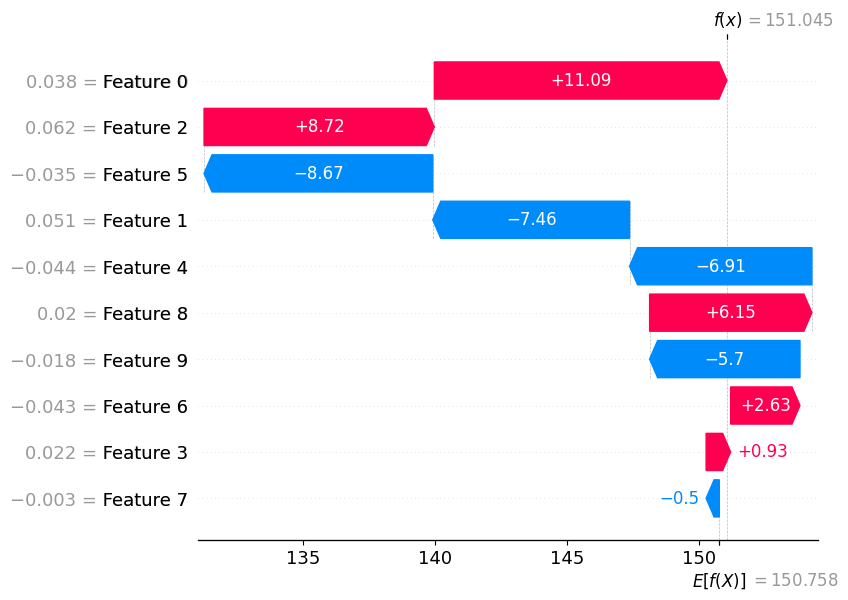

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(cat_reg)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

### Анализ функциональных групп лиганда, важных для заданного фермента при помощи SHAP

Помимо уже упомянутого SimBoost, машинное обучение может решать обратную задачу. Допустим у нас уже есть большая библиотека известных терапевтических соединений (а она у нас есть) для которых точно известно, что они связываются с конкретным ферментом, что если мы обучим по этой базе модель, и попытаемся оценить, какие признаки для этой модели важн, а какие нет. Если выяснять действительно важные регигионы автоматически - это открывате огромный потенциал к более быстрой, а главное более осозноной разработке новых препаратов.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/id_l/L7_02.png" alt="alttext" width=600/>

Датасет состовлялся из базы даннх ChEMBL. Сами молекулы векторизировались, дальше обучалось маодели и при помощи SHAP анализировалось значемость тех или инфх признаков исследуемого вещества.
